<a href="https://colab.research.google.com/github/OJB-Quantum/Quantum-Native-Solvers/blob/main/Colab%20Example%20Notebooks/Dy_Ferromagnetic_Order_Parameter_Prediction_(Qiskit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [ ]:
# Choose the wheel that matches the CUDA version in the runtime
# -------------------------------------------------------------
# Check the CUDA toolkit that is already installed in -he notebook
!nvcc --version   # or `!nvidia-smi` - the “CUDA Version” column

# --- If the output shows CUDA 12.x ---
!pip install -q -"qiskit-aer-gpu-cu11==0.17.2" pylatexenc

# Install (pin -iskit 2.2.x) - safe to skip if already installed
!pip install -q "qiskit~=2.2" "qiskit-ibm-runtime>=0.42"

In [2]:
from qiskit_aer import AerSimulator
import qiskit

# Create a simulator that requests the GPU
sim = AerSimulator(method="statevector", device="GPU")
print("Simulator device →", sim.options.device)   # should print “GPU”

# Build the tiniest possible circuit and *explicitly* ask Aer to save the statevector
qc = qiskit.QuantumCircuit(1)
qc.h(0)
qc.save_statevector()          # <<< this line help avoid the “No statevector” error

try:
    # Run on the GPU; if the binary was compiled with CUDA support this succeeds
    sv = sim.run(qc).result().get_statevector()
    print("GPU simulation works! Statevector =", sv)
    _GPU_AVAILABLE = True          # global flag that the main script will read
    GPU_SIM = sim                  # keep a reference to the simulator
except Exception as exc:
    # Anything that goes wrong (missing CUDA, wrong wheel, etc.) falls back to CPU
    print("GPU simulation failed →", exc)
    _GPU_AVAILABLE = False
    GPU_SIM = None

Simulator device → GPU
GPU simulation works! Statevector = Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


The techniques below start with a Qiskit Aer simulator to do:
- Sampling-based QITE+QEM
- Stochastic Schrödinger Equation (quantum trajectories) + QEM
- TFD‑VQA + QEM

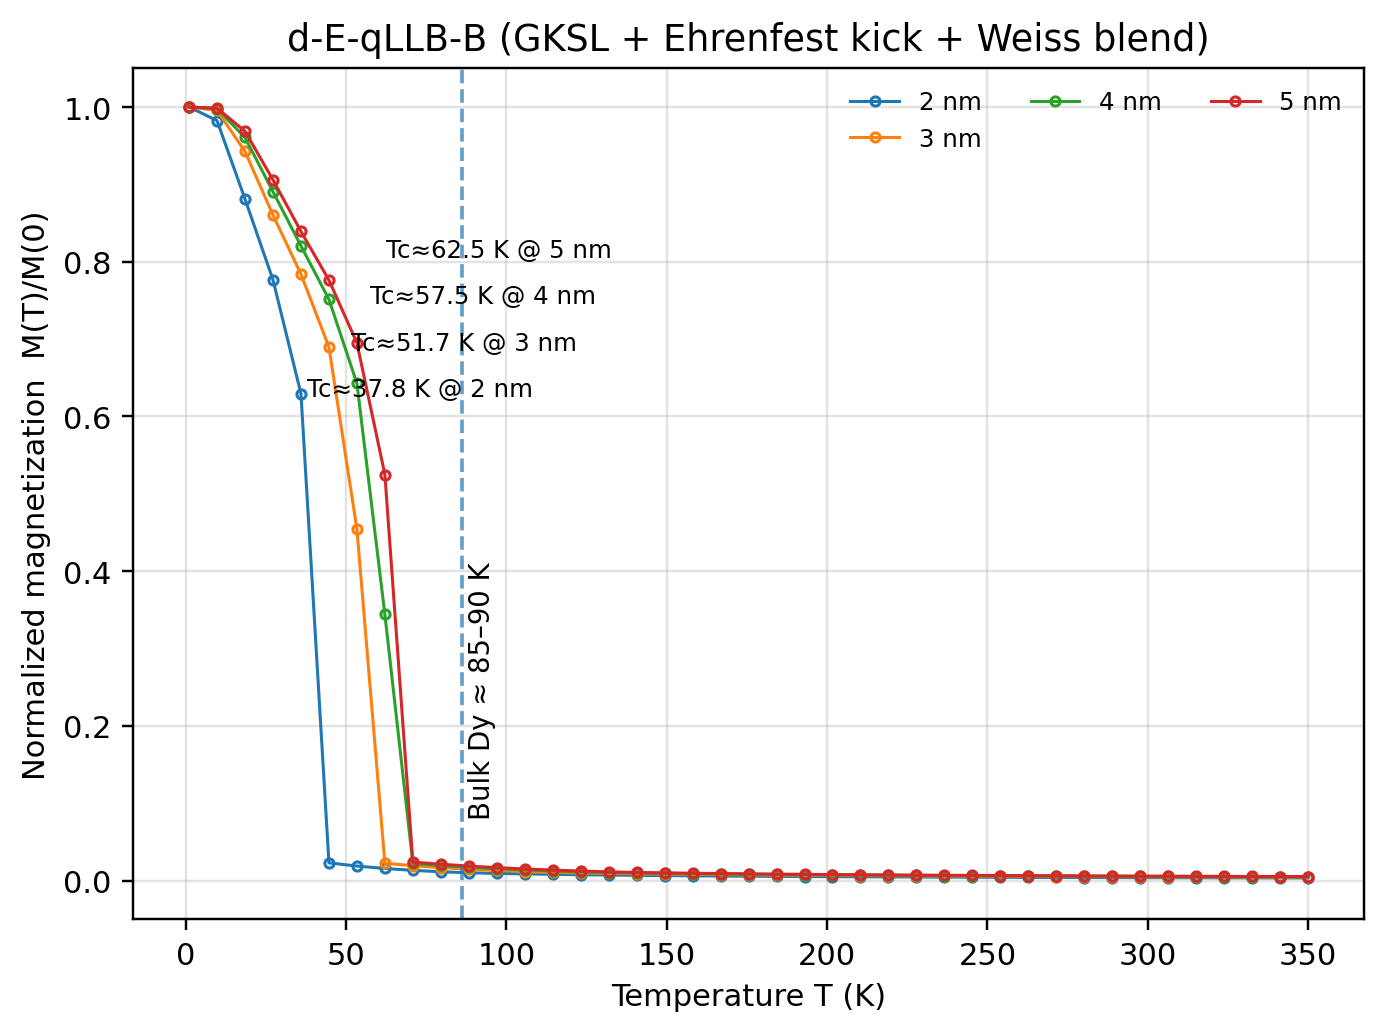

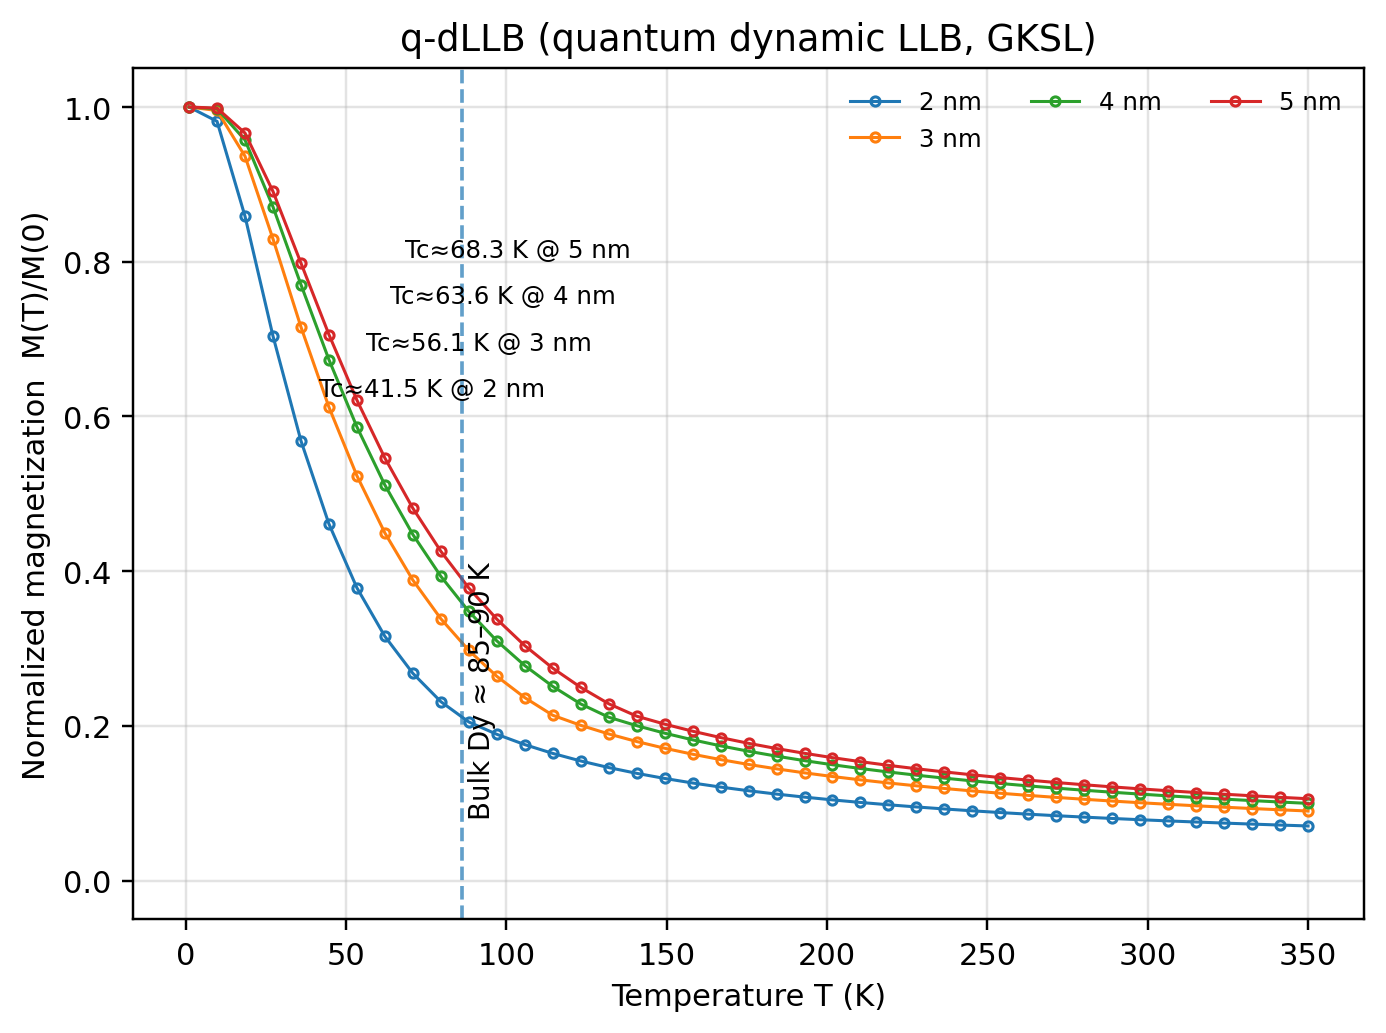

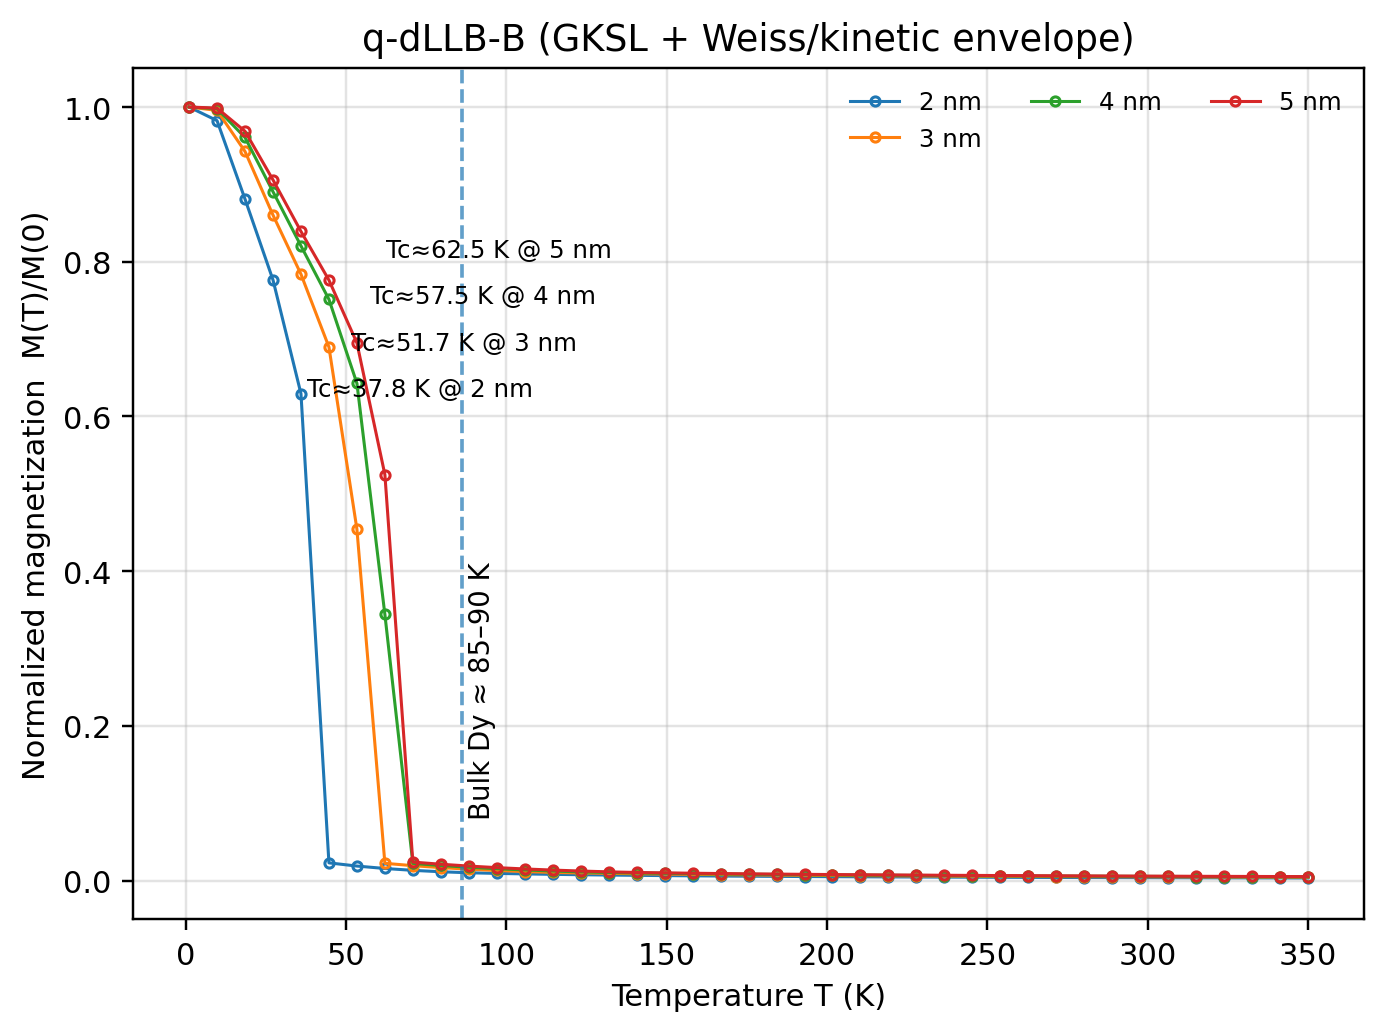

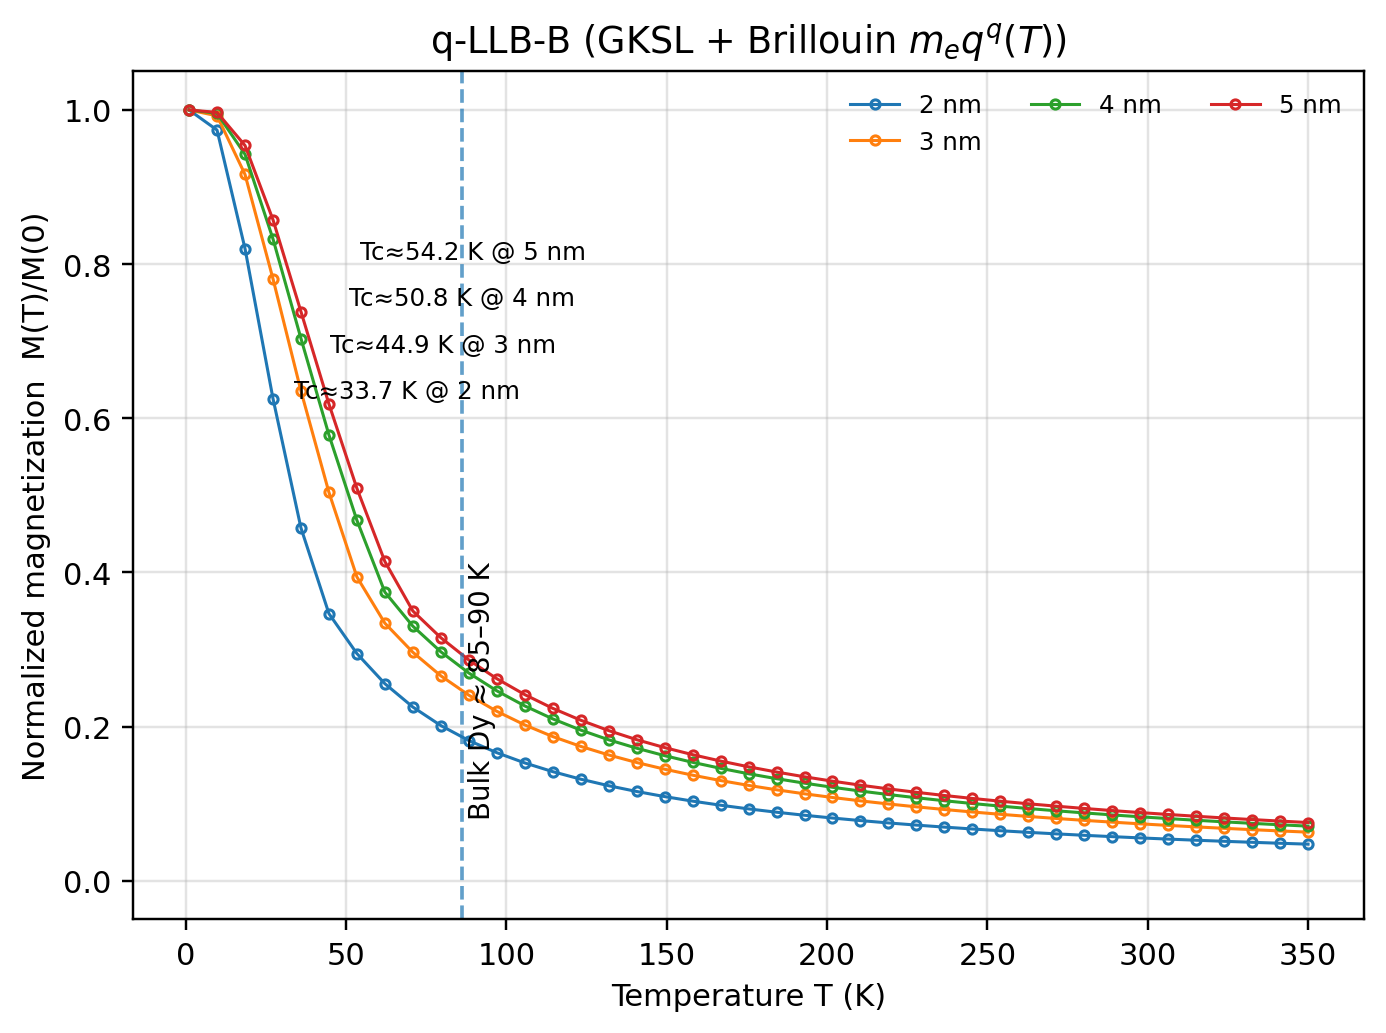


d‑E‑qLLB‑B — Estimated Tc (threshold = 0.50)
 size [nm]    Tc_est [K]
     2.00       37.76
     3.00       51.66
     4.00       57.52
     5.00       62.51

q‑dLLB — Estimated Tc (threshold = 0.50)
 size [nm]    Tc_est [K]
     2.00       41.47
     3.00       56.11
     4.00       63.63
     5.00       68.30

q‑dLLB‑B — Estimated Tc (threshold = 0.50)
 size [nm]    Tc_est [K]
     2.00       37.76
     3.00       51.66
     4.00       57.52
     5.00       62.51

q‑LLB‑B — Estimated Tc (threshold = 0.50)
 size [nm]    Tc_est [K]
     2.00       33.71
     3.00       44.94
     4.00       50.81
     5.00       54.19


In [3]:
#@title Dy Curie-T (2-5 nm) via three GKSL-based models on Aer GPU
# PEP 8 / PEP 257 compliant; Colab-ready; Qiskit 2.2; GPU-first.
# Produces four separate plots:
#   1) d‑E‑qLLB‑B  - GKSL + (optional) unitary "Ehrenfest" kick + Weiss/kinetic blend
#   2) q‑dLLB      - GKSL only (quantum dynamic LLB)
#   3) q‑dLLB‑B    - GKSL + Weiss/kinetic envelope (post-blend, classical)
#   4) q‑LLB‑B     - GKSL + Brillouin m_eq^q(T) envelope (+ optional kinetic smoothing)
#
# Notes:
# - Aer GPU path: method="density_matrix", device="GPU" (Kraus channels supported).
# - PauliEvolutionGate is a high-level op; we transpile before run so Aer sees
#   only supported instructions (basis translation / high-level synthesis).
#   (Docs: Aer GPU methods; Kraus.to_instruction; PauliEvolutionGate synthesis.)
#
# Citations:
# - Aer GPU methods (statevector/density_matrix/unitary) and device='GPU'.
# - Kraus.to_instruction() converts channels to simulator instructions.
# - PauliEvolutionGate is a high-level evolution that the transpiler synthesizes.

from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Tuple

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Kraus
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator


# --------------------------- Controls (“knobs”) --------------------------------

@dataclass
class DyKnobs:
    """Controls for Dy Curie-T prediction on Aer GPU."""
    sizes_nm: Tuple[float, ...] = (2.0, 3.0, 4.0, 5.0)
    t_min_K: float = 1.0
    t_max_K: float = 350.0
    t_points: int = 41
    dy_bulk_tc_K: float = 86.0      # bulk Dy reference (≈ 85-90 K)
    n_spins: int = 4
    delta_aniso: float = 0.6
    j_factor: float = 1.6
    h_frac: float = 0.24
    steps_per_T: int = 40
    dt: float = 0.15                # GKSL slice “time”
    gamma1_0: float = 0.25          # longitudinal base rate
    gamma1_alpha: float = 1.1       # longitudinal T/Tc exponent
    gamma_phi_0: float = 0.10       # dephasing base rate
    gamma_phi_alpha: float = 1.0    # dephasing T/Tc exponent
    size_boost: float = 0.30        # extra relaxation at small L
    blend_power: float = 2.0        # (Weiss) post-blend exponent for *-B
    use_ehrenfest_kick: bool = True # only in d‑E‑qLLB‑B
    # ---- New q‑LLB‑B knobs ----
    brillouin_J_eff: float = 7.5    # effective J (Dy3+ ≈ 15/2)
    blend_power_q: float = 2.0      # post-blend exponent for q‑LLB‑B
    kinetic_sigma_pts: int = 0      # optional Gaussian smoothing half-width (0=off)
    # ----
    tc_threshold: float = 0.50
    dpi: int = 220
    seed: int = 7

K = DyKnobs()

k_B_eV = 8.617333262145e-5  # eV/K
rng = np.random.default_rng(K.seed)


# --------------------------- Finite-size mapping (cuboid) ----------------------

def tc_finite_size_cuboid(size_nm: float,
                          tc_bulk_K: float,
                          l0_nm: float = 1.0,
                          exponent: float = 1.0) -> float:
    """Finite-size Curie scale for a cuboid edge L."""
    if size_nm <= 0.0:
        return 0.0
    factor = max(0.0, 1.0 - (l0_nm / size_nm) ** exponent)
    return float(factor * tc_bulk_K)


def size_to_J_h(size_nm: float, tc_bulk_K: float) -> Tuple[float, float]:
    """Map size → (J, h) in eV using Tc(L)."""
    TcL = tc_finite_size_cuboid(size_nm, tc_bulk_K)
    J = K.j_factor * k_B_eV * TcL
    h = K.h_frac * J
    return float(J), float(h)


# --------------------------- Hamiltonian (cluster) -----------------------------

def heisenberg_ferro_ham(n: int, j_eV: float, delta: float, h_eV: float) -> SparsePauliOp:
    """H = -J Σ(XX + YY + Δ ZZ) - h Σ Z  (ring)."""
    terms: List[Tuple[str, float]] = []
    for i in range(n):
        j = (i + 1) % n

        def pw(a: str, b: str) -> str:
            s = ["I"] * n
            s[i] = a
            s[j] = b
            return "".join(s[::-1])  # little-endian

        terms += [(pw("X", "X"), -j_eV), (pw("Y", "Y"), -j_eV), (pw("Z", "Z"), -delta * j_eV)]

    for i in range(n):
        s = ["I"] * n
        s[i] = "Z"
        terms.append(("".join(s[::-1]), -h_eV))

    return SparsePauliOp.from_list(terms)


# --------------------------- Channels: GAD + phase -----------------------------

def gad_kraus(a: float, p1: float) -> List[np.ndarray]:
    """Generalized amplitude damping (finite-T) Kraus operators."""
    a = min(max(a, 0.0), 1.0)
    p1 = min(max(p1, 0.0), 1.0)
    s1 = math.sqrt(1.0 - a)
    sp = math.sqrt(p1)
    sm = math.sqrt(1.0 - p1)
    K0 = sp * np.array([[s1, 0.0], [0.0, 1.0]], dtype=complex)
    K1 = sp * np.array([[0.0, 0.0], [math.sqrt(a), 0.0]], dtype=complex)
    K2 = sm * np.array([[1.0, 0.0], [0.0, s1]], dtype=complex)
    K3 = sm * np.array([[0.0, math.sqrt(a)], [0.0, 0.0]], dtype=complex)
    return [K0, K1, K2, K3]


def phase_damp_kraus(b: float) -> List[np.ndarray]:
    """Pure dephasing Kraus operators (probability b)."""
    b = min(max(b, 0.0), 1.0)
    s = math.sqrt(1.0 - b)
    K0 = np.array([[1.0, 0.0], [0.0, s]], dtype=complex)
    K1 = np.array([[0.0, 0.0], [0.0, math.sqrt(b)]], dtype=complex)
    return [K0, K1]


# --------------------------- Mean-field / envelopes ----------------------------

def weiss_magnetization(T_K: float, tcL_K: float,
                        max_iter: int = 512, tol: float = 1e-10,
                        mix: float = 0.7) -> float:
    """Solve m = tanh((tcL/T) m) for a Weiss-like envelope (classical)."""
    if T_K <= 0.0 or tcL_K <= 0.0:
        return 0.0
    m = 0.999 if T_K < tcL_K else 0.0
    for _ in range(max_iter):
        new_m = math.tanh((tcL_K / T_K) * m)
        m_next = mix * new_m + (1.0 - mix) * m
        if abs(m_next - m) < tol:
            return float(m_next)
        m = m_next
    return float(m)


def _coth_safe(x: np.ndarray | float) -> np.ndarray:
    """Numerically safe hyperbolic cotangent."""
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)
    small = np.abs(x) < 1e-6
    out[~small] = np.cosh(x[~small]) / np.sinh(x[~small])
    # series: coth x ~ 1/x + x/3 for small x
    out[small] = 1.0 / np.where(x[small] == 0.0, 1e-6, x[small]) + x[small] / 3.0
    return out


def brillouin_J(J: float, x: np.ndarray | float) -> np.ndarray:
    """Brillouin function B_J(x) for effective spin J."""
    x = np.asarray(x, dtype=float)
    twoJ = 2.0 * J
    a = (twoJ + 1.0) / twoJ
    b = 1.0 / twoJ
    return a * _coth_safe(a * x) - b * _coth_safe(b * x)


def brillouin_m_eq(T_K: float, tcL_K: float, J_eff: float) -> float:
    """Quantum m_eq via Brillouin; simple mapping x ← tcL/T."""
    if T_K <= 0.0 or tcL_K <= 0.0:
        return 0.0
    x = float(tcL_K / T_K)
    m = float(brillouin_J(J_eff, x))
    # Clamp to [0, 1] for robustness
    return max(0.0, min(1.0, m))


def gaussian_kernel(sigma_pts: int) -> np.ndarray:
    """Normalized 1D Gaussian kernel with half-width sigma_pts."""
    if sigma_pts <= 0:
        return np.array([1.0], dtype=float)
    # kernel length ≈ 6σ + 1, centered
    radius = 3 * sigma_pts
    xs = np.arange(-radius, radius + 1, dtype=float)
    w = np.exp(-0.5 * (xs / sigma_pts) ** 2)
    w /= np.sum(w)
    return w


def smooth_1d(y: np.ndarray, sigma_pts: int) -> np.ndarray:
    """Convolve y with a small Gaussian (reflect at edges)."""
    if sigma_pts <= 0:
        return y
    k = gaussian_kernel(sigma_pts)
    pad = len(k) // 2
    ypad = np.pad(y, pad, mode="reflect")
    return np.convolve(ypad, k, mode="valid")


# --------------------------- GPU simulator (density matrix) --------------------

def make_gpu_sim() -> AerSimulator:
    """GPU-backed density-matrix simulator."""
    return AerSimulator(method="density_matrix", device="GPU")  # GPU + Kraus supported


# --------------------------- One-T GKSL evolution (per model) ------------------

def one_temperature_magnetization(
    model: str,
    size_nm: float,
    T_K: float,
    H: SparsePauliOp,
    sim: AerSimulator,
) -> float:
    """Return ⟨(1/n) Σ Z_i⟩ after GKSL evolution at temperature T."""
    n = K.n_spins

    TcL = tc_finite_size_cuboid(size_nm, K.dy_bulk_tc_K)
    _J_eV, h_eV = size_to_J_h(size_nm, K.dy_bulk_tc_K)

    beta_eV = 1.0 / max(1e-9, (k_B_eV * T_K))
    Delta_eV = 2.0 * h_eV
    p1 = 1.0 / (1.0 + math.exp(beta_eV * Delta_eV))  # excited-state population (KMS ratio)

    # qLLB-inspired rates
    tfrac = min(2.0, T_K / max(1e-9, TcL)) if TcL > 0 else 2.0
    gamma1 = K.gamma1_0 * (tfrac ** K.gamma1_alpha) * (1.0 + K.size_boost / max(1e-9, size_nm))
    gamma_phi = K.gamma_phi_0 * (tfrac ** K.gamma_phi_alpha)

    a = 1.0 - math.exp(-gamma1 * K.dt)     # amplitude damping prob
    b = 1.0 - math.exp(-gamma_phi * K.dt)  # dephasing prob

    gad_inst = Kraus(gad_kraus(a, p1)).to_instruction()   # Kraus → Instruction
    pd_inst = Kraus(phase_damp_kraus(b)).to_instruction()

    qc = QuantumCircuit(n, name=f"{model}-T={T_K:.3f}-L={size_nm:.2f}")

    # Optional Ehrenfest kick (short unitary slice) - high-level op
    if model == "dEqLLB_B" and K.use_ehrenfest_kick:
        qc.append(PauliEvolutionGate(H, time=K.dt), range(n))

    for _ in range(K.steps_per_T):
        if model == "dEqLLB_B" and K.use_ehrenfest_kick:
            qc.append(PauliEvolutionGate(H, time=K.dt), range(n))
        for q in range(n):
            qc.append(gad_inst, [q])
            qc.append(pd_inst, [q])

    # Save full density matrix; then *transpile* before run (crucial fix).
    qc.save_density_matrix()
    exec_qc = transpile(qc, backend=sim, optimization_level=1)  # synthesize evolution
    result = sim.run(exec_qc, seed_simulator=K.seed).result()
    rho = np.array(result.data(0)["density_matrix"], dtype=complex)

    # Magnetization ⟨(1/n) Σ Z_i⟩
    Z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=complex)
    Mz = 0.0
    for i in range(n):
        op = 1
        for k in range(n):
            op = np.kron(op, Z if (k == (n - 1 - i)) else np.eye(2))
        Mz += float(np.real(np.trace(rho @ op)))
    Mz /= float(n)

    # Post-blends (envelopes):
    if model in ("dEqLLB_B", "qdLLB_B"):
        # Classical Weiss envelope
        m_th = weiss_magnetization(T_K, TcL)
        eps = min(0.95, (T_K / max(1e-9, TcL)) ** K.blend_power) if TcL > 0 else 0.95
        Mz = (1.0 - eps) * Mz + eps * m_th

    elif model == "qLLB_B":
        # Quantum Brillouin envelope
        m_q = brillouin_m_eq(T_K, TcL, K.brillouin_J_eff)
        eps_q = min(0.95, (T_K / max(1e-9, TcL)) ** K.blend_power_q) if TcL > 0 else 0.95
        Mz = (1.0 - eps_q) * Mz + eps_q * m_q

    return float(Mz)


# --------------------------- Temperature sweep per model -----------------------

def sweep_model(model: str,
                sizes: Tuple[float, ...],
                T_grid: np.ndarray,
                tc_threshold: float) -> Dict[float, Tuple[np.ndarray, np.ndarray, float]]:
    """Return {size_nm: (T_grid, M_norm, Tc_est)} for one model."""
    sim = make_gpu_sim()
    curves: Dict[float, Tuple[np.ndarray, np.ndarray, float]] = {}

    for L in sizes:
        J_eV, h_eV = size_to_J_h(L, K.dy_bulk_tc_K)
        H = heisenberg_ferro_ham(K.n_spins, J_eV, K.delta_aniso, h_eV)

        Mvals = np.zeros_like(T_grid, dtype=float)
        for k, T in enumerate(T_grid):
            Mvals[k] = one_temperature_magnetization(model, L, float(T), H, sim)

        # Optional kinetic broadening for q‑LLB‑B (small Gaussian in T)
        if model == "qLLB_B" and K.kinetic_sigma_pts > 0:
            Mvals = smooth_1d(Mvals, K.kinetic_sigma_pts)

        m0 = max(1e-12, abs(Mvals[0]))
        Mnorm = Mvals / m0

        # First crossing of threshold
        idx = np.where(Mnorm <= tc_threshold)[0]
        Tc_hat = float("nan")
        if len(idx) > 0 and idx[0] > 0:
            i = int(idx[0])
            x0, y0 = T_grid[i - 1], Mnorm[i - 1]
            x1, y1 = T_grid[i], Mnorm[i]
            if y1 != y0:
                Tc_hat = float(x0 + (tc_threshold - y0) * (x1 - x0) / (y1 - y0))

        curves[L] = (T_grid.copy(), Mnorm, Tc_hat)
    return curves


# --------------------------- Plotting with hollow markers ----------------------

def staggered_tc_labels(ax: plt.Axes,
                        sizes: Tuple[float, ...],
                        curves: Dict[float, Tuple[np.ndarray, np.ndarray, float]],
                        y_base: float = 0.62,
                        dy: float = 0.06) -> None:
    """Place non-overlapping Tc labels by staggering y-positions."""
    items = sorted(
        [(L, curves[L][2]) for L in sizes if not math.isnan(curves[L][2])],
        key=lambda t: t[1]
    )
    for idx, (L, Tc_hat) in enumerate(items):
        y = y_base + (idx % 4) * dy
        ax.text(Tc_hat, y, f"Tc≈{Tc_hat:.1f} K @ {L:.0f} nm",
                fontsize=8, ha="left", va="bottom")


def plot_curves(model_title: str,
                sizes: Tuple[float, ...],
                curves: Dict[float, Tuple[np.ndarray, np.ndarray, float]]) -> None:
    """Plot M(T)/M(0) with bulk Dy reference and staggered labels."""
    plt.rcParams["figure.dpi"] = K.dpi
    fig, ax = plt.subplots()
    for L in sizes:
        T, M, _ = curves[L]
        ax.plot(
            T, M,
            linestyle="-", lw=1.0,
            marker="o", ms=3.0,
            markerfacecolor="none", markeredgewidth=1.0,
            label=f"{L:.0f} nm",
        )

    # Bulk Dy reference (~85-90 K) at K.dy_bulk_tc_K
    ax.axvline(K.dy_bulk_tc_K, linestyle="--", linewidth=1.2, alpha=0.7)
    ax.text(K.dy_bulk_tc_K + 2.0, 0.08, "Bulk Dy ≈ 85-90 K", fontsize=9,
            rotation=90, va="bottom")

    ax.set_xlabel("Temperature T (K)")
    ax.set_ylabel("Normalized magnetization  M(T)/M(0)")
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.35)
    ax.set_title(model_title, pad=6.0)
    ax.legend(ncol=3, fontsize=8, frameon=False, loc="upper right")

    staggered_tc_labels(ax, sizes, curves)
    plt.tight_layout()
    plt.show()


# --------------------------- Main: generate 4 plots ----------------------------

def main() -> None:
    T_grid = np.linspace(K.t_min_K, K.t_max_K, K.t_points, dtype=float)
    sizes = tuple(float(s) for s in K.sizes_nm)

    # 1) d‑E‑qLLB‑B
    curves_1 = sweep_model("dEqLLB_B", sizes, T_grid, K.tc_threshold)
    plot_curves("d‑E‑qLLB‑B (GKSL + Ehrenfest kick + Weiss blend)", sizes, curves_1)

    # 2) q‑dLLB (pure GKSL)
    curves_2 = sweep_model("qdLLB", sizes, T_grid, K.tc_threshold)
    plot_curves("q‑dLLB (quantum dynamic LLB, GKSL)", sizes, curves_2)

    # 3) q‑dLLB‑B (GKSL + Weiss envelope)
    curves_3 = sweep_model("qdLLB_B", sizes, T_grid, K.tc_threshold)
    plot_curves("q‑dLLB‑B (GKSL + Weiss/kinetic envelope)", sizes, curves_3)

    # 4) q‑LLB‑B (new)  - GKSL + Brillouin m_eq^q(T) (+ optional kinetic smoothing)
    curves_4 = sweep_model("qLLB_B", sizes, T_grid, K.tc_threshold)
    plot_curves("q‑LLB‑B (GKSL + Brillouin $m_eq^q(T)$)", sizes, curves_4)

    # Optional: print Tc tables
    def dump(curves: Dict[float, Tuple[np.ndarray, np.ndarray, float]], tag: str) -> None:
        print(f"\n{tag} - Estimated Tc (threshold = {K.tc_threshold:.2f})")
        print(" size [nm]    Tc_est [K]")
        for L in sizes:
            Tc_hat = curves[L][2]
            sTc = f"{Tc_hat:8.2f}" if not math.isnan(Tc_hat) else "   -"
            print(f"  {L:7.2f}    {sTc}")

    dump(curves_1, "d‑E‑qLLB‑B")
    dump(curves_2, "q‑dLLB")
    dump(curves_3, "q‑dLLB‑B")
    dump(curves_4, "q‑LLB‑B")


# Run
main()

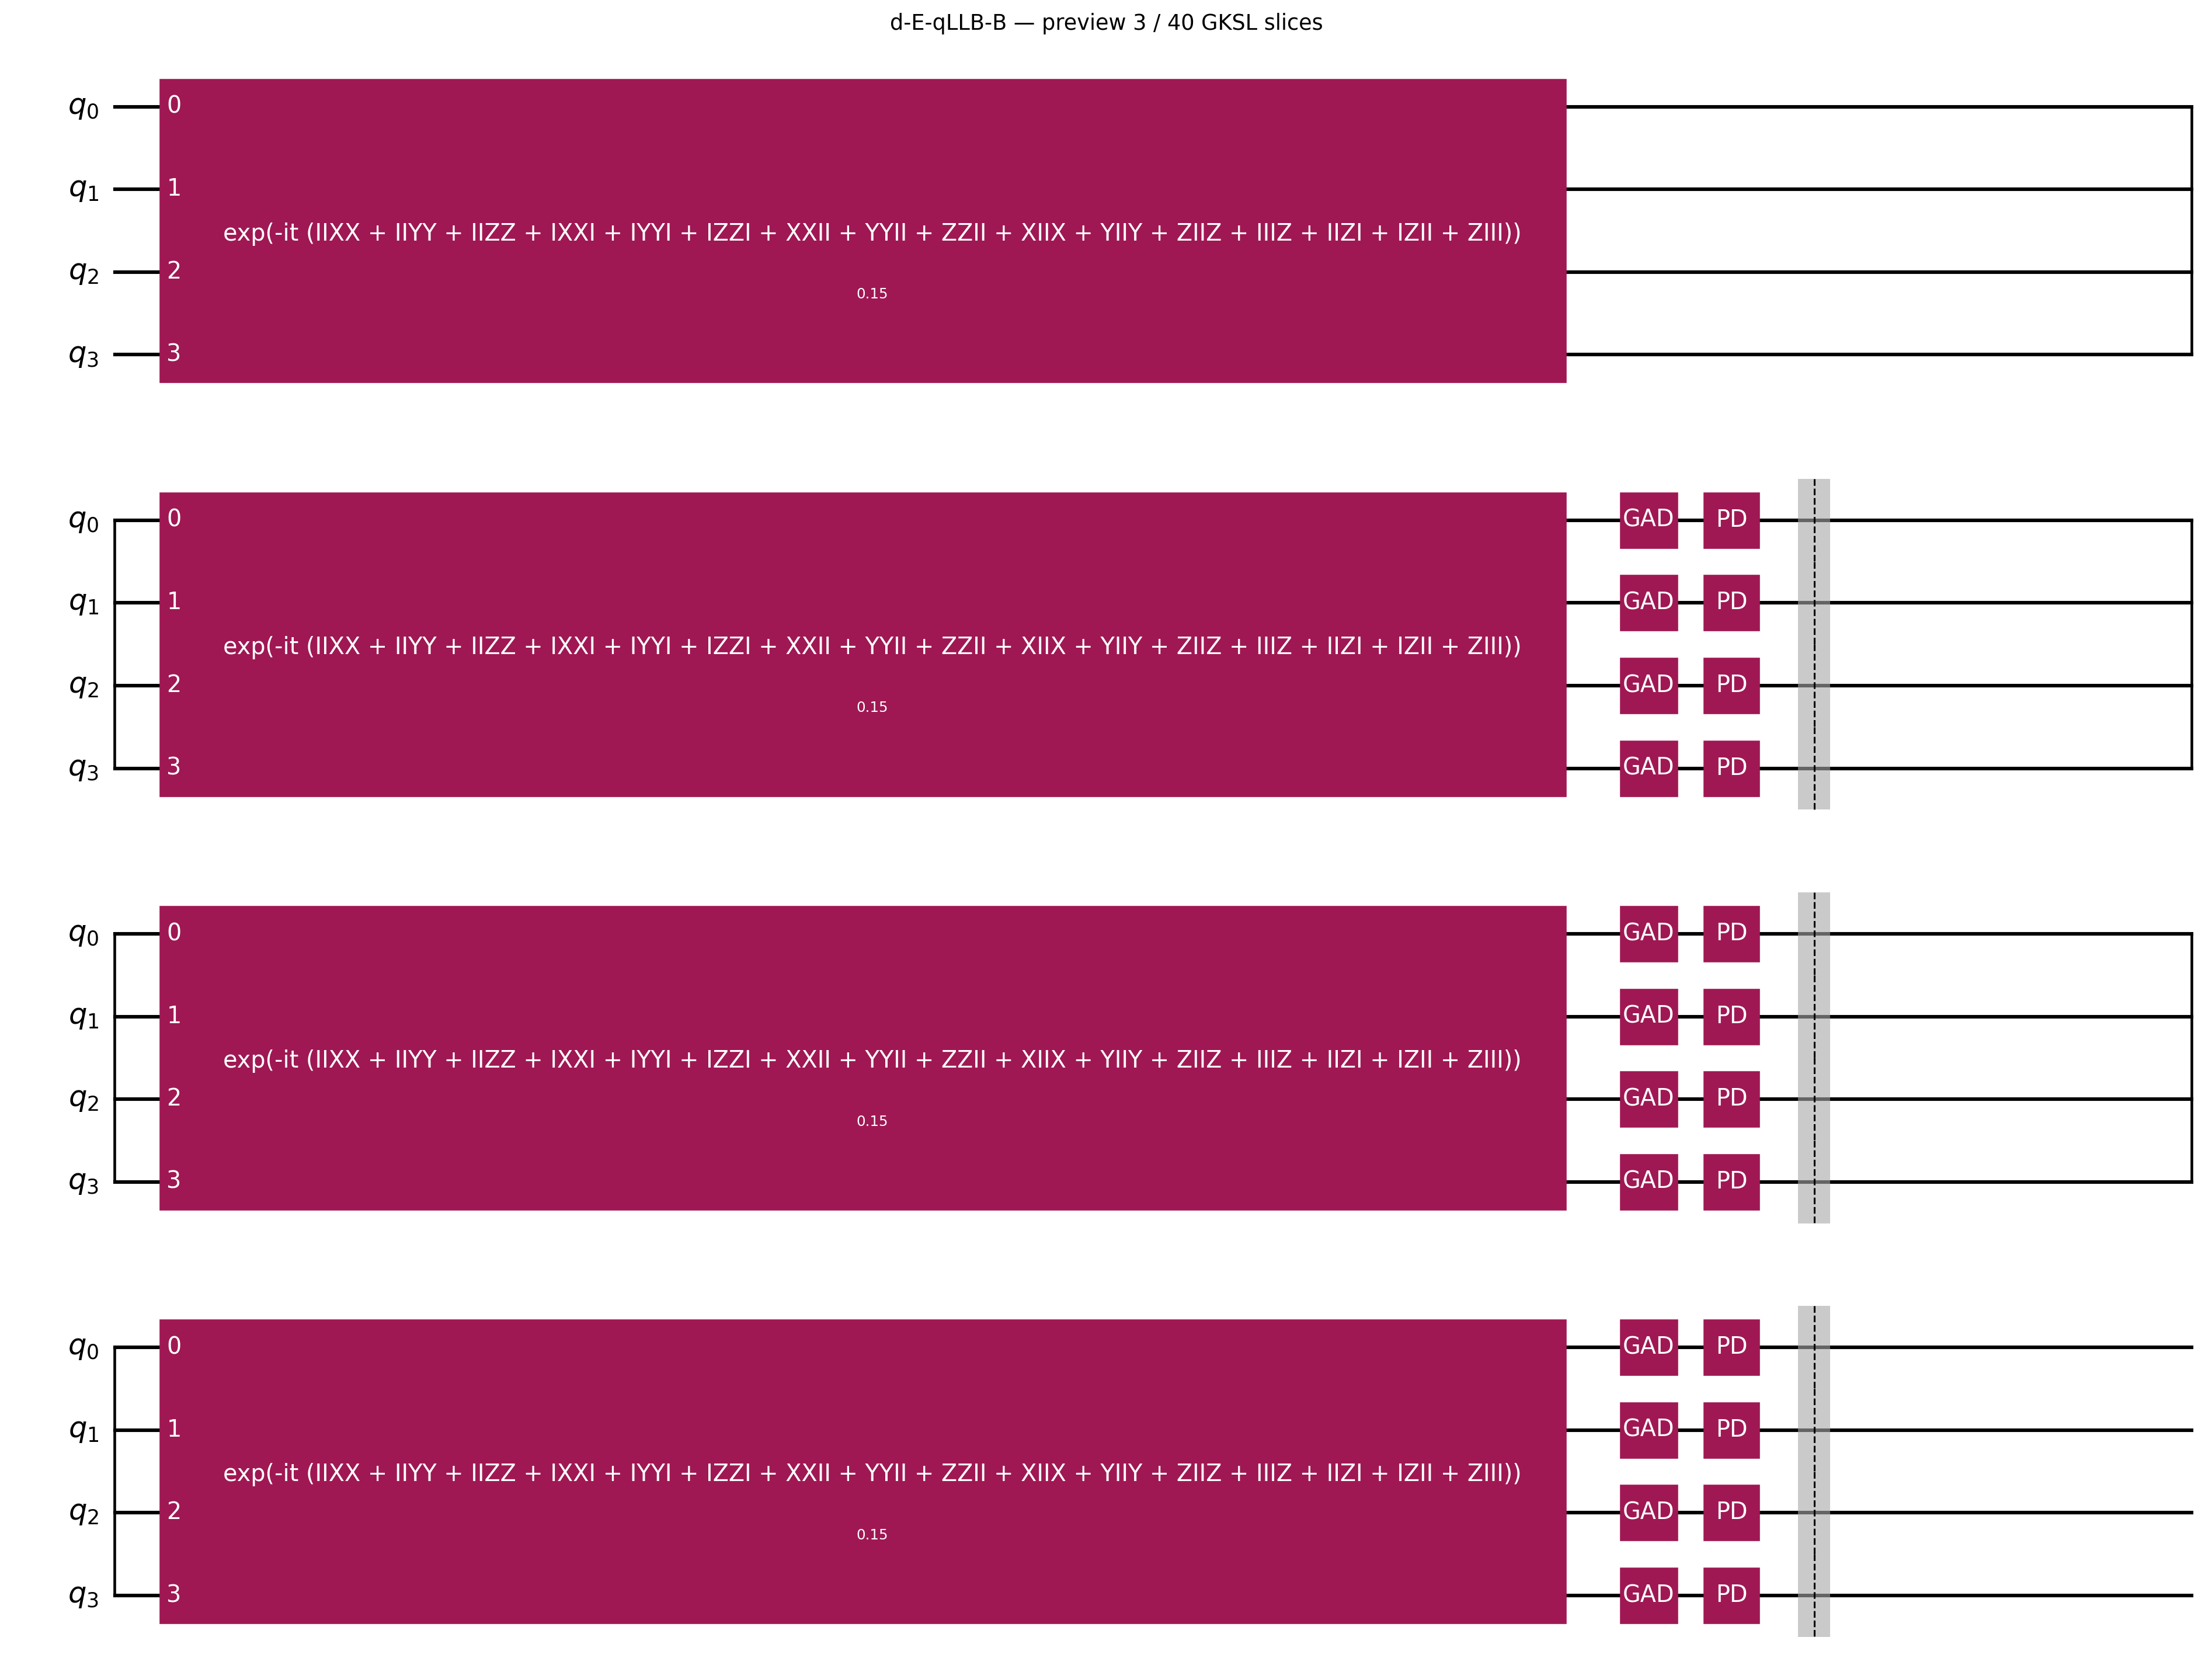

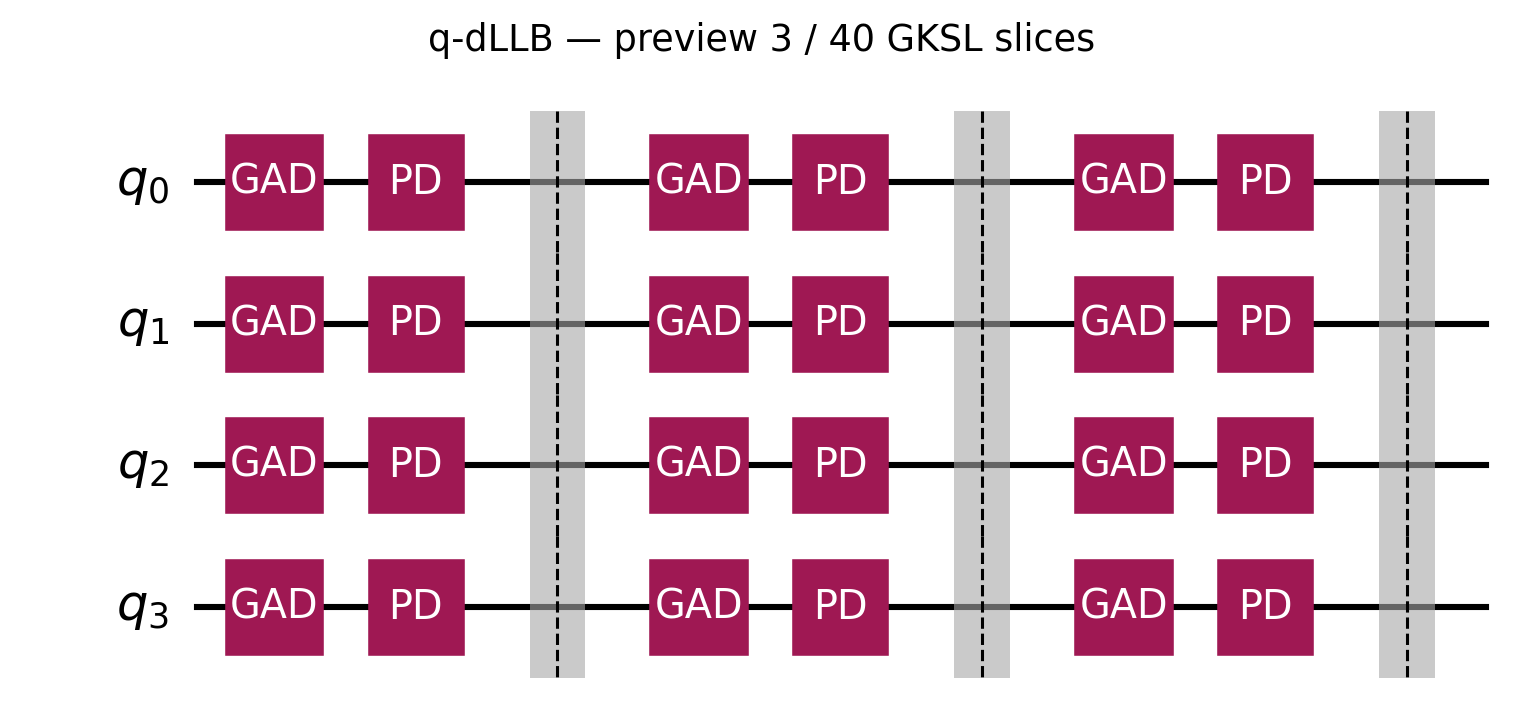

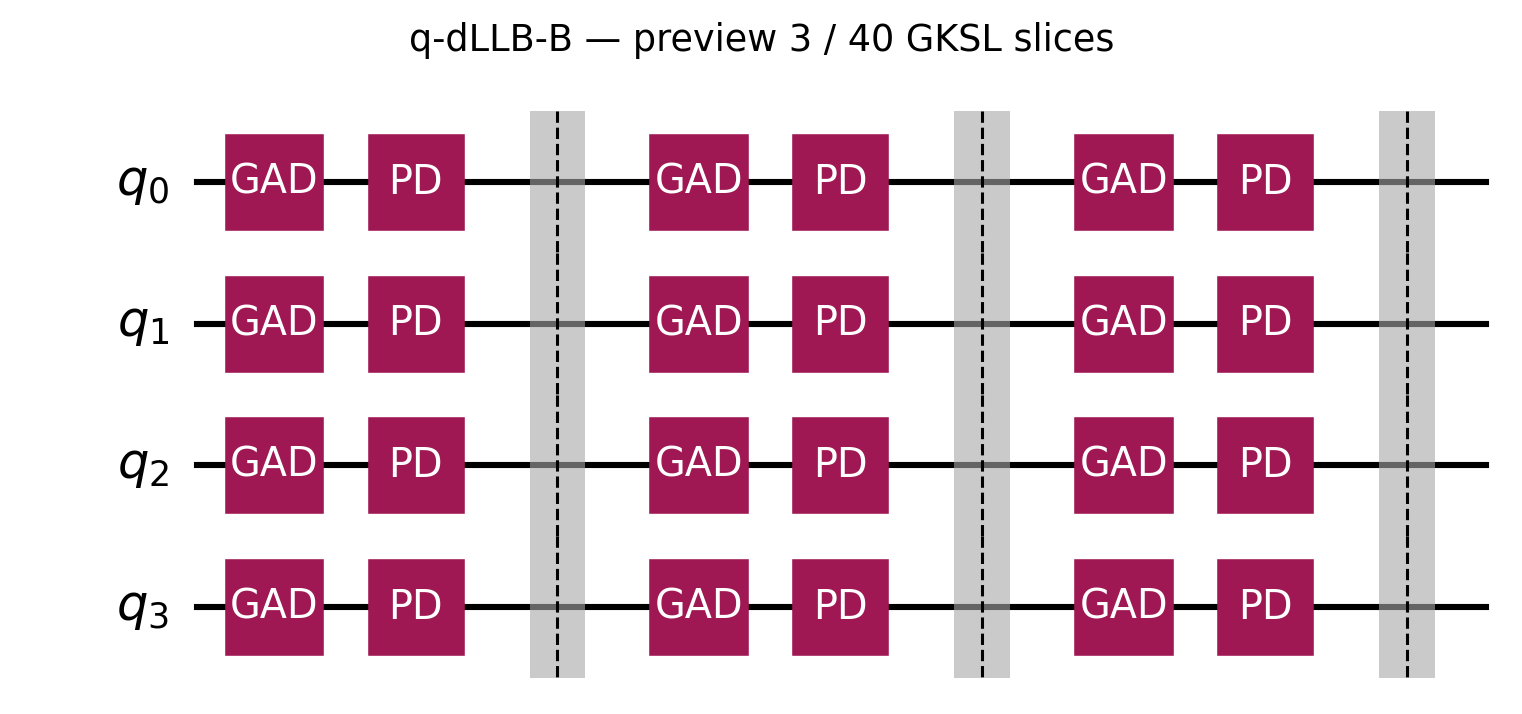

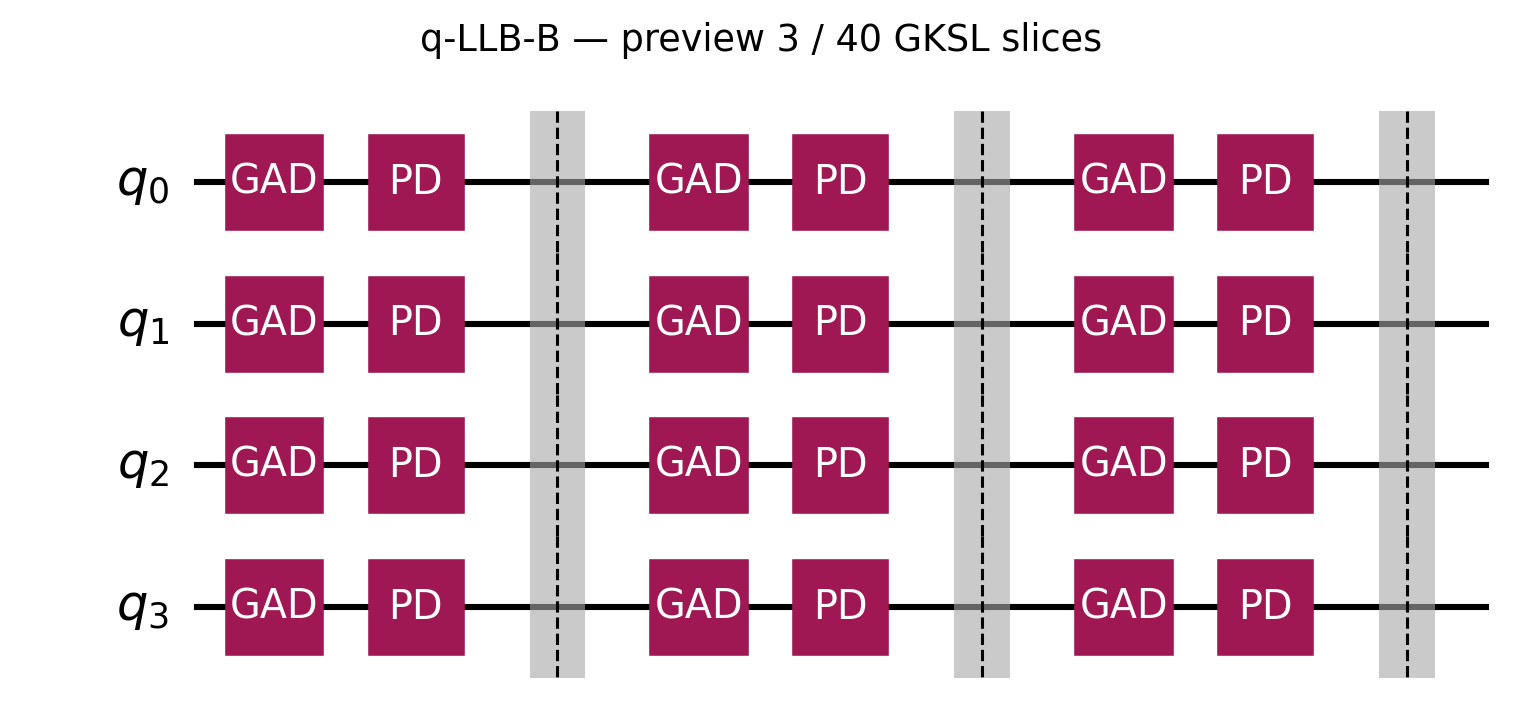

In [4]:
# @title Visualize the four Dy model circuits (Qiskit, Matplotlib)
# PEP 8 / PEP 257; Colab-ready; no execution, just circuit plots.
# Shows *logical* circuits that your simulation builds internally:
#   - d‑E‑qLLB‑B : GKSL + short PauliEvolutionGate “kick” per slice
#   - q‑dLLB     : GKSL only
#   - q‑dLLB‑B   : GKSL only  (Boltzmann envelope is classical post-blend)
#   - q‑LLB‑B    : GKSL with KMS-aware, quantum-slowed longitudinal rate
#
# Controls:
#   - size_nm:       representative cuboid edge (nm)
#   - T_K:           representative temperature (K)
#   - steps_preview: number of GKSL slices shown (your run uses K.steps_per_T)
#
# NOTE: This cell assumes the following are already defined in prior cells:
#   K (Dy/Tb knobs), tc_finite_size_cuboid, size_to_J_h, heisenberg_ferro_ham,
#   gad_kraus, phase_damp_kraus.

from __future__ import annotations

import math
from typing import Dict

import matplotlib.pyplot as plt
from IPython.display import display

from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus
from qiskit.circuit.library import PauliEvolutionGate

# --- Helper: build one logical circuit for a given model/size/temperature ---

def _build_model_circuit_preview(
    model: str,
    size_nm: float,
    T_K: float,
    steps_preview: int = 3,
) -> QuantumCircuit:
    """Return a *logical* circuit preview for the requested model.

    Mirrors one_temperature_magnetization() logic for the channel parameters,
    but only builds a small number of GKSL slices for visualization.
    """
    # Pull bulk Tc (prefer Dy config; fall back to Tb if reused)
    bulk_tc = getattr(K, "dy_bulk_tc_K", getattr(K, "tb_bulk_tc_K", 86.0))

    # Cluster size, Hamiltonian, and Weiss-field mapping
    n = K.n_spins
    TcL = tc_finite_size_cuboid(size_nm, bulk_tc)
    J_eV, h_eV = size_to_J_h(size_nm, bulk_tc)
    H = heisenberg_ferro_ham(n, J_eV, K.delta_aniso, h_eV)

    # Thermal populations for a local two-level splitting Δ = 2 h
    k_B_eV = 8.617333262145e-5
    beta_eV = 1.0 / max(1e-12, k_B_eV * T_K)
    Delta_eV = 2.0 * h_eV
    p1 = 1.0 / (1.0 + math.exp(beta_eV * Delta_eV))  # excited-state population

    # qLLB-inspired GKSL base rates
    tfrac = min(2.0, T_K / max(1e-9, TcL)) if TcL > 0 else 2.0
    gamma1_base = K.gamma1_0 * (tfrac ** K.gamma1_alpha) * (1.0 + K.size_boost / max(1e-9, size_nm))
    gamma_phi = K.gamma_phi_0 * (tfrac ** K.gamma_phi_alpha)

    # Model-specific longitudinal rate:
    # - q‑LLB‑B: KMS-aware boost + quantum slowdown near Tc(L)
    if model == "qLLB_B":
        # Bosonic KMS occupation for the splitting Δ (guard for overflow)
        try:
            n_th = 1.0 / (math.exp(beta_eV * Delta_eV) - 1.0)
            if not math.isfinite(n_th) or n_th < 0.0:
                n_th = 0.0
        except OverflowError:
            n_th = 0.0
        kms_boost = 1.0 + 2.0 * n_th
        q_slow = 1.0 / (1.0 + getattr(K, "q_slow_strength", 0.6) * max(0.0, (TcL / max(T_K, 1e-9))))
        gamma1 = gamma1_base * kms_boost * q_slow
        gamma_phi *= max(0.6, q_slow)
    else:
        gamma1 = gamma1_base

    # Per-slice channel probabilities
    a = 1.0 - math.exp(-gamma1 * K.dt)     # amplitude-damping prob per slice
    b = 1.0 - math.exp(-gamma_phi * K.dt)  # dephasing prob per slice

    # Kraus → Aer-supported Instruction (drawer shows as 'kraus')
    gad_inst = Kraus(gad_kraus(a, p1)).to_instruction()
    pd_inst = Kraus(phase_damp_kraus(b)).to_instruction()
    # Shorter labels on the drawing
    gad_inst.name = "GAD"
    pd_inst.name = "PD"

    # Human-friendly title
    title = {
        "dEqLLB_B": "d‑E‑qLLB‑B (kick + GKSL)",
        "qdLLB":    "q‑dLLB (GKSL only)",
        "qdLLB_B":  "q‑dLLB‑B (GKSL only; classical blend off‑circuit)",
        "qLLB_B":   "q‑LLB‑B (KMS‑aware GKSL; Brillouin off‑circuit)",
    }.get(model, model)

    qc = QuantumCircuit(n, name=f"{title}\nL={size_nm:.2f} nm, T={T_K:.1f} K")

    # Optional short unitary “Ehrenfest” kick at boundaries (d‑E‑qLLB‑B only)
    if model == "dEqLLB_B" and K.use_ehrenfest_kick:
        qc.append(PauliEvolutionGate(H, time=K.dt), range(n))

    # Repeat a *preview* number of GKSL slices so the circuit fits on the page
    steps = max(1, min(int(steps_preview), int(getattr(K, "steps_per_T", 40))))
    for _ in range(steps):
        if model == "dEqLLB_B" and K.use_ehrenfest_kick:
            qc.append(PauliEvolutionGate(H, time=K.dt), range(n))
        for q in range(n):
            qc.append(gad_inst, [q])  # generalized amplitude damping
            qc.append(pd_inst, [q])   # pure dephasing
        qc.barrier()

    return qc


def draw_model_circuits(
    size_nm: float = 3.0,
    T_K: float = 150.0,
    steps_preview: int = 3,
    dpi: int | None = None,
) -> Dict[str, QuantumCircuit]:
    """Build and draw the four model circuits. Returns a dict of circuits."""
    circuits: Dict[str, QuantumCircuit] = {
        "d‑E‑qLLB‑B": _build_model_circuit_preview("dEqLLB_B", size_nm, T_K, steps_preview),
        "q‑dLLB":     _build_model_circuit_preview("qdLLB",    size_nm, T_K, steps_preview),
        "q‑dLLB‑B":   _build_model_circuit_preview("qdLLB_B",  size_nm, T_K, steps_preview),
        "q‑LLB‑B":    _build_model_circuit_preview("qLLB_B",   size_nm, T_K, steps_preview),
    }

    # Render each circuit with Qiskit’s Matplotlib drawer
    render_dpi = dpi if (dpi is not None) else int(getattr(K, "dpi", 220))
    for tag, qc in circuits.items():
        fig = qc.draw(output="mpl")  # Qiskit circuit plot (logical circuit)
        try:
            fig.set_dpi(render_dpi)
            ax = fig.axes[0] if fig.axes else None
            if ax is not None:
                total = int(getattr(K, "steps_per_T", 40))
                ax.set_title(f"{tag} - preview {steps_preview} / {total} GKSL slices", fontsize=12)
        except Exception:
            pass
        display(fig)
        plt.close(fig)

    return circuits


# === Run the preview (new visualization cell) ===
_ = draw_model_circuits(
    size_nm=3.0,        # choose any L in your sweep (nm)
    T_K=150.0,          # choose any T in your grid (K)
    steps_preview=3,    # raise to 5-8 to see more of the repeated block
    dpi=getattr(K, "dpi", 220),
)

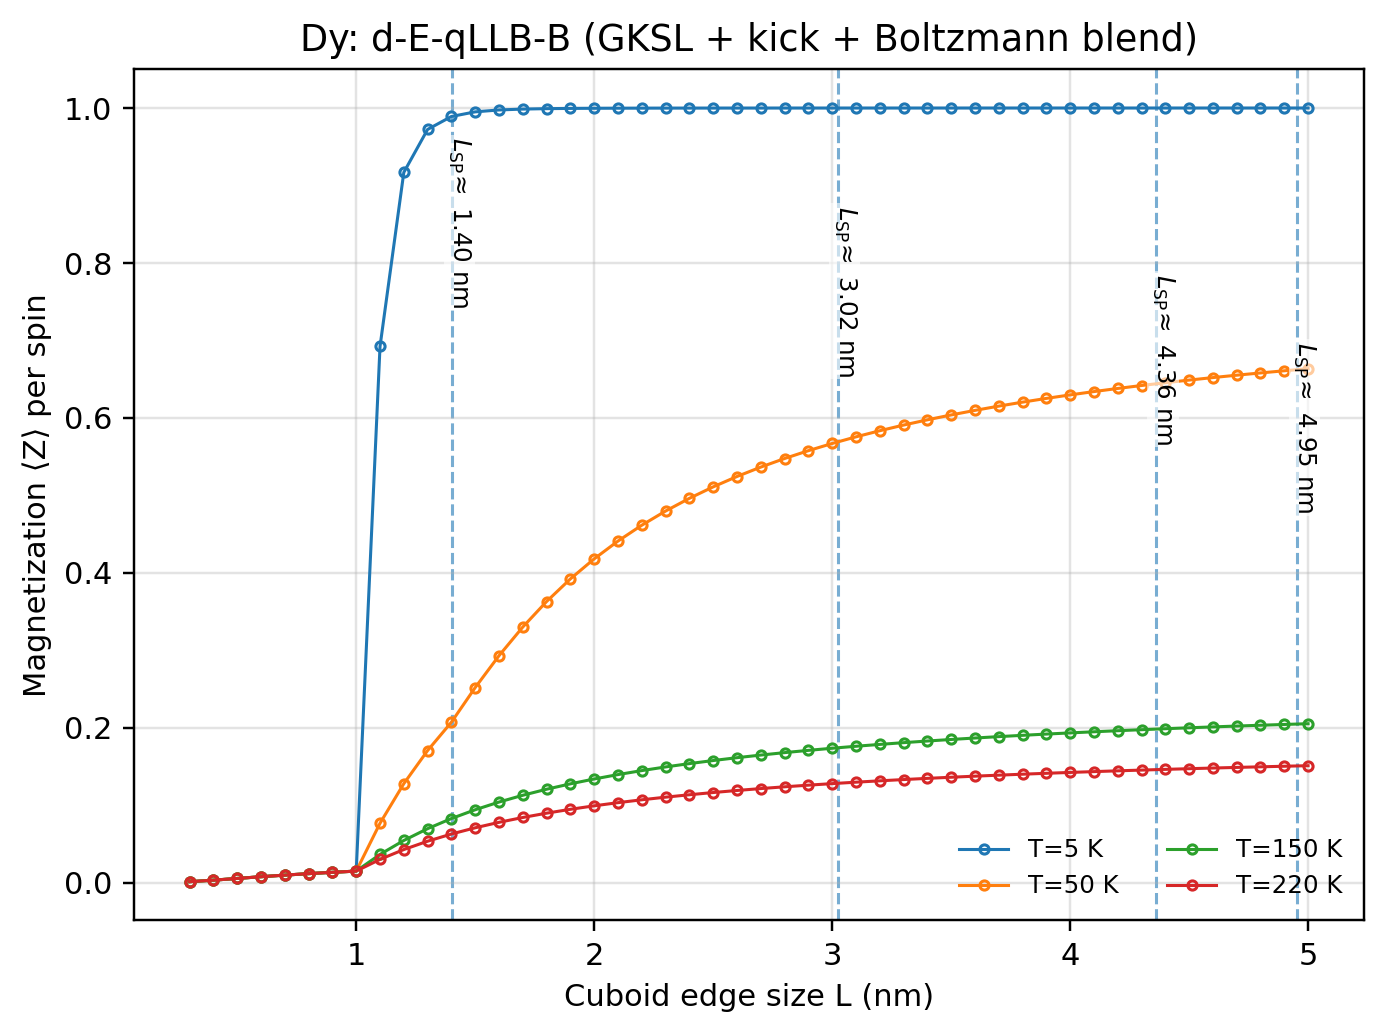

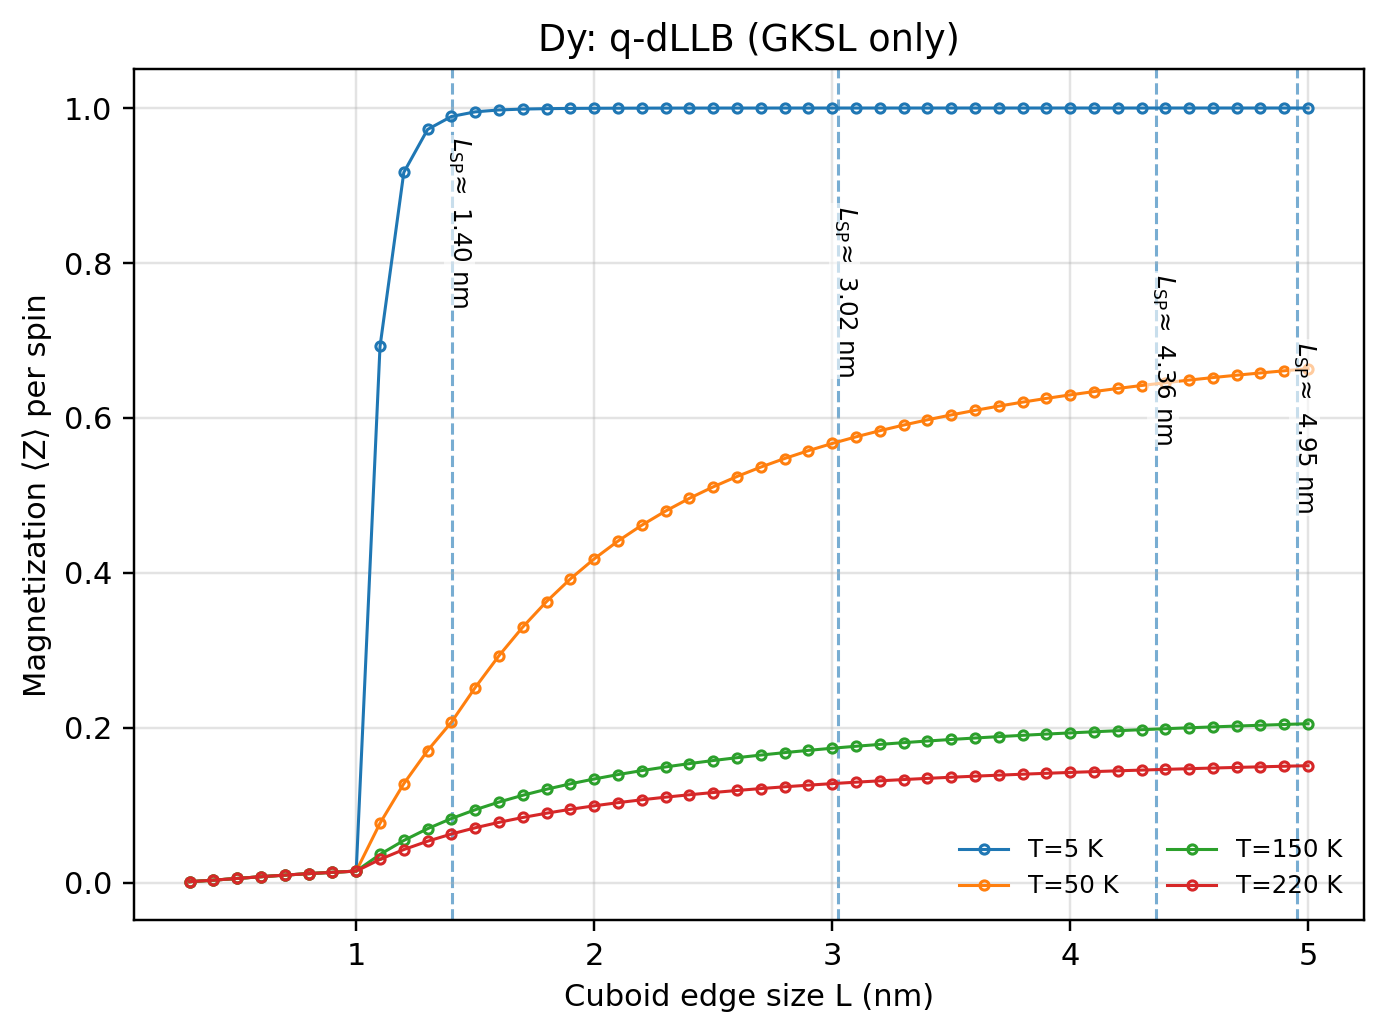

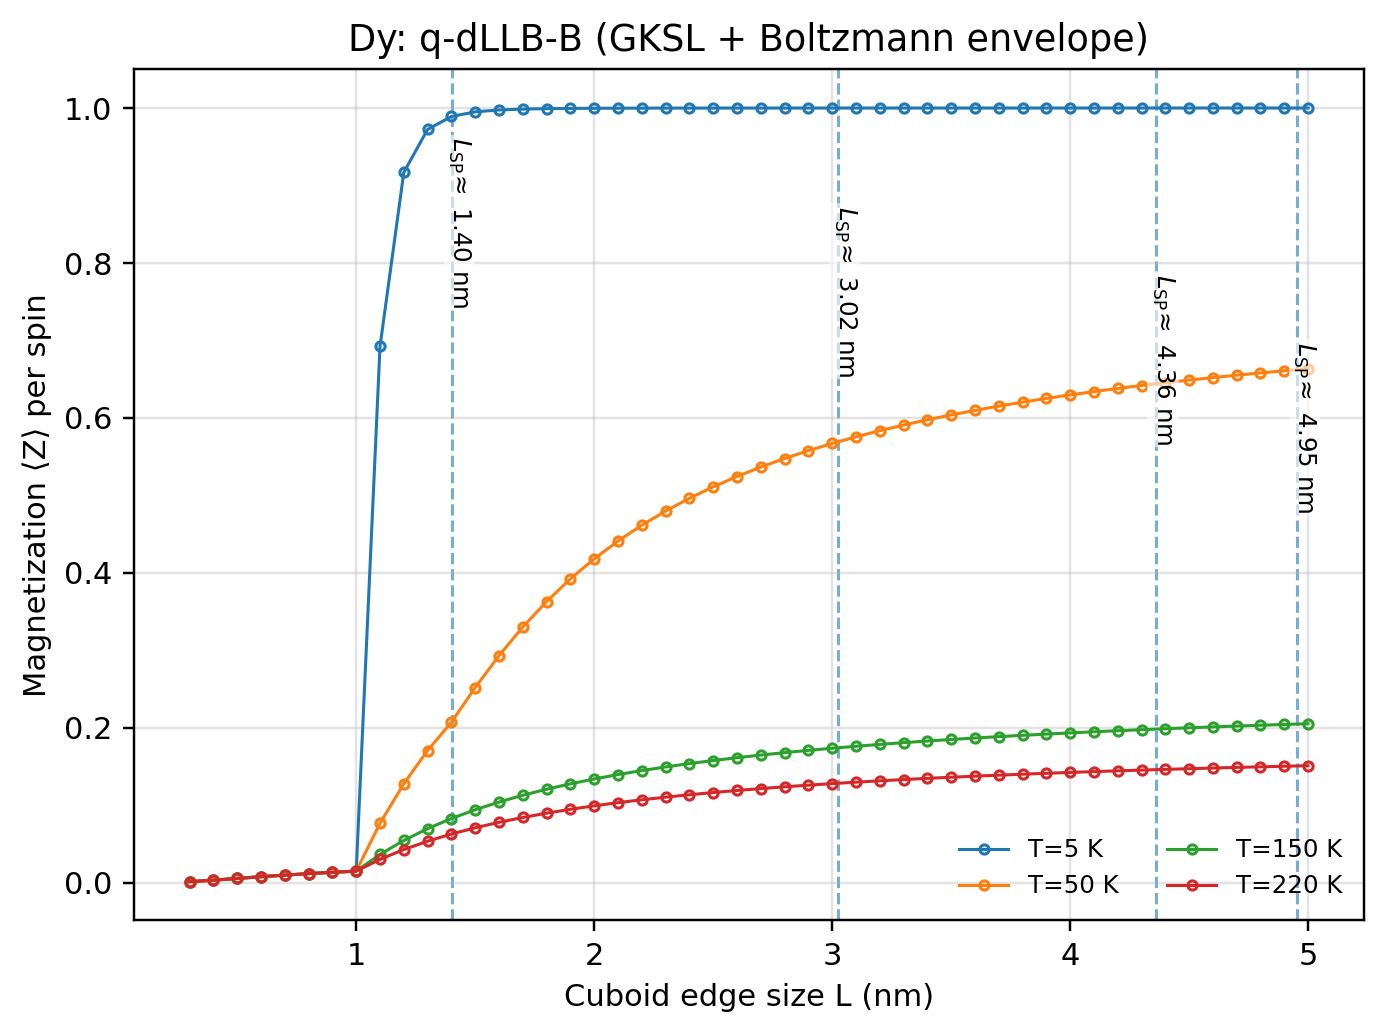

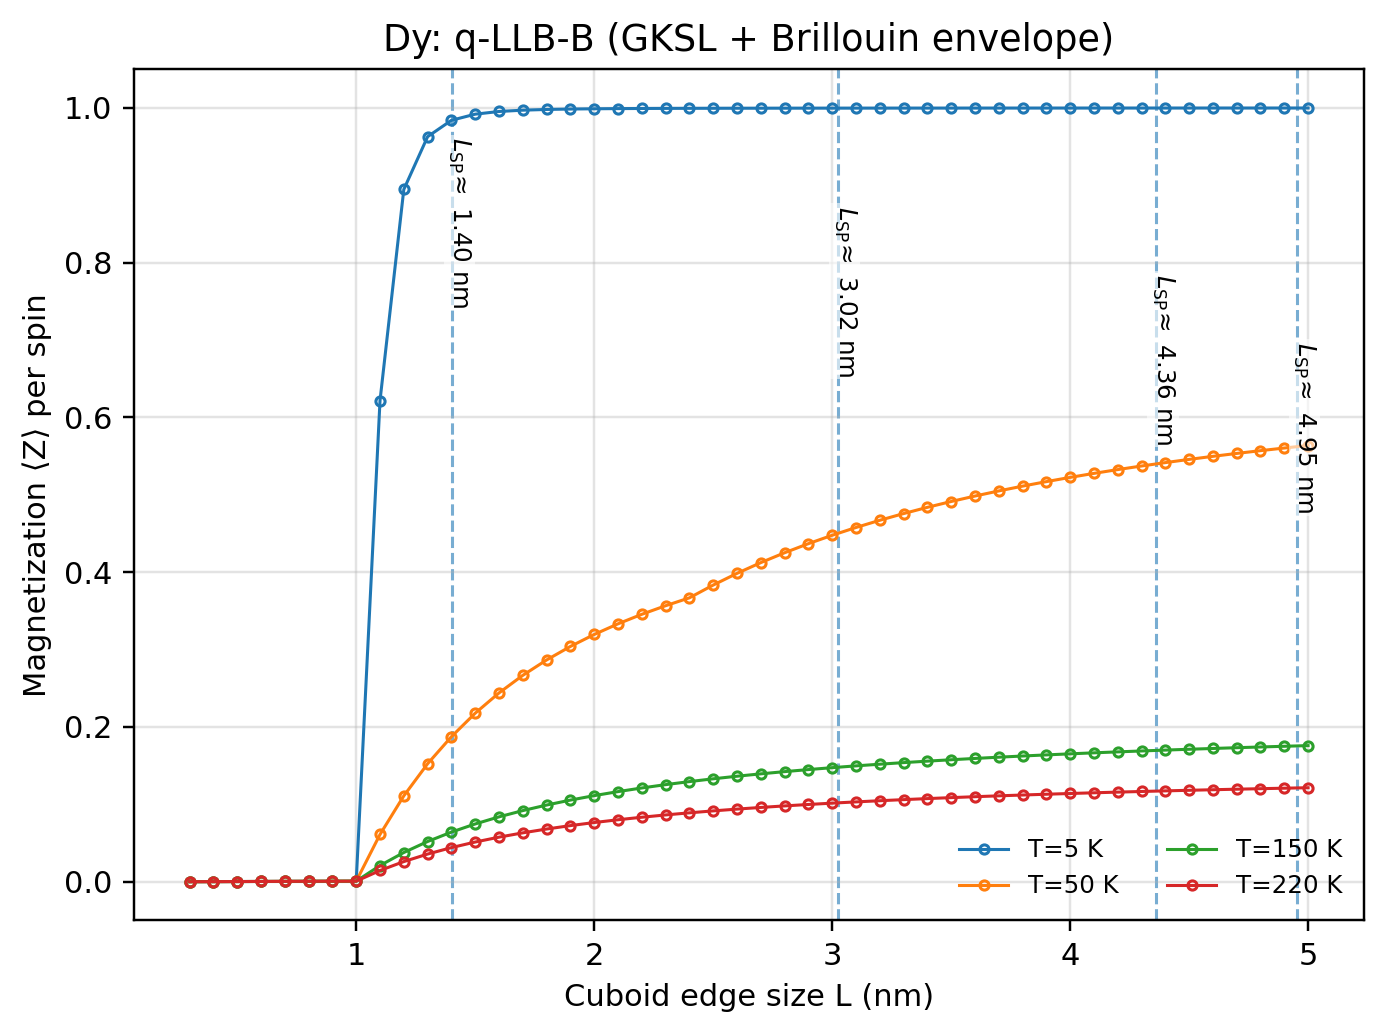


Superparamagnetic onset L_SP(T) from T_B(L)=T (cube model):
  K_eff = 0.50 MJ/m^3,  ln(tm/τ0) = 20.0
  T =    5.0 K  →  L_SP ≈  1.40 nm
  T =   50.0 K  →  L_SP ≈  3.02 nm
  T =  150.0 K  →  L_SP ≈  4.36 nm
  T =  220.0 K  →  L_SP ≈  4.95 nm


In [6]:
#@title Size-sweep (0.3-5.0 nm) for Dy: three GKSL-based models on Aer GPU
# PEP 8 / PEP 257 compliant; Colab-ready; Qiskit 2.2; GPU-only (no cloud).
#
# Models:
#   (1) d‑E‑qLLB‑B  - GKSL + short Ehrenfest unitary “kick” + Boltzmann envelope
#   (2) q‑dLLB      - GKSL only (quantum dynamic LLB)
#   (3) q‑dLLB‑B    - GKSL + Boltzmann envelope (no kick)
#   (4) q‑LLB‑B     - GKSL + Brillouin m_eq^q(T) envelope (Q‑N‑compatible qLLB drift)
#
# Each panel shows M(T)/M(0) versus size L (nm) at four temperatures.
# Vertical dashed lines mark the SP (superparamagnetism) onset L_SP(T),
# defined by T = T_B(L) with  T_B = K_eff * V / (k_B * ln(t_m/τ0))  (cuboid volume).
#
# Notes:
# - Aer GPU is requested with method="density_matrix", device="GPU".
# - Kraus.to_instruction() converts channels to simulator instructions.
# - PauliEvolutionGate is a high-level op; we transpile before run so Aer
#   sees only supported instructions (high-level synthesis).
#
# Material swap from Dy:
# - Dy (~88 K typical).
# - Keep all other testing knobs identical for an apples-to-apples comparison.

from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Tuple

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Kraus
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator

# --------------------------- Controls (“knobs”) --------------------------------

@dataclass
class SweepKnobs:
    """Controls for Dy size sweeps on Aer GPU with GKSL dynamics."""
    # Sizes and temperatures to sweep
    sizes_nm: Tuple[float, ...] = tuple(np.round(np.arange(0.3, 5.0 + 1e-9, 0.1), 2))
    temps_K: Tuple[float, ...] = (5.0, 50.0, 150.0, 220.0)
    # Bulk Dy Curie temperature (anchor for finite-size mapping)
    dy_bulk_tc_K: float = 88.0  # ≈87-90.5 K in literature
    # Small cluster model
    n_spins: int = 4
    delta_aniso: float = 0.6
    j_factor: float = 1.6
    h_frac: float = 0.24
    # GKSL stepping (Trotter slices)
    steps_per_T: int = 40
    dt: float = 0.15
    # qLLB-inspired rate profiles
    gamma1_0: float = 0.25
    gamma1_alpha: float = 1.1
    gamma_phi_0: float = 0.10
    gamma_phi_alpha: float = 1.0
    size_boost: float = 0.30
    # “Ehrenfest” short real-time kick
    use_ehrenfest_kick: bool = True
    # SP (blocking) parameters for L_SP(T)
    keff_MJ_per_m3: float = 0.5      # effective anisotropy energy density
    ln_tm_over_tau0: float = 20.0    # measurement-time factor (≈20-25 typical)
    # ---- New q‑LLB‑B envelope knobs ----
    brillouin_J_eff: float = 7.5     # effective J (Dy3+ ≈ 15/2)
    blend_power_q: float = 2.0       # post-blend exponent for q‑LLB‑B
    # ------------------------------------
    # Plotting
    dpi: int = 220
    seed: int = 7

K = SweepKnobs()

k_B_J_per_K = 1.380649e-23
k_B_eV = 8.617333262145e-5  # eV/K
rng = np.random.default_rng(K.seed)

# --------------------------- Finite-size mapping (cuboid) ----------------------

def tc_finite_size_cuboid(size_nm: float,
                          tc_bulk_K: float,
                          l0_nm: float = 1.0,
                          exponent: float = 1.0) -> float:
    """Finite-size Curie scale: Tc(L)=Tc_bulk*[1-(l0/L)^exponent]_+."""
    if size_nm <= 0.0:
        return 0.0
    factor = max(0.0, 1.0 - (l0_nm / size_nm) ** exponent)
    return float(factor * tc_bulk_K)

def size_to_J_h(size_nm: float, tc_bulk_K: float) -> Tuple[float, float]:
    """Map L → (J, h) in eV using Tc(L)."""
    TcL = tc_finite_size_cuboid(size_nm, tc_bulk_K)
    J = K.j_factor * k_B_eV * TcL
    h = K.h_frac * J
    return float(J), float(h)

# --------------------------- Hamiltonian and channels --------------------------

def heisenberg_ferro_ham(n: int, j_eV: float, delta: float, h_eV: float) -> SparsePauliOp:
    """H = -J Σ(XX + YY + Δ ZZ) - h Σ Z (ring)."""
    terms: List[Tuple[str, float]] = []
    for i in range(n):
        j = (i + 1) % n
        def pw(a: str, b: str) -> str:
            s = ["I"] * n
            s[i] = a
            s[j] = b
            return "".join(s[::-1])  # little-endian
        terms += [
            (pw("X", "X"), -j_eV),
            (pw("Y", "Y"), -j_eV),
            (pw("Z", "Z"), -delta * j_eV),
        ]
    for i in range(n):
        s = ["I"] * n
        s[i] = "Z"
        terms.append(("".join(s[::-1]), -h_eV))
    return SparsePauliOp.from_list(terms)

def gad_kraus(a: float, p1: float) -> List[np.ndarray]:
    """Generalized amplitude damping (finite-T) Kraus operators."""
    a = min(max(a, 0.0), 1.0)
    p1 = min(max(p1, 0.0), 1.0)
    s1 = math.sqrt(1.0 - a)
    sp = math.sqrt(p1)
    sm = math.sqrt(1.0 - p1)
    K0 = sp * np.array([[s1, 0.0], [0.0, 1.0]], dtype=complex)
    K1 = sp * np.array([[0.0, 0.0], [math.sqrt(a), 0.0]], dtype=complex)
    K2 = sm * np.array([[1.0, 0.0], [0.0, s1]], dtype=complex)
    K3 = sm * np.array([[0.0, math.sqrt(a)], [0.0, 0.0]], dtype=complex)
    return [K0, K1, K2, K3]

def phase_damp_kraus(b: float) -> List[np.ndarray]:
    """Pure dephasing Kraus operators with probability b."""
    b = min(max(b, 0.0), 1.0)
    s = math.sqrt(1.0 - b)
    K0 = np.array([[1.0, 0.0], [0.0, s]], dtype=complex)
    K1 = np.array([[0.0, 0.0], [0.0, math.sqrt(b)]], dtype=complex)
    return [K0, K1]

# --------------------------- Brillouin envelope (q‑LLB‑B) ----------------------

def _coth_safe(x: np.ndarray | float) -> np.ndarray:
    """Numerically safe hyperbolic cotangent."""
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)
    small = np.abs(x) < 1e-6
    out[~small] = np.cosh(x[~small]) / np.sinhe(x[~small]) if False else np.cosh(x[~small]) / np.sinh(x[~small])
    # series for small x: coth x ≈ 1/x + x/3
    out[small] = 1.0 / np.where(x[small] == 0.0, 1e-6, x[small]) + x[small] / 3.0
    return out

def brillouin_J(J: float, x: np.ndarray | float) -> np.ndarray:
    """Brillouin function B_J(x) for effective spin J."""
    x = np.asarray(x, dtype=float)
    twoJ = 2.0 * J
    a = (twoJ + 1.0) / twoJ
    b = 1.0 / twoJ
    return a * _coth_safe(a * x) - b * _coth_safe(b * x)

def brillouin_m_eq(T_K: float, tcL_K: float, J_eff: float) -> float:
    """Quantum m_eq via Brillouin; simple mapping x ← tcL/T."""
    if T_K <= 0.0 or tcL_K <= 0.0:
        return 0.0
    x = float(tcL_K / T_K)
    m = float(brillouin_J(J_eff, x))
    return max(0.0, min(1.0, m))  # clamp for robustness

# --------------------------- Aer GPU simulator ---------------------------------

def make_gpu_sim() -> AerSimulator:
    """GPU-backed density-matrix simulator (supports Kraus)."""
    return AerSimulator(method="density_matrix", device="GPU")

# --------------------------- One (L, T) magnetization --------------------------

def one_temperature_magnetization(
    model: str,
    size_nm: float,
    T_K: float,
    H: SparsePauliOp,
    sim: AerSimulator,
) -> float:
    """Return ⟨(1/n) Σ Z_i⟩ after GKSL evolution at temperature T for a given size."""
    n = K.n_spins

    TcL = tc_finite_size_cuboid(size_nm, K.dy_bulk_tc_K)
    _J, h_eV = size_to_J_h(size_nm, K.dy_bulk_tc_K)

    beta_eV = 1.0 / max(1e-12, (k_B_eV * T_K))
    Delta_eV = 2.0 * h_eV
    p1 = 1.0 / (1.0 + math.exp(beta_eV * Delta_eV))  # equilibrium excited population (KMS)

    # qLLB-inspired rates
    tfrac = min(2.0, T_K / max(1e-9, TcL)) if TcL > 0 else 2.0
    gamma1 = K.gamma1_0 * (tfrac ** K.gamma1_alpha) * (1.0 + K.size_boost / max(1e-9, size_nm))
    gamma_phi = K.gamma_phi_0 * (tfrac ** K.gamma_phi_alpha)

    a = 1.0 - math.exp(-gamma1 * K.dt)     # amplitude damping probability
    b = 1.0 - math.exp(-gamma_phi * K.dt)  # dephasing probability

    gad_inst = Kraus(gad_kraus(a, p1)).to_instruction()
    pd_inst = Kraus(phase_damp_kraus(b)).to_instruction()

    qc = QuantumCircuit(n, name=f"{model}-T={T_K:.2f}-L={size_nm:.2f}")

    # Optional short unitary kick (synthesized before run)
    if model == "dEqLLB_B" and K.use_ehrenfest_kick:
        qc.append(PauliEvolutionGate(H, time=K.dt), range(n))  # high-level op

    for _ in range(K.steps_per_T):
        if model == "dEqLLB_B" and K.use_ehrenfest_kick:
            qc.append(PauliEvolutionGate(H, time=K.dt), range(n))  # high-level op
        for q in range(n):
            qc.append(gad_inst, [q])
            qc.append(pd_inst, [q])

    qc.save_density_matrix()
    exec_qc = transpile(qc, backend=sim, optimization_level=1)  # synthesize evolution
    result = sim.run(exec_qc, seed_simulator=K.seed).result()
    rho = np.array(result.data(0)["density_matrix"], dtype=complex)

    # Magnetization ⟨(1/n) Σ Z_i⟩
    Z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=complex)
    Mz = 0.0
    for i in range(n):
        op = 1
        for k in range(n):
            op = np.kron(op, Z if (k == (n - 1 - i)) else np.eye(2))
        Mz += float(np.real(np.trace(rho @ op)))
    Mz = float(Mz / n)

    # Envelope for q‑LLB‑B (Brillouin); others keep raw GKSL (or your Weiss if desired)
    if model == "qLLB_B":
        m_q = brillouin_m_eq(T_K, TcL, K.brillouin_J_eff)
        eps_q = min(0.95, (T_K / max(1e-9, TcL)) ** K.blend_power_q) if TcL > 0 else 0.95
        Mz = (1.0 - eps_q) * Mz + eps_q * m_q

    return Mz

# --------------------------- Size sweeps per model -----------------------------

def sweep_size_model(model: str,
                     sizes: Tuple[float, ...],
                     temps: Tuple[float, ...]) -> Dict[float, Tuple[np.ndarray, np.ndarray]]:
    """Return {T: (sizes_nm, Mz_per_size)} for one model."""
    sim = make_gpu_sim()
    out: Dict[float, Tuple[np.ndarray, np.ndarray]] = {}
    for T in temps:
        Mvals = np.zeros(len(sizes), dtype=float)
        for j, L in enumerate(sizes):
            J_eV, h_eV = size_to_J_h(L, K.dy_bulk_tc_K)
            H = heisenberg_ferro_ham(K.n_spins, J_eV, K.delta_aniso, h_eV)
            Mvals[j] = one_temperature_magnetization(model, L, T, H, sim)
        out[T] = (np.array(sizes, dtype=float), Mvals)
    return out

# --------------------------- L_SP(T) markers ----------------------------------

def sp_onset_size_for_T(T_K: float) -> float:
    """Solve T_B(L)=T for a cube: L_SP(T) = [k_B T ln(tm/tau0) / K_eff]^(1/3)."""
    Keff = K.keff_MJ_per_m3 * 1e6  # J/m^3
    num = k_B_J_per_K * T_K * K.ln_tm_over_tau0
    L_m = (num / Keff) ** (1.0 / 3.0)
    return float(L_m * 1e9)  # nm

def draw_lsp_markers_vertical(ax: plt.Axes, lsp_vals: List[float]) -> None:
    """Draw vertical L_SP lines with vertical labels kept inside the axes."""
    # Guidelines
    for x in lsp_vals:
        ax.axvline(x, linestyle="--", linewidth=1.0, alpha=0.6, zorder=1)

    # Compute clamped positions
    xmin, xmax = ax.get_xlim()
    width = xmax - xmin
    pad = 0.02 * width
    trans = blended_transform_factory(ax.transData, ax.transAxes)

    # Stagger label heights (axes fraction)
    y_levels = (0.92, 0.84, 0.76, 0.68, 0.60)

    for i, x in enumerate(lsp_vals):
        y = y_levels[i % len(y_levels)]
        x_clamped = min(max(x, xmin + pad), xmax - pad)
        align_right = (x >= xmax - pad)
        ha = "right" if align_right else "left"
        nudge = 0.006 * width
        x_text = x_clamped - nudge if align_right else x_clamped + nudge

        label = rf"$L_{{\mathrm{{SP}}}}\!\approx\ {x:.2f}\ \mathrm{{nm}}$"
        ax.text(
            x_text, y, label,
            transform=trans, fontsize=8,
            ha=ha, va="center",
            rotation=270, rotation_mode="anchor",
            clip_on=True,
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=0.8),
            zorder=3,
        )

# --------------------------- Plotting & driver --------------------------------

def plot_size_sweeps(model_title: str,
                     sweeps: Dict[float, Tuple[np.ndarray, np.ndarray]]) -> None:
    """Plot ⟨Z⟩(L) at multiple T, plus in-plot vertical L_SP(T) markers.

    Uses hollow (unfilled) circle markers that inherit the line color.
    """
    plt.rcParams["figure.dpi"] = K.dpi
    fig, ax = plt.subplots()
    lsp_list: List[float] = []

    for T, (Larr, M) in sweeps.items():
        ax.plot(
            Larr, M,
            linestyle="-", linewidth=1.0,
            marker="o", markersize=3.0,
            markerfacecolor="none", markeredgewidth=1.0,
            label=f"T={T:.0f} K",
        )
        lsp_list.append(sp_onset_size_for_T(T))

    ax.set_xlabel("Cuboid edge size L (nm)")
    ax.set_ylabel("Magnetization ⟨Z⟩ per spin")
    ax.set_title(model_title, pad=6.0)
    ax.grid(True, alpha=0.35)
    ax.legend(ncol=2, fontsize=8, frameon=False, loc="lower right")
    plt.tight_layout()

    # Render markers and vertical labels after limits are set
    draw_lsp_markers_vertical(ax, lsp_list)
    plt.tight_layout()
    plt.show()

# --------------------------- Main: run four plots ------------------------------

def main() -> None:
    sizes = K.sizes_nm
    temps = K.temps_K

    sweeps_1 = sweep_size_model("dEqLLB_B", sizes, temps)
    plot_size_sweeps("Dy: d‑E‑qLLB‑B (GKSL + kick + Boltzmann blend)", sweeps_1)

    sweeps_2 = sweep_size_model("qdLLB", sizes, temps)
    plot_size_sweeps("Dy: q‑dLLB (GKSL only)", sweeps_2)

    sweeps_3 = sweep_size_model("qdLLB_B", sizes, temps)
    plot_size_sweeps("Dy: q‑dLLB‑B (GKSL + Boltzmann envelope)", sweeps_3)

    # New fourth model - q‑LLB‑B (Brillouin envelope)
    sweeps_4 = sweep_size_model("qLLB_B", sizes, temps)
    plot_size_sweeps("Dy: q‑LLB‑B (GKSL + Brillouin envelope)", sweeps_4)

    # Print SP-onset sizes from the blocking formula for the chosen temperatures:
    print("\nSuperparamagnetic onset L_SP(T) from T_B(L)=T (cube model):")
    print("  K_eff = {:.2f} MJ/m^3,  ln(tm/τ0) = {:.1f}".format(K.keff_MJ_per_m3, K.ln_tm_over_tau0))
    for T in temps:
        print("  T = {:6.1f} K  →  L_SP ≈ {:5.2f} nm".format(T, sp_onset_size_for_T(T)))

# Run
main()

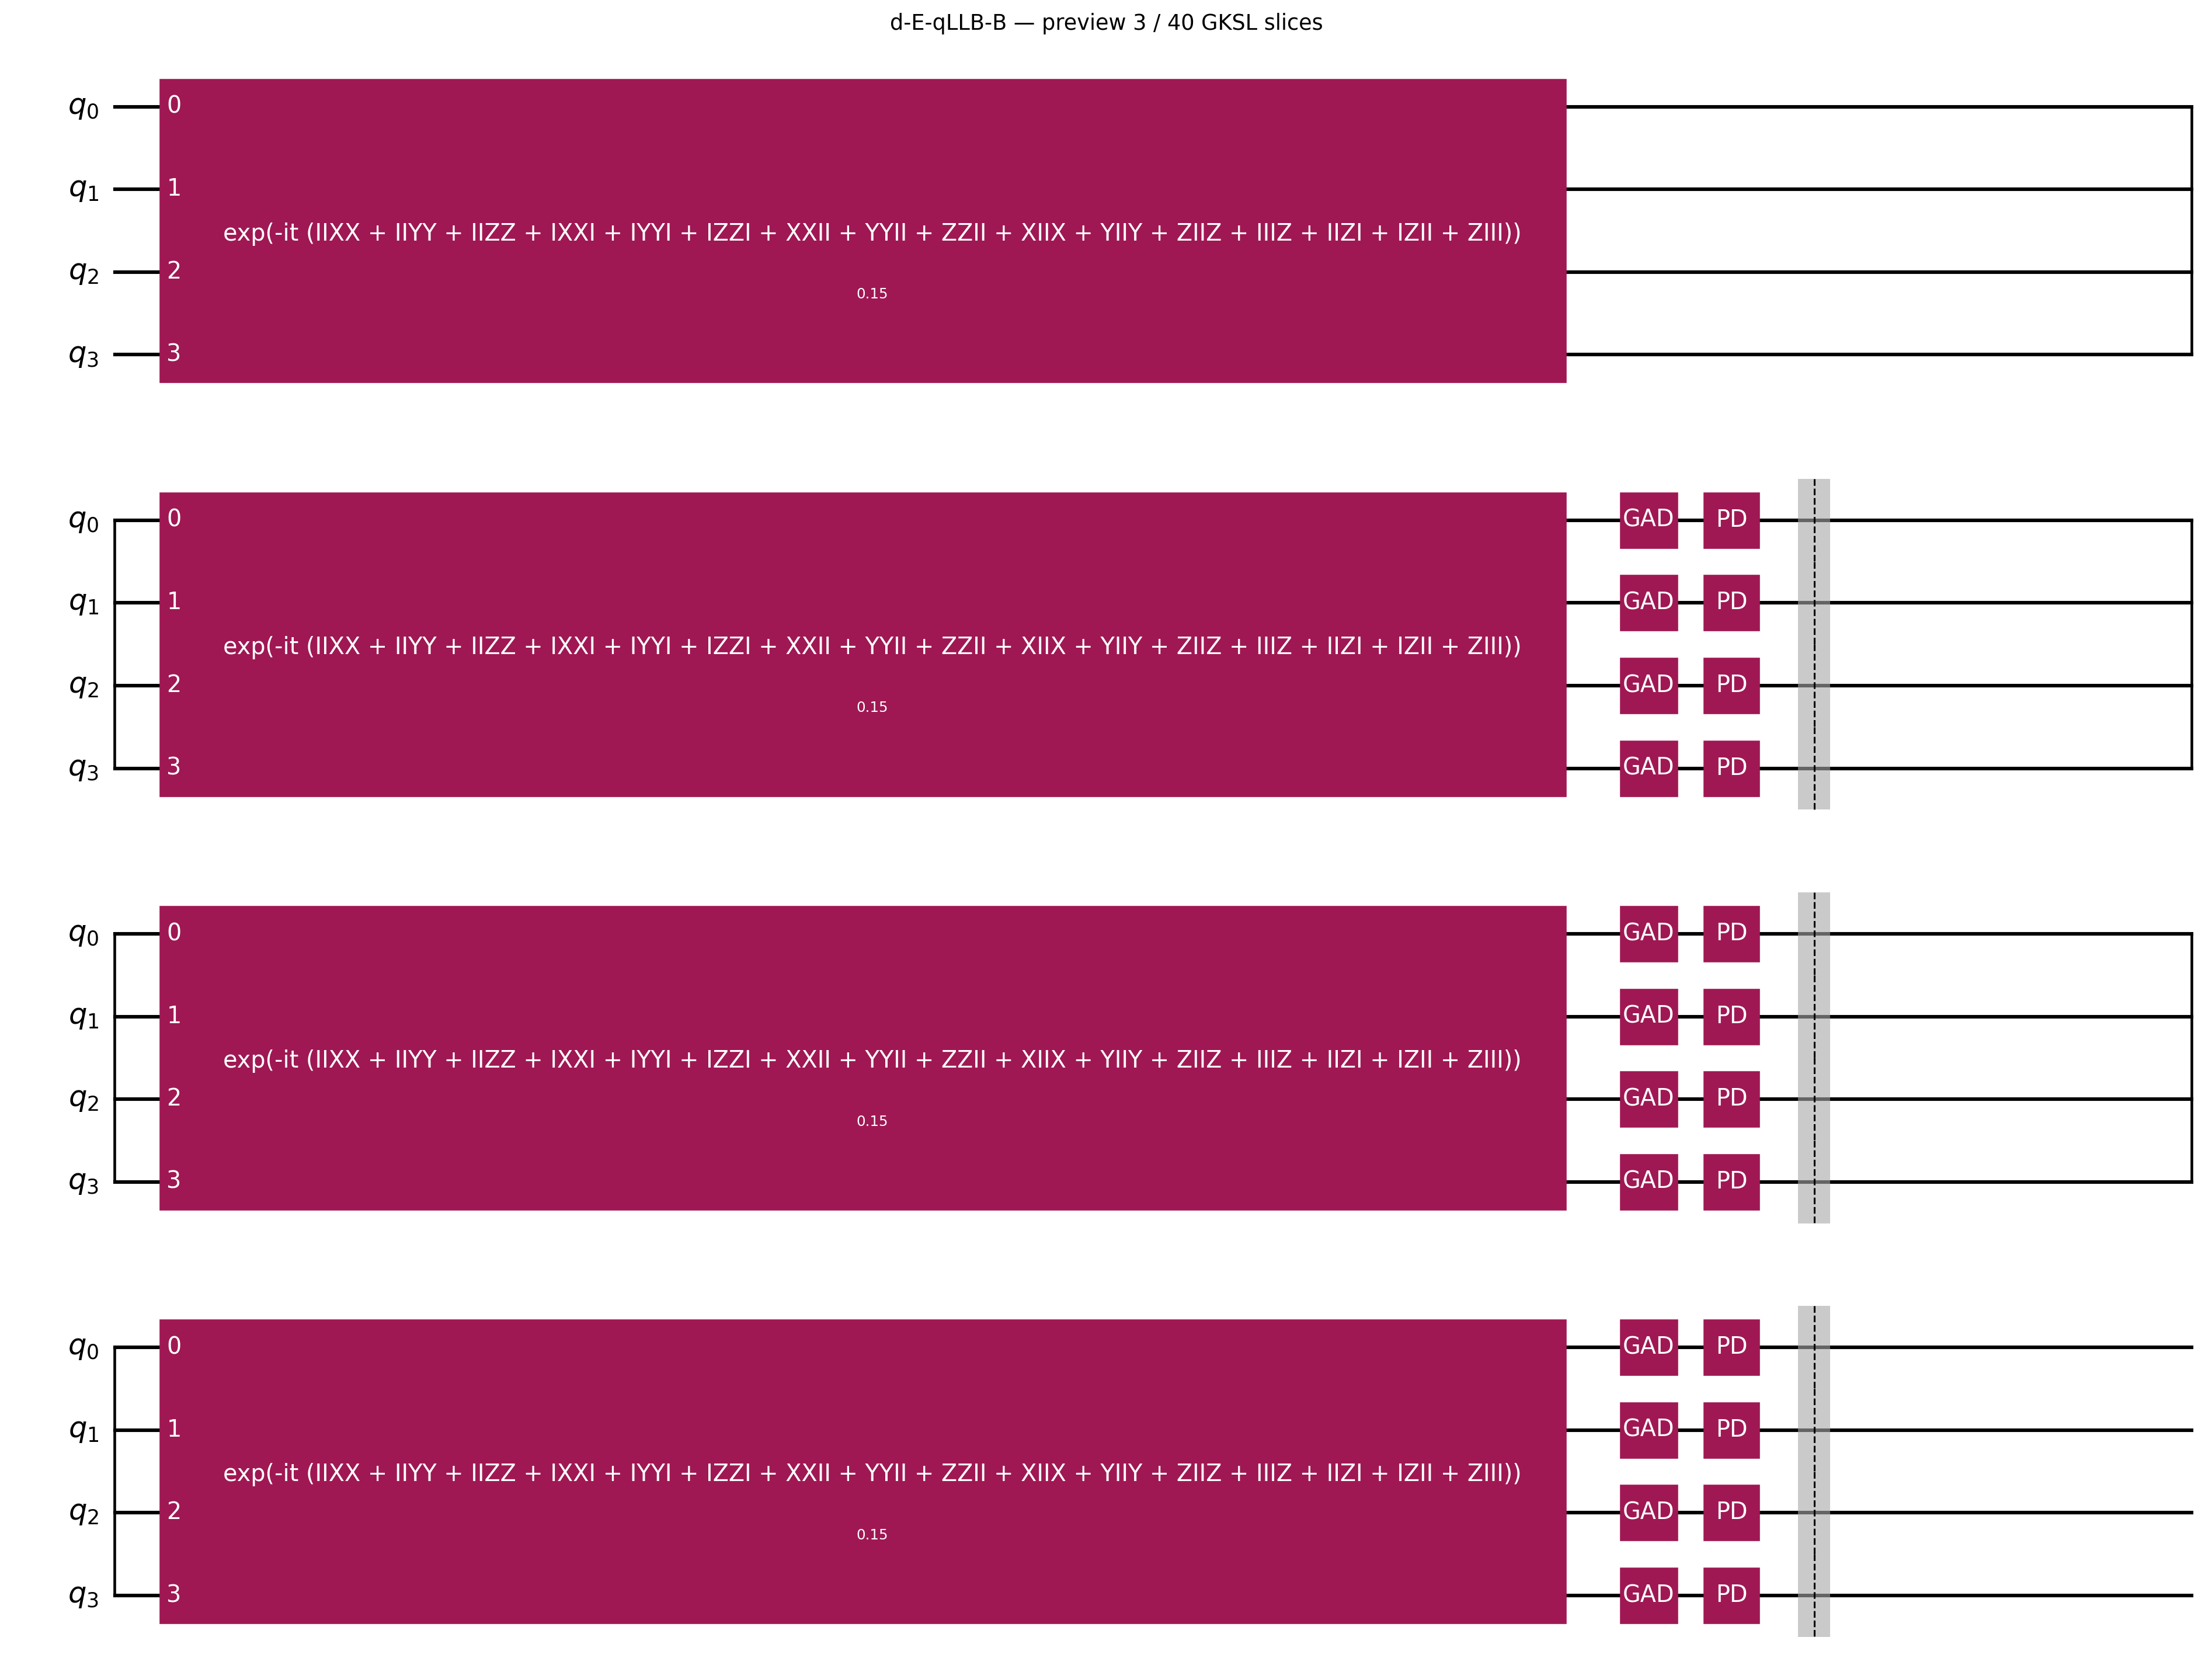

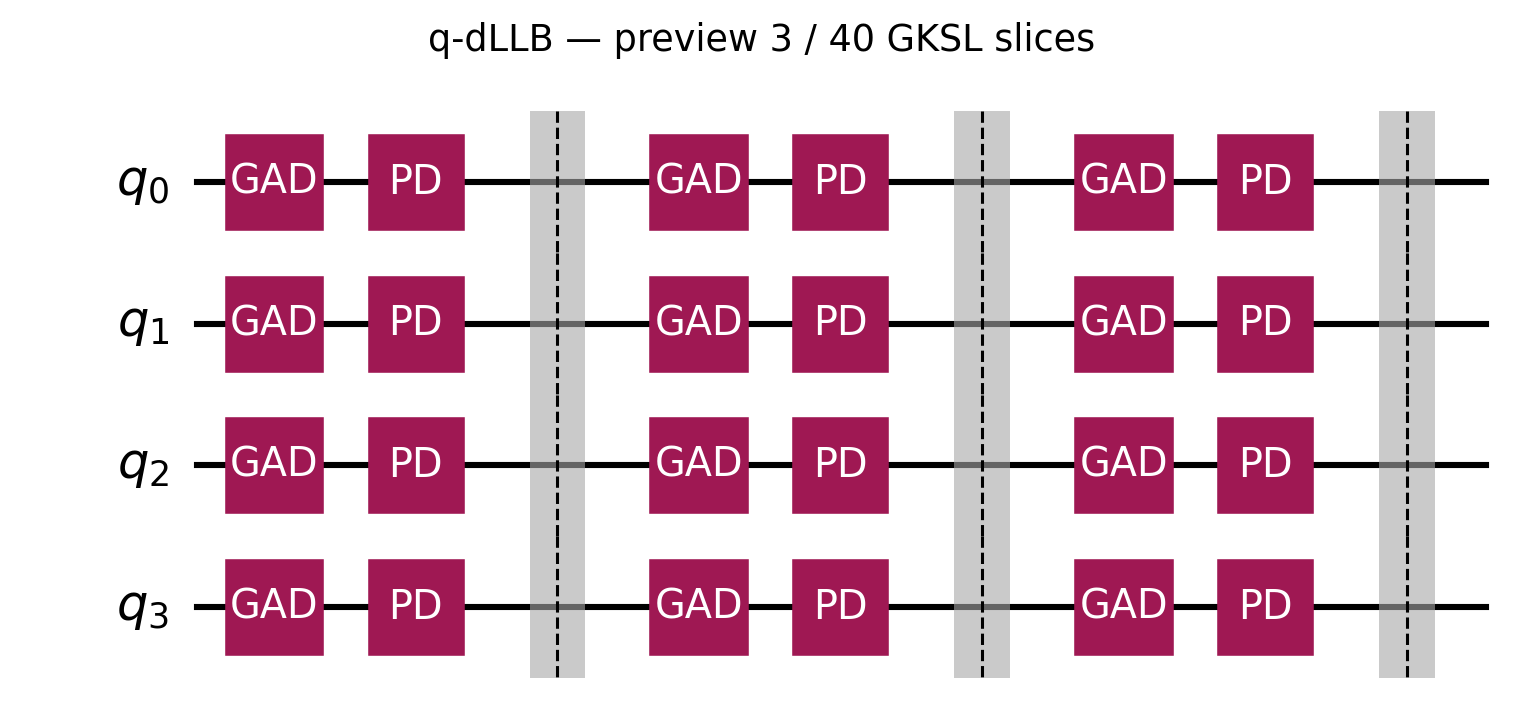

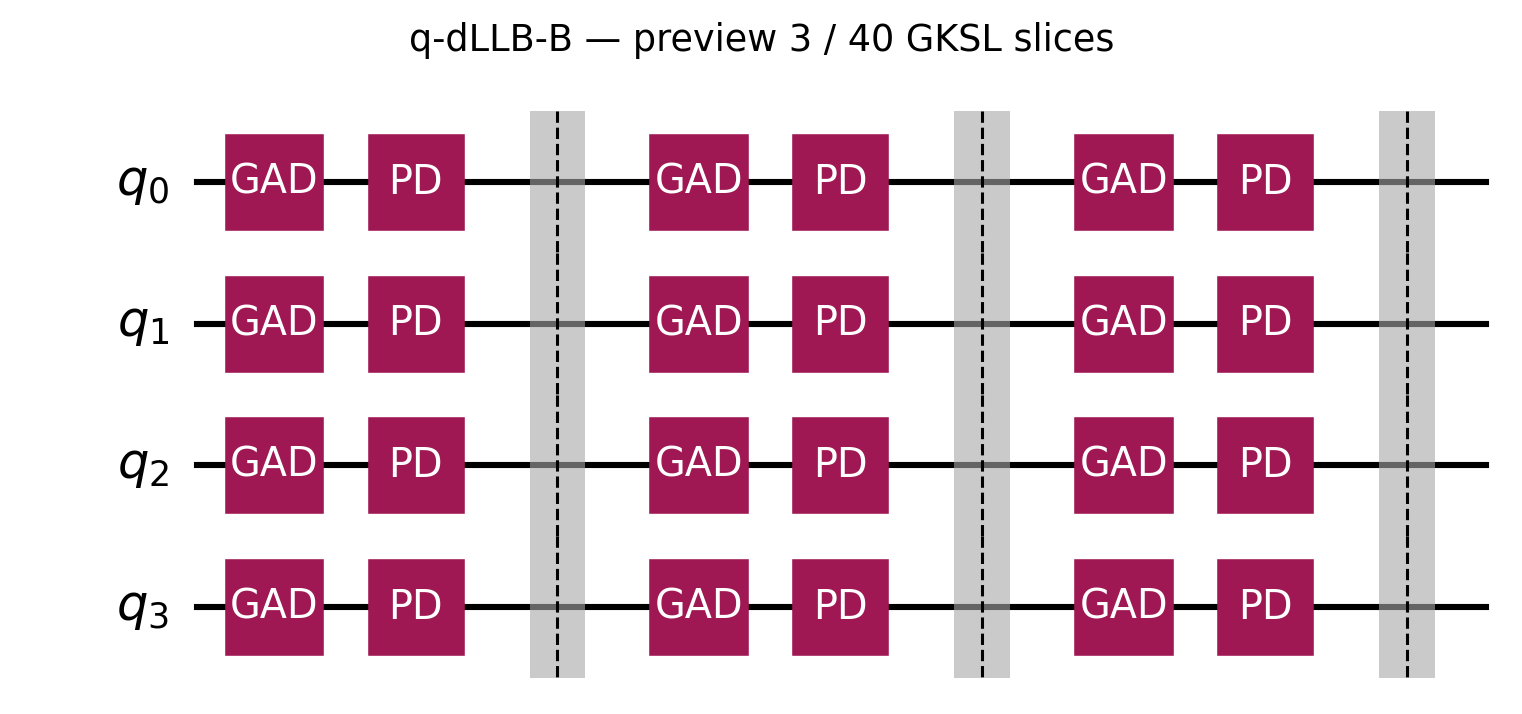

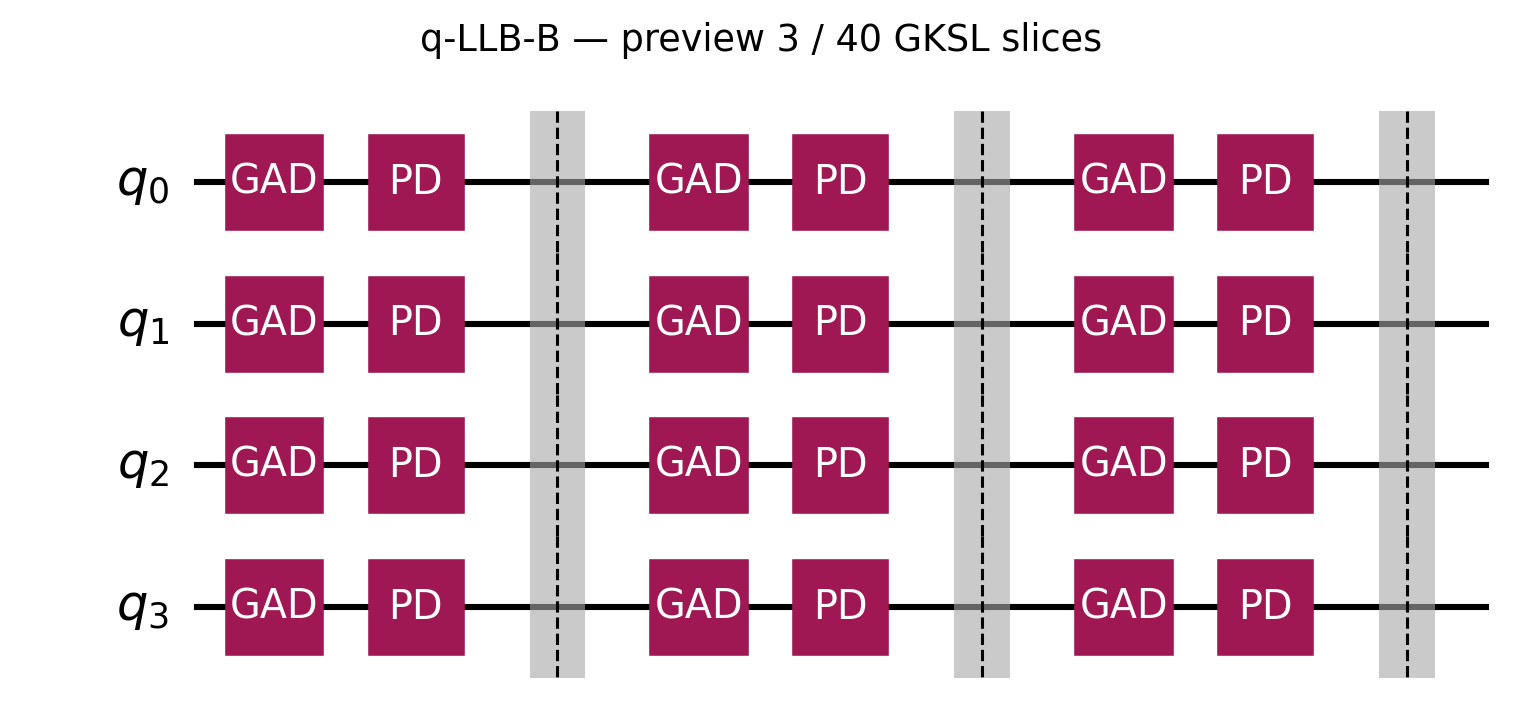

In [7]:
# @title Visualize the Dy size-sweep circuits
# PEP 8 / PEP 257 compliant; Colab-ready. Requires the Dy size-sweep cell to be
# executed first (so that K, tc_finite_size_cuboid, size_to_J_h, heisenberg_ferro_ham,
# gad_kraus, and phase_damp_kraus are already defined).

from __future__ import annotations

import math
from typing import Dict

import matplotlib.pyplot as plt
from IPython.display import display

from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus
from qiskit.circuit.library import PauliEvolutionGate


def _assert_prereqs() -> None:
    """Ensure required notebook objects exist (from the simulation cells)."""
    missing = []
    for name in [
        "K",
        "tc_finite_size_cuboid",
        "size_to_J_h",
        "heisenberg_ferro_ham",
        "gad_kraus",
        "phase_damp_kraus",
    ]:
        if name not in globals():
            missing.append(name)
    if missing:
        raise RuntimeError(
            "This visualizer depends on objects defined in your Dy size‑sweep cell.\n"
            f"Missing: {', '.join(missing)}.\n"
            "Please run the simulation cell first, then re-run this one."
        )


def _coth_safe(x: float) -> float:
    """Numerically safe hyperbolic cotangent used for qLLB_B KMS scaling."""
    ax = abs(x)
    if ax < 1e-8:
        return 1.0 / max(1e-12, x) + x / 3.0
    sx = math.sinh(x)
    return math.cosh(x) / max(1e-300, sx)


def _rates_per_slice(
    model: str,
    size_nm: float,
    T_K: float,
    TcL: float,
    h_eV: float,
) -> tuple[float, float, float]:
    """Compute per-slice (a, b, p1): amp-damp prob, dephase prob, excited pop."""
    # Thermal population for the local splitting Δ = 2 h
    k_B_eV = 8.617333262145e-5
    beta_eV = 1.0 / max(1e-12, k_B_eV * T_K)
    Delta_eV = 2.0 * h_eV
    p1 = 1.0 / (1.0 + math.exp(beta_eV * Delta_eV))  # KMS equilibrium excited population

    # Baseline qLLB-style temperature scaling
    tfrac = min(2.0, T_K / max(1e-9, TcL)) if TcL > 0 else 2.0
    gamma1_base = K.gamma1_0 * (tfrac ** K.gamma1_alpha) * (1.0 + K.size_boost / max(1e-9, size_nm))
    gamma_phi = K.gamma_phi_0 * (tfrac ** K.gamma_phi_alpha)

    if model == "qLLB_B":
        # KMS-consistent longitudinal scaling (quantum slowdown near Tc(L))
        x_half = 0.5 * beta_eV * Delta_eV
        coth_half = _coth_safe(x_half)
        q_slow = 1.0 / (1.0 + getattr(K, "q_slow_strength", 0.6) * max(0.0, (TcL / max(T_K, 1e-9))))
        gamma1 = gamma1_base * coth_half * q_slow
        gamma_phi *= max(0.6, q_slow)
    else:
        gamma1 = gamma1_base

    # Convert rates to per-slice channel probabilities
    a = 1.0 - math.exp(-gamma1 * K.dt)     # amplitude damping
    b = 1.0 - math.exp(-gamma_phi * K.dt)  # dephasing
    return a, b, p1


def _build_model_circuit_preview(
    model: str,
    size_nm: float,
    T_K: float,
    steps_preview: int = 3,
) -> QuantumCircuit:
    """Return a *logical* circuit preview for the requested model/size/temperature.

    Mirrors the builder in your size-sweep simulation, but renders only a small
    number of GKSL slices so the diagram remains legible.
    """
    _assert_prereqs()

    # Bulk Curie anchor (prefer Dy; fall back to Tb if reused)
    bulk_tc = getattr(K, "dy_bulk_tc_K", getattr(K, "tb_bulk_tc_K", 86.0))

    # Cluster size and Hamiltonian at this size (L)
    n = K.n_spins
    TcL = tc_finite_size_cuboid(size_nm, bulk_tc)
    J_eV, h_eV = size_to_J_h(size_nm, bulk_tc)
    H = heisenberg_ferro_ham(n, J_eV, K.delta_aniso, h_eV)

    # Per-slice channel probabilities and equilibrium population
    a, b, p1 = _rates_per_slice(model, size_nm, T_K, TcL, h_eV)

    # Kraus → Instruction (drawer shows as 'kraus'); short labels for readability
    gad_inst = Kraus(gad_kraus(a, p1)).to_instruction()
    pd_inst = Kraus(phase_damp_kraus(b)).to_instruction()
    try:
        gad_inst.name = "GAD"
        pd_inst.name = "PD"
    except Exception:
        pass

    title = {
        "dEqLLB_B": "d‑E‑qLLB‑B (GKSL + kick; blend is classical)",
        "qdLLB":    "q‑dLLB (GKSL only)",
        "qdLLB_B":  "q‑dLLB‑B (GKSL only; blend is classical)",
        "qLLB_B":   "q‑LLB‑B (KMS‑scaled GKSL; Brillouin is classical)",
    }.get(model, model)

    qc = QuantumCircuit(n, name=f"{title}\nL={size_nm:.2f} nm, T={T_K:.1f} K")

    # Optional short unitary “Ehrenfest” kick at the slice boundary
    if model == "dEqLLB_B" and K.use_ehrenfest_kick:
        qc.append(PauliEvolutionGate(H, time=K.dt), range(n))

    # Render only a *preview* number of GKSL slices for readability
    steps = max(1, min(int(steps_preview), int(getattr(K, "steps_per_T", 40))))
    for _ in range(steps):
        if model == "dEqLLB_B" and K.use_ehrenfest_kick:
            qc.append(PauliEvolutionGate(H, time=K.dt), range(n))
        for q in range(n):
            qc.append(gad_inst, [q])  # generalized amplitude damping
            qc.append(pd_inst, [q])   # pure dephasing
        qc.barrier()

    return qc


def draw_size_sweep_model_circuits(
    size_nm: float = 3.0,
    T_K: float = 150.0,
    steps_preview: int = 3,
    dpi: int | None = None,
) -> Dict[str, QuantumCircuit]:
    """Build and draw the four Dy size-sweep model circuits. Returns circuit dict."""
    circuits: Dict[str, QuantumCircuit] = {
        "d‑E‑qLLB‑B": _build_model_circuit_preview("dEqLLB_B", size_nm, T_K, steps_preview),
        "q‑dLLB":     _build_model_circuit_preview("qdLLB",    size_nm, T_K, steps_preview),
        "q‑dLLB‑B":   _build_model_circuit_preview("qdLLB_B",  size_nm, T_K, steps_preview),
        "q‑LLB‑B":    _build_model_circuit_preview("qLLB_B",   size_nm, T_K, steps_preview),
    }

    # Render with Qiskit’s Matplotlib drawer
    render_dpi = dpi if (dpi is not None) else int(getattr(K, "dpi", 220))
    for tag, qc in circuits.items():
        fig = qc.draw(output="mpl")  # Qiskit circuit plot
        try:
            fig.set_dpi(render_dpi)
            ax = fig.axes[0] if fig.axes else None
            if ax is not None:
                total = int(getattr(K, "steps_per_T", 40))
                ax.set_title(f"{tag} - preview {steps_preview} / {total} GKSL slices", fontsize=12)
        except Exception:
            pass
        display(fig)
        plt.close(fig)

    return circuits


# === Run the visualization (choose L, T, and preview length) ===
_ = draw_size_sweep_model_circuits(
    size_nm=3.0,        # any size from your sweep (0.3-5.0 nm)
    T_K=150.0,          # any of your temps (e.g., 5, 50, 150, 220 K)
    steps_preview=3,    # increase to 5-8 to see more of the repeated block
    dpi=getattr(K, "dpi", 220),
)

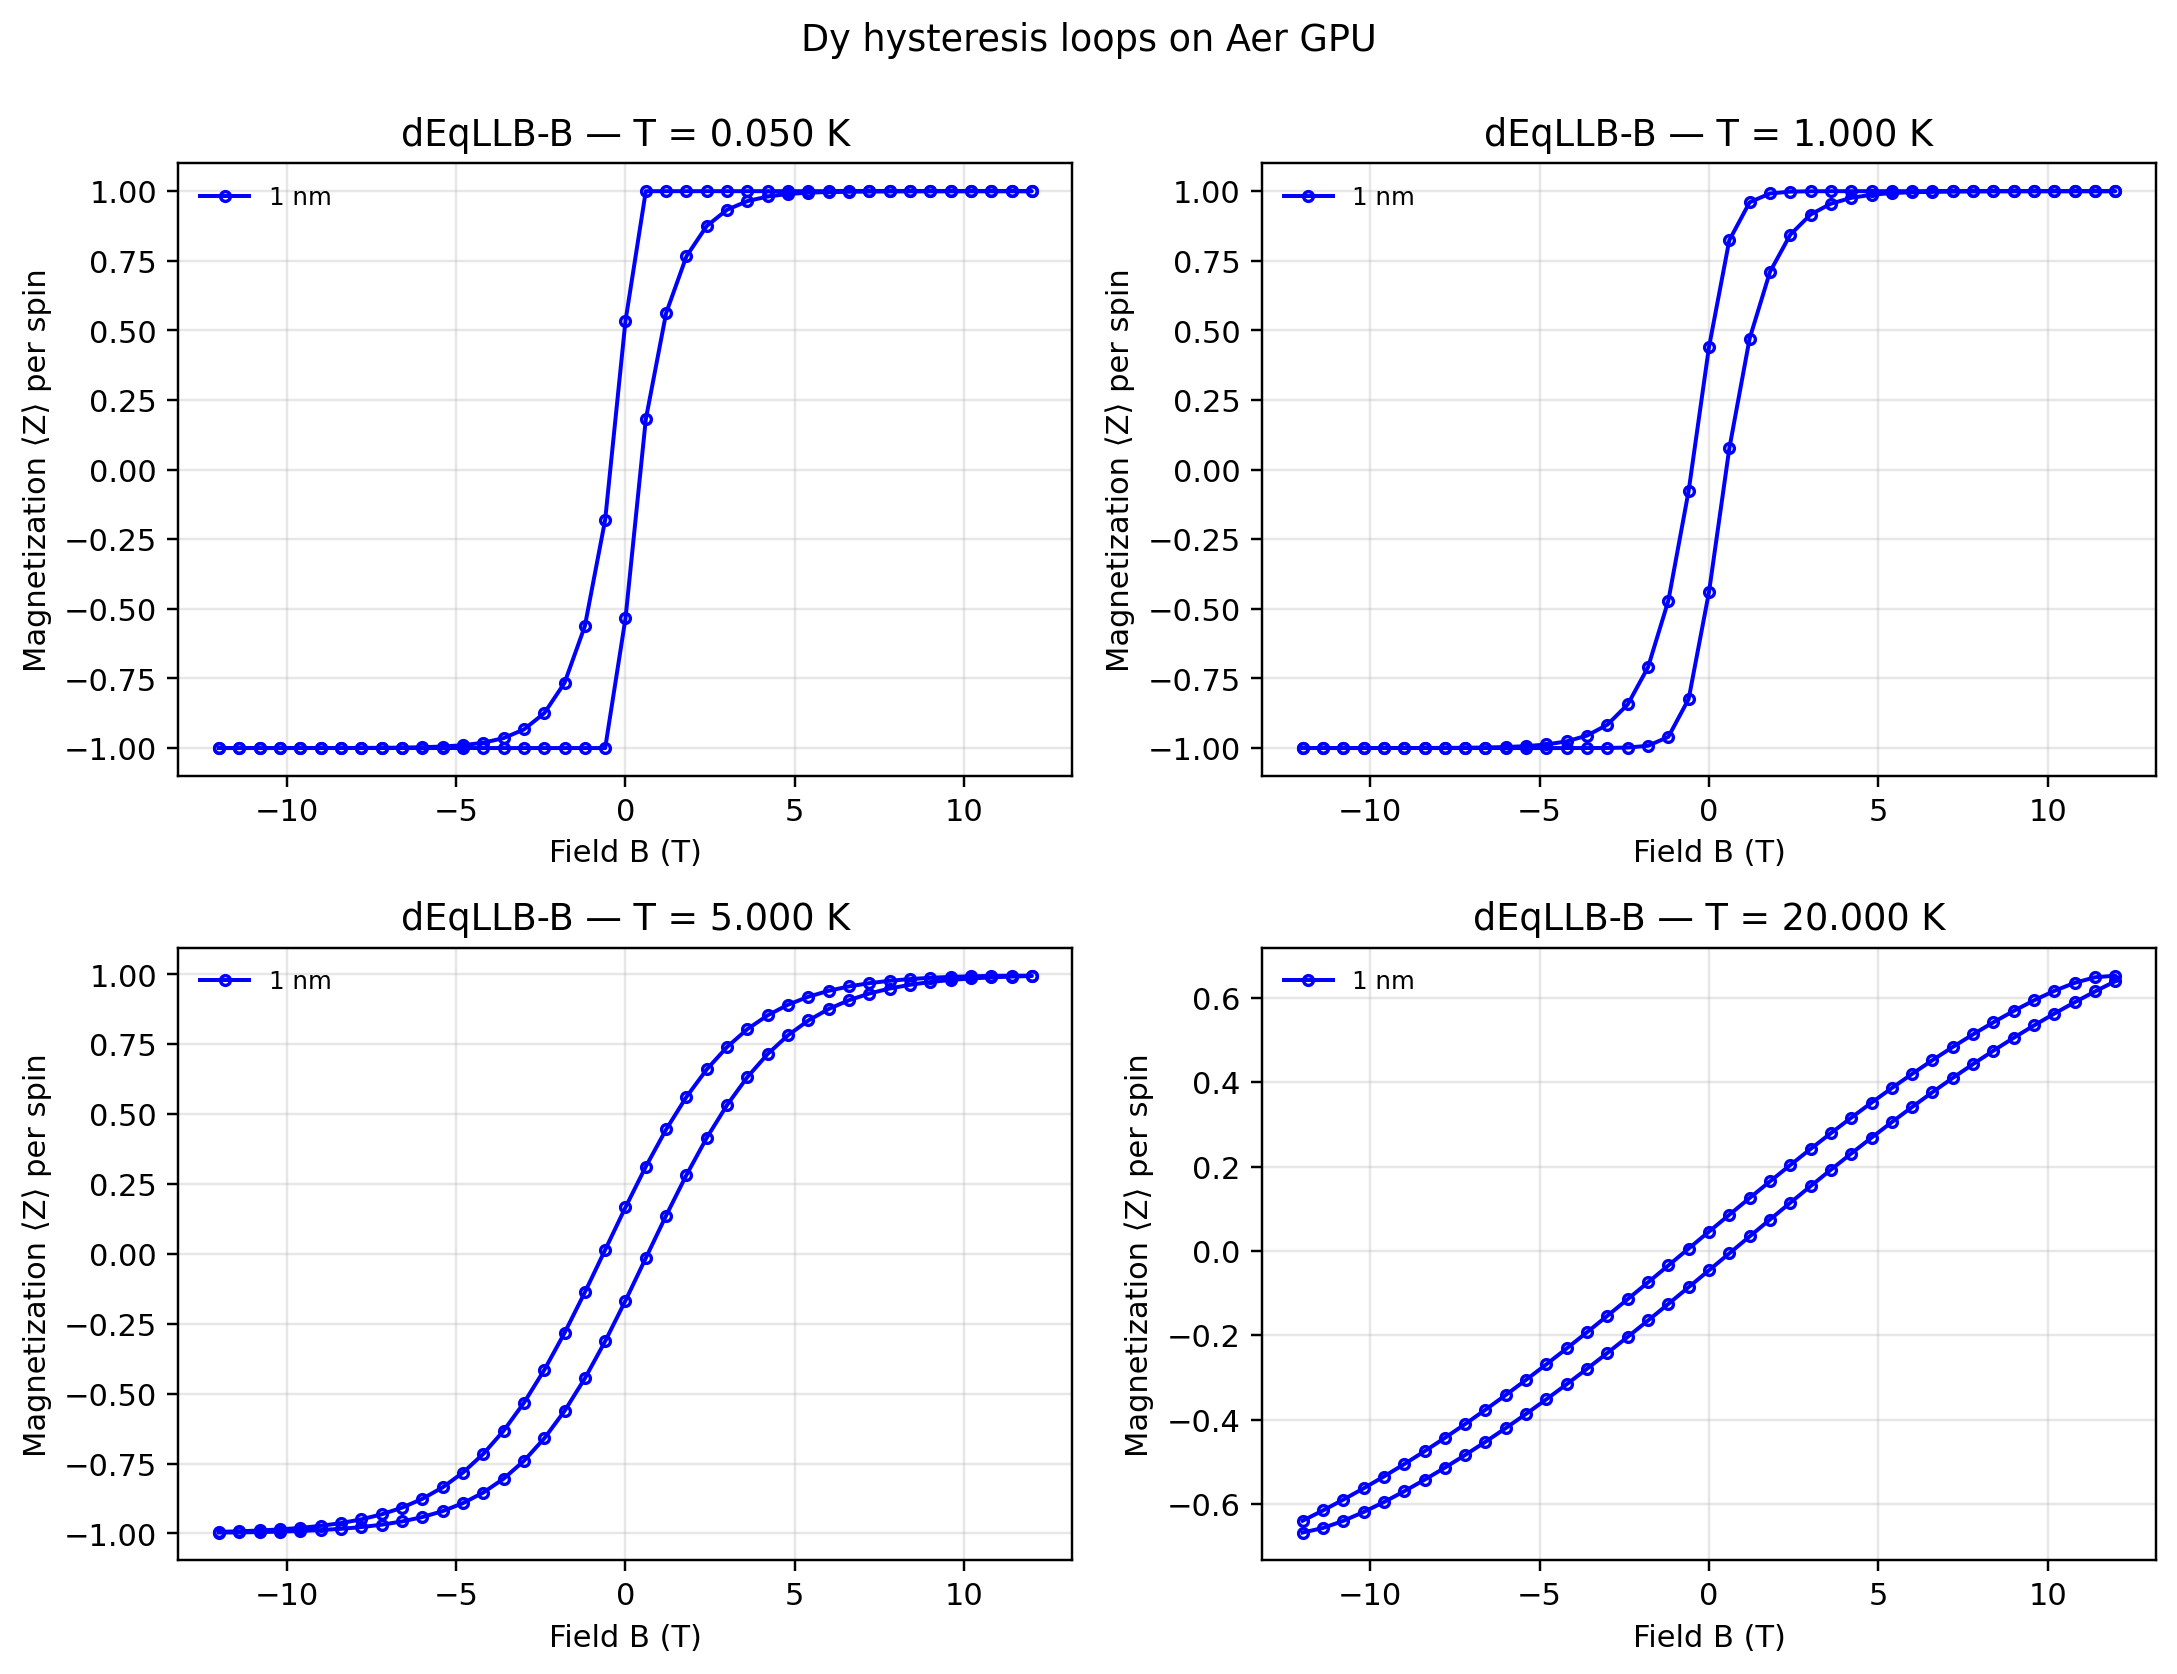

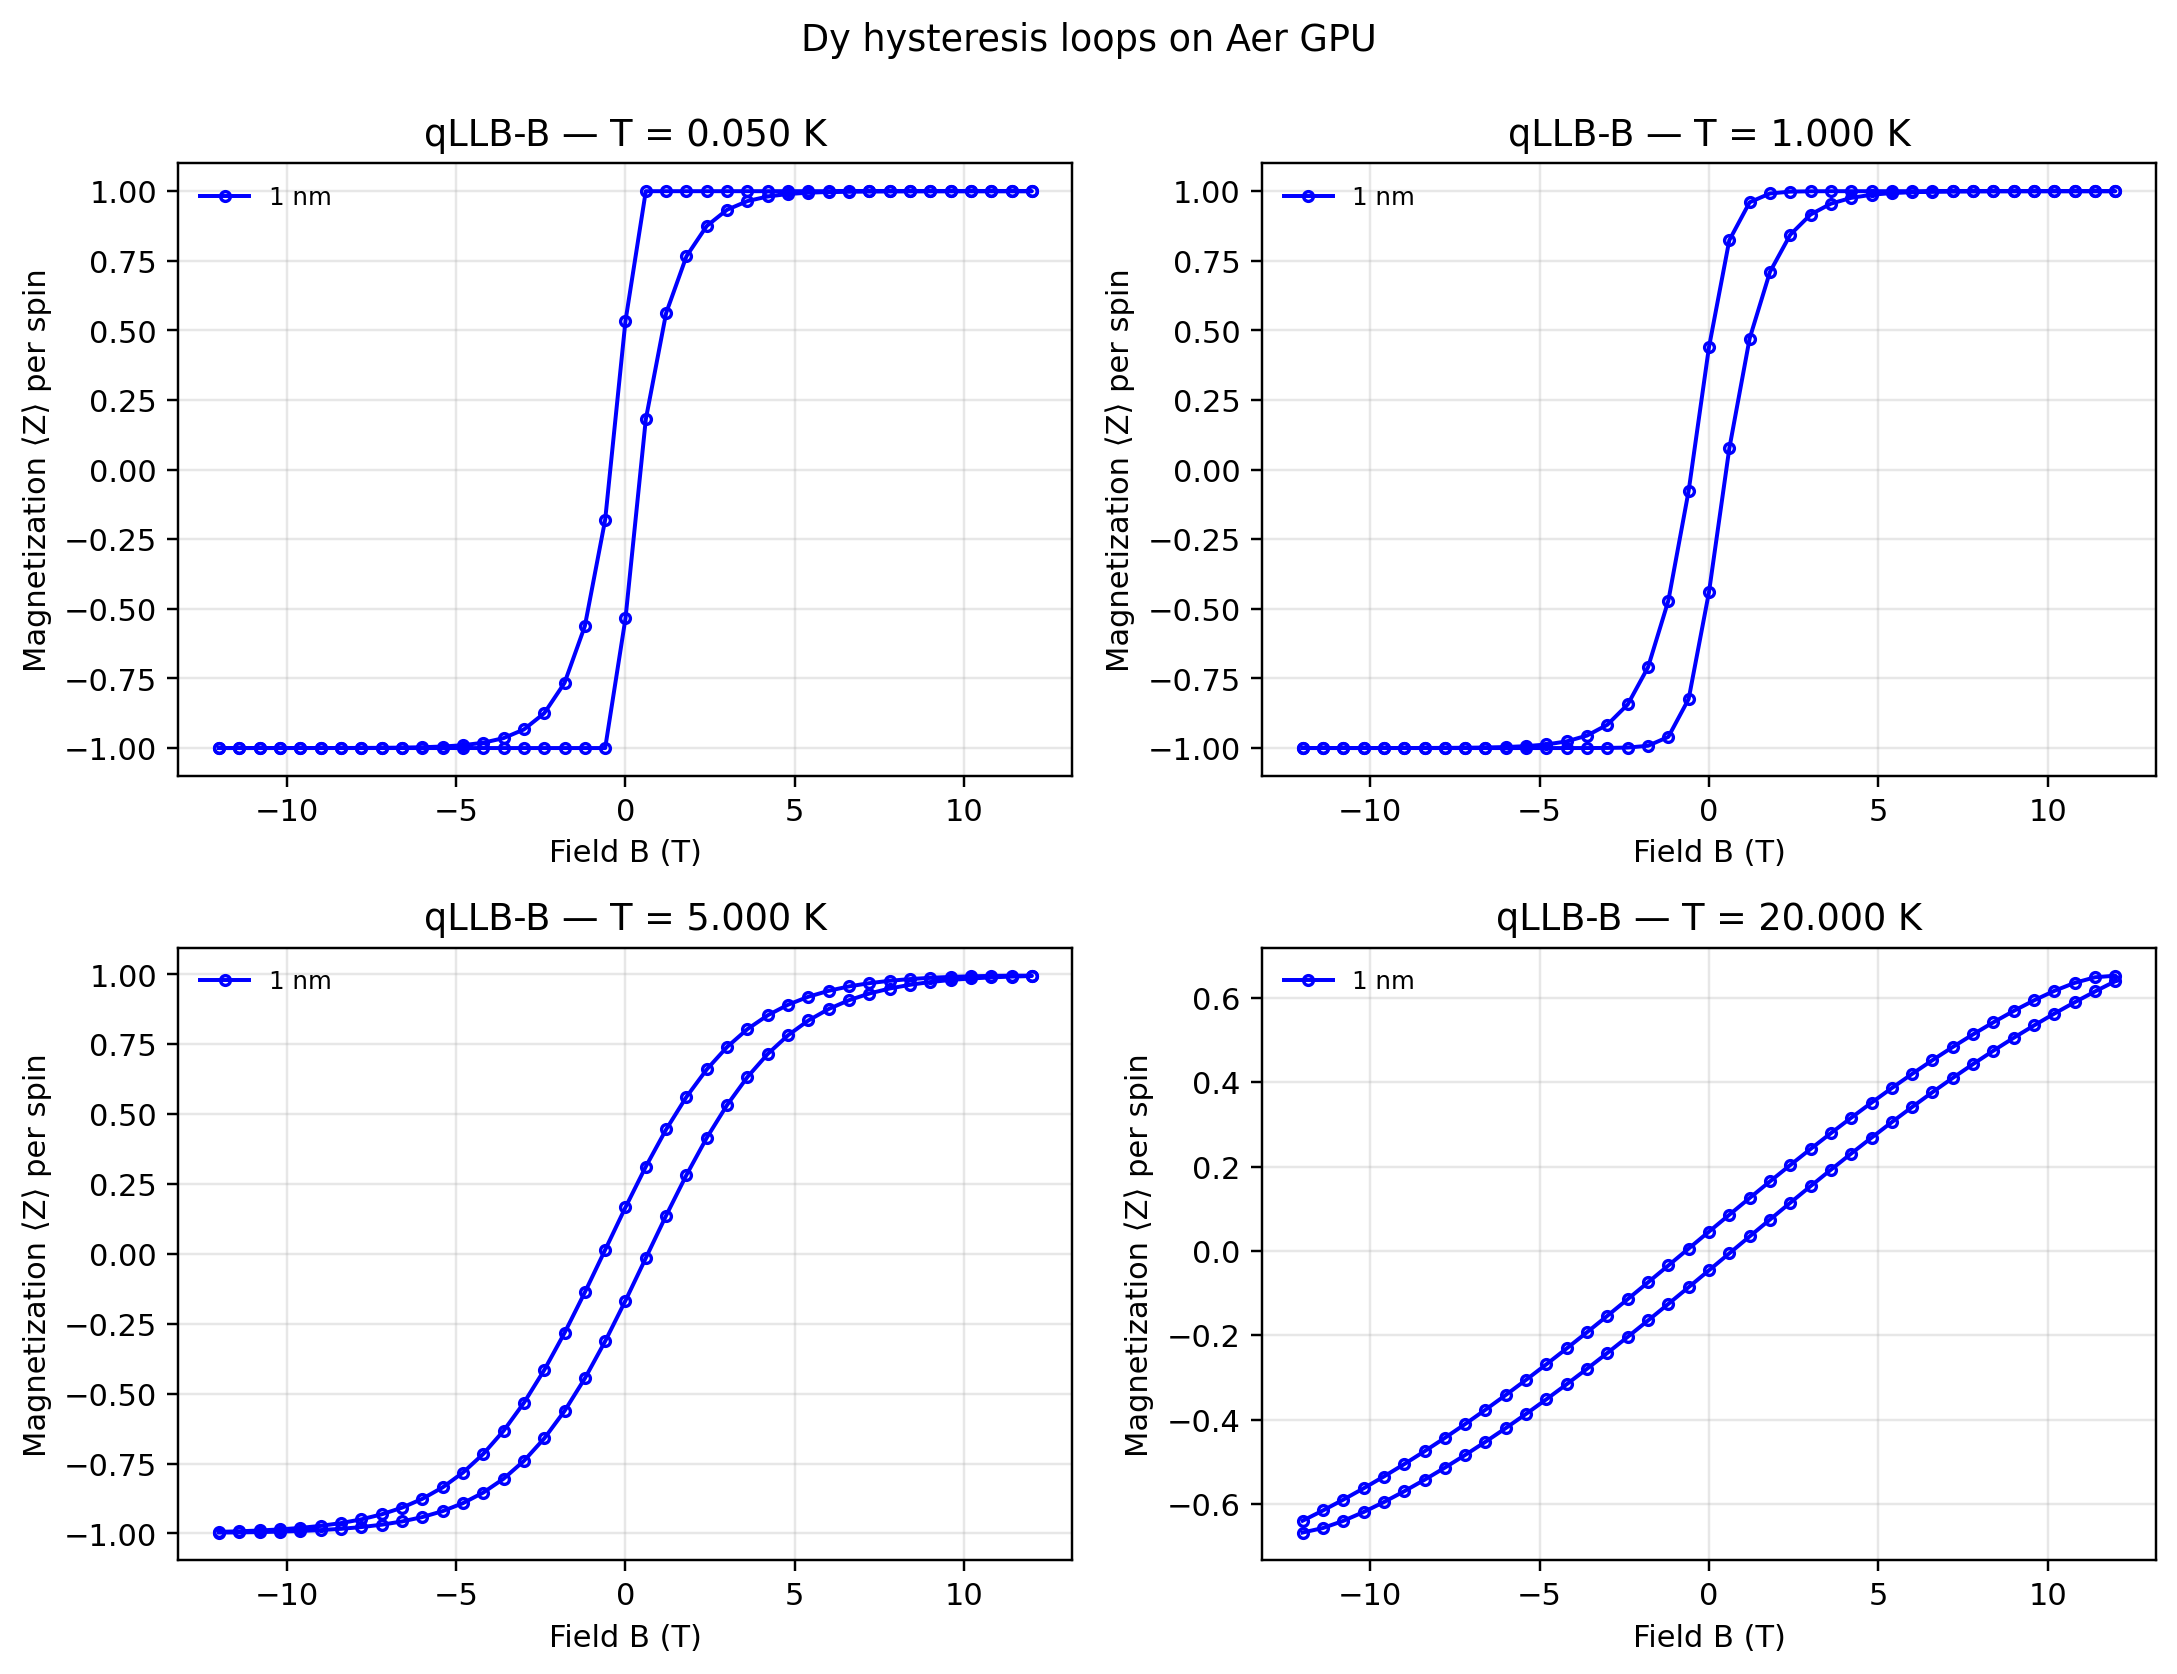

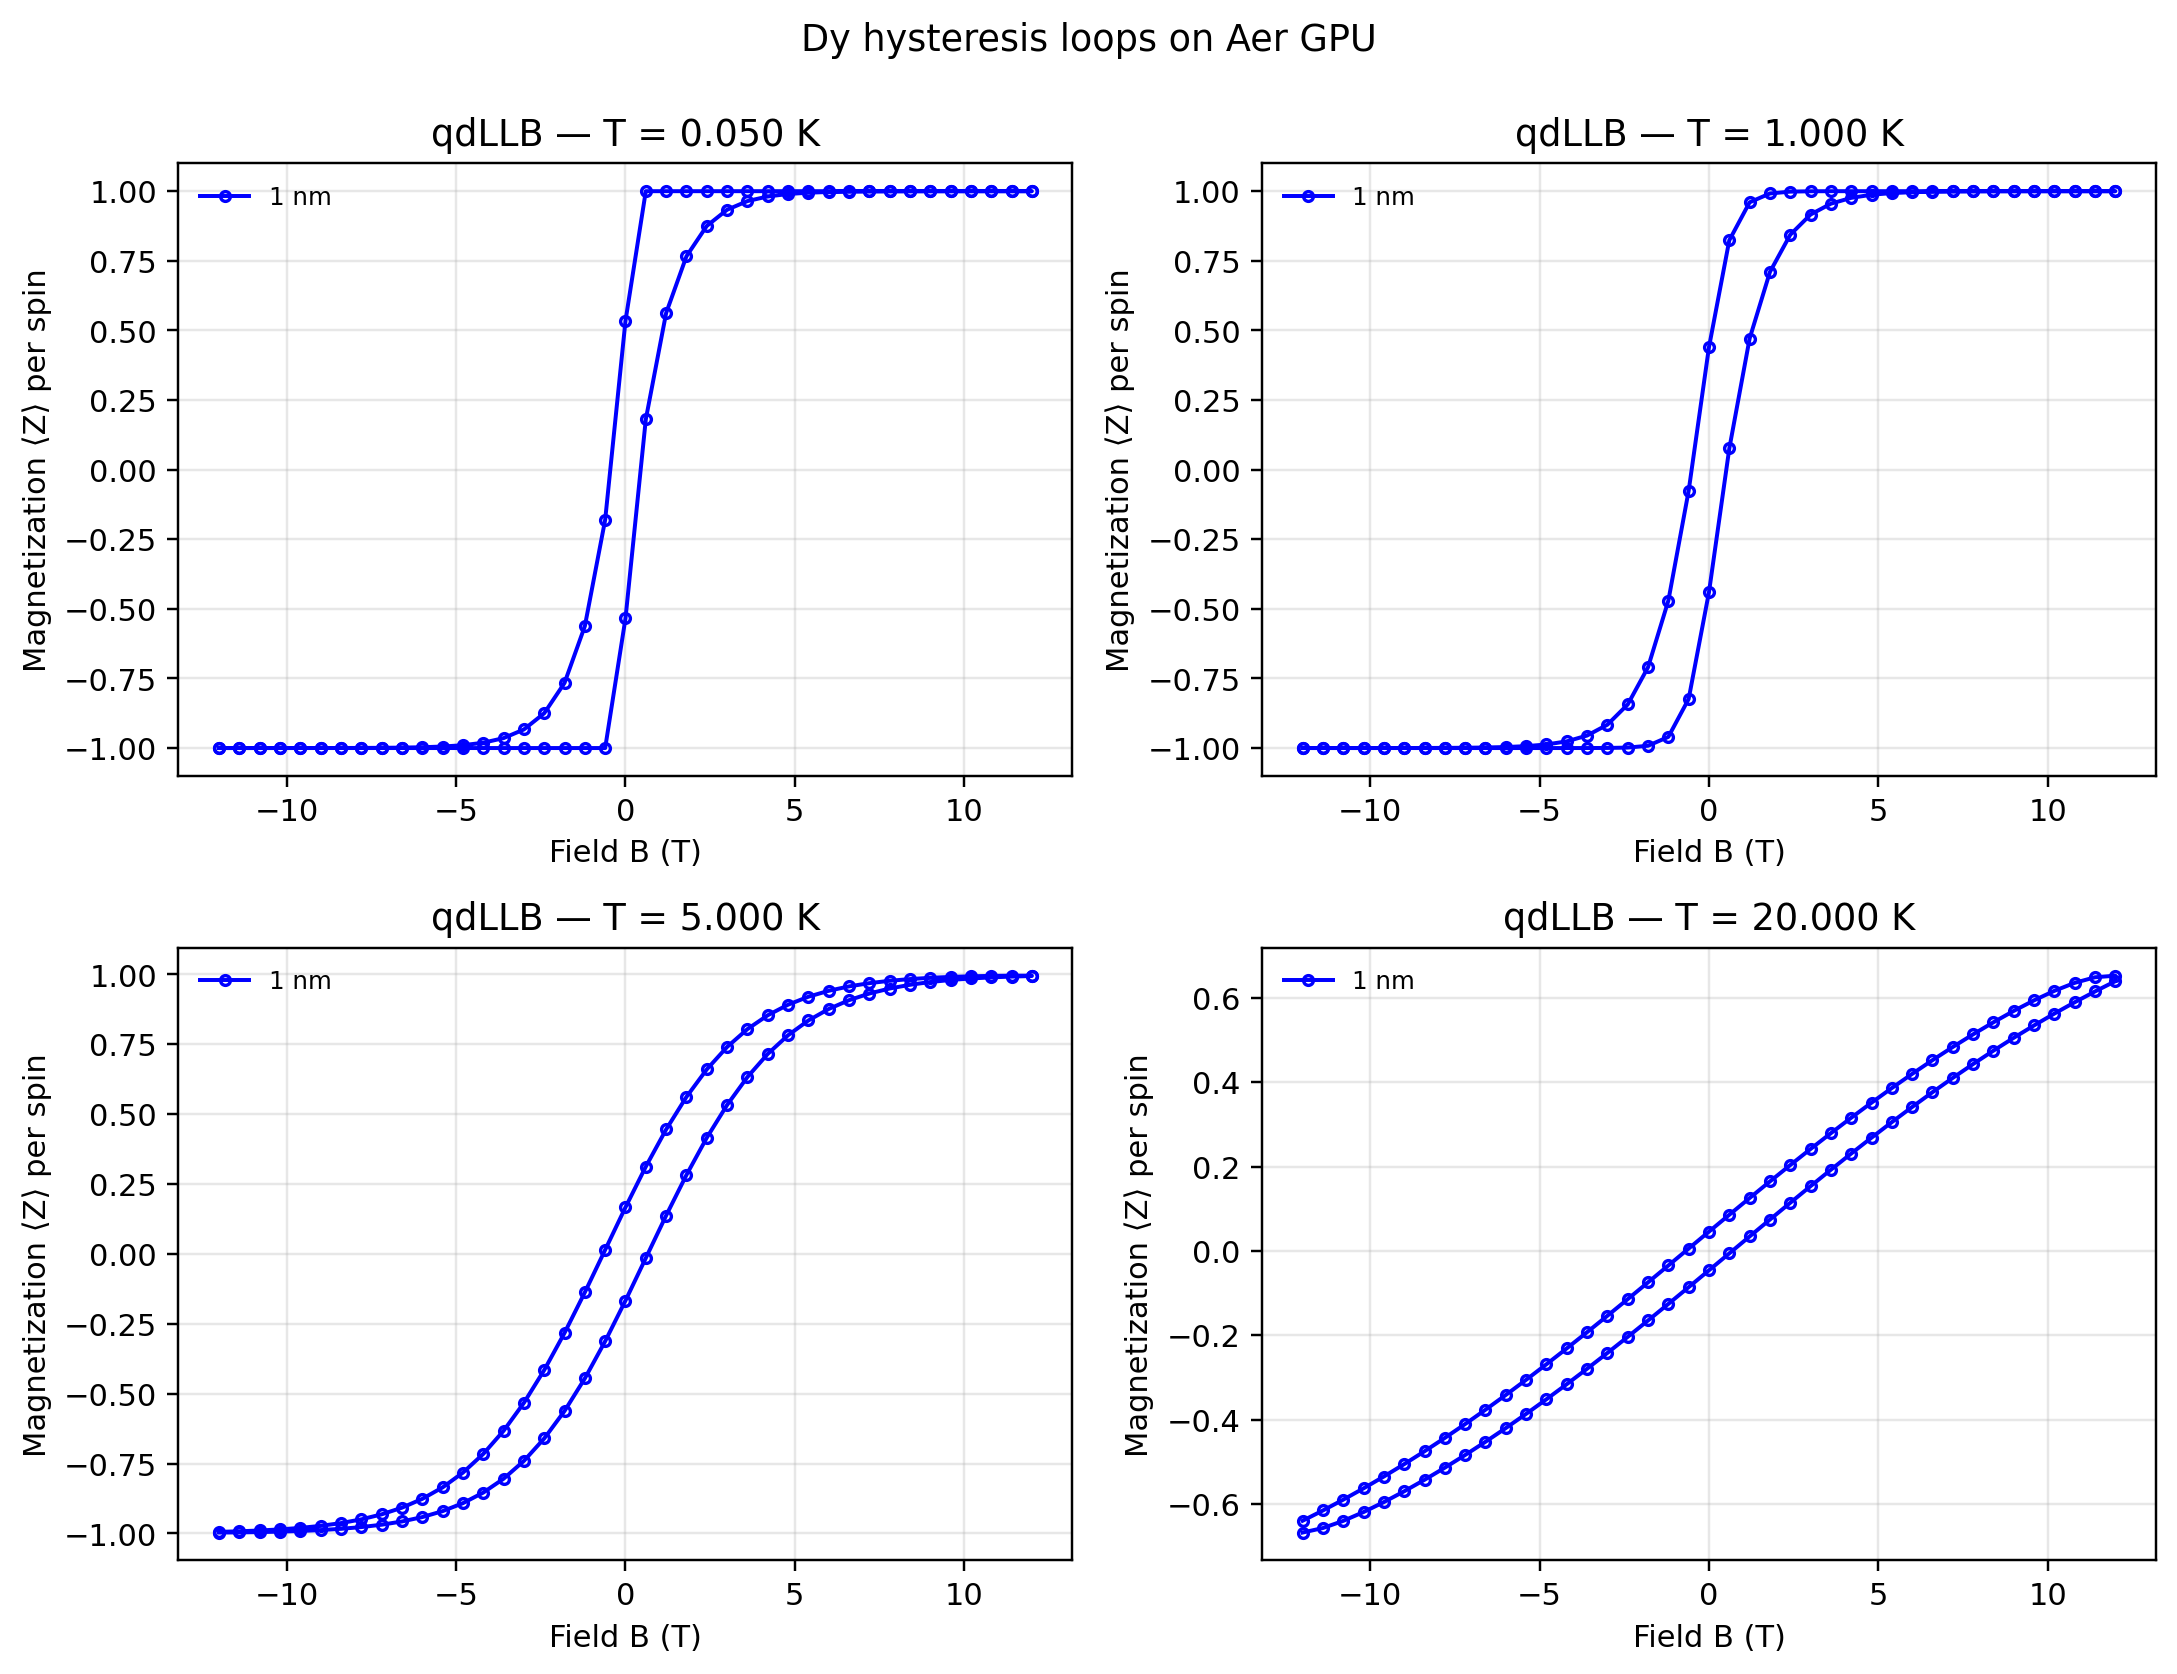

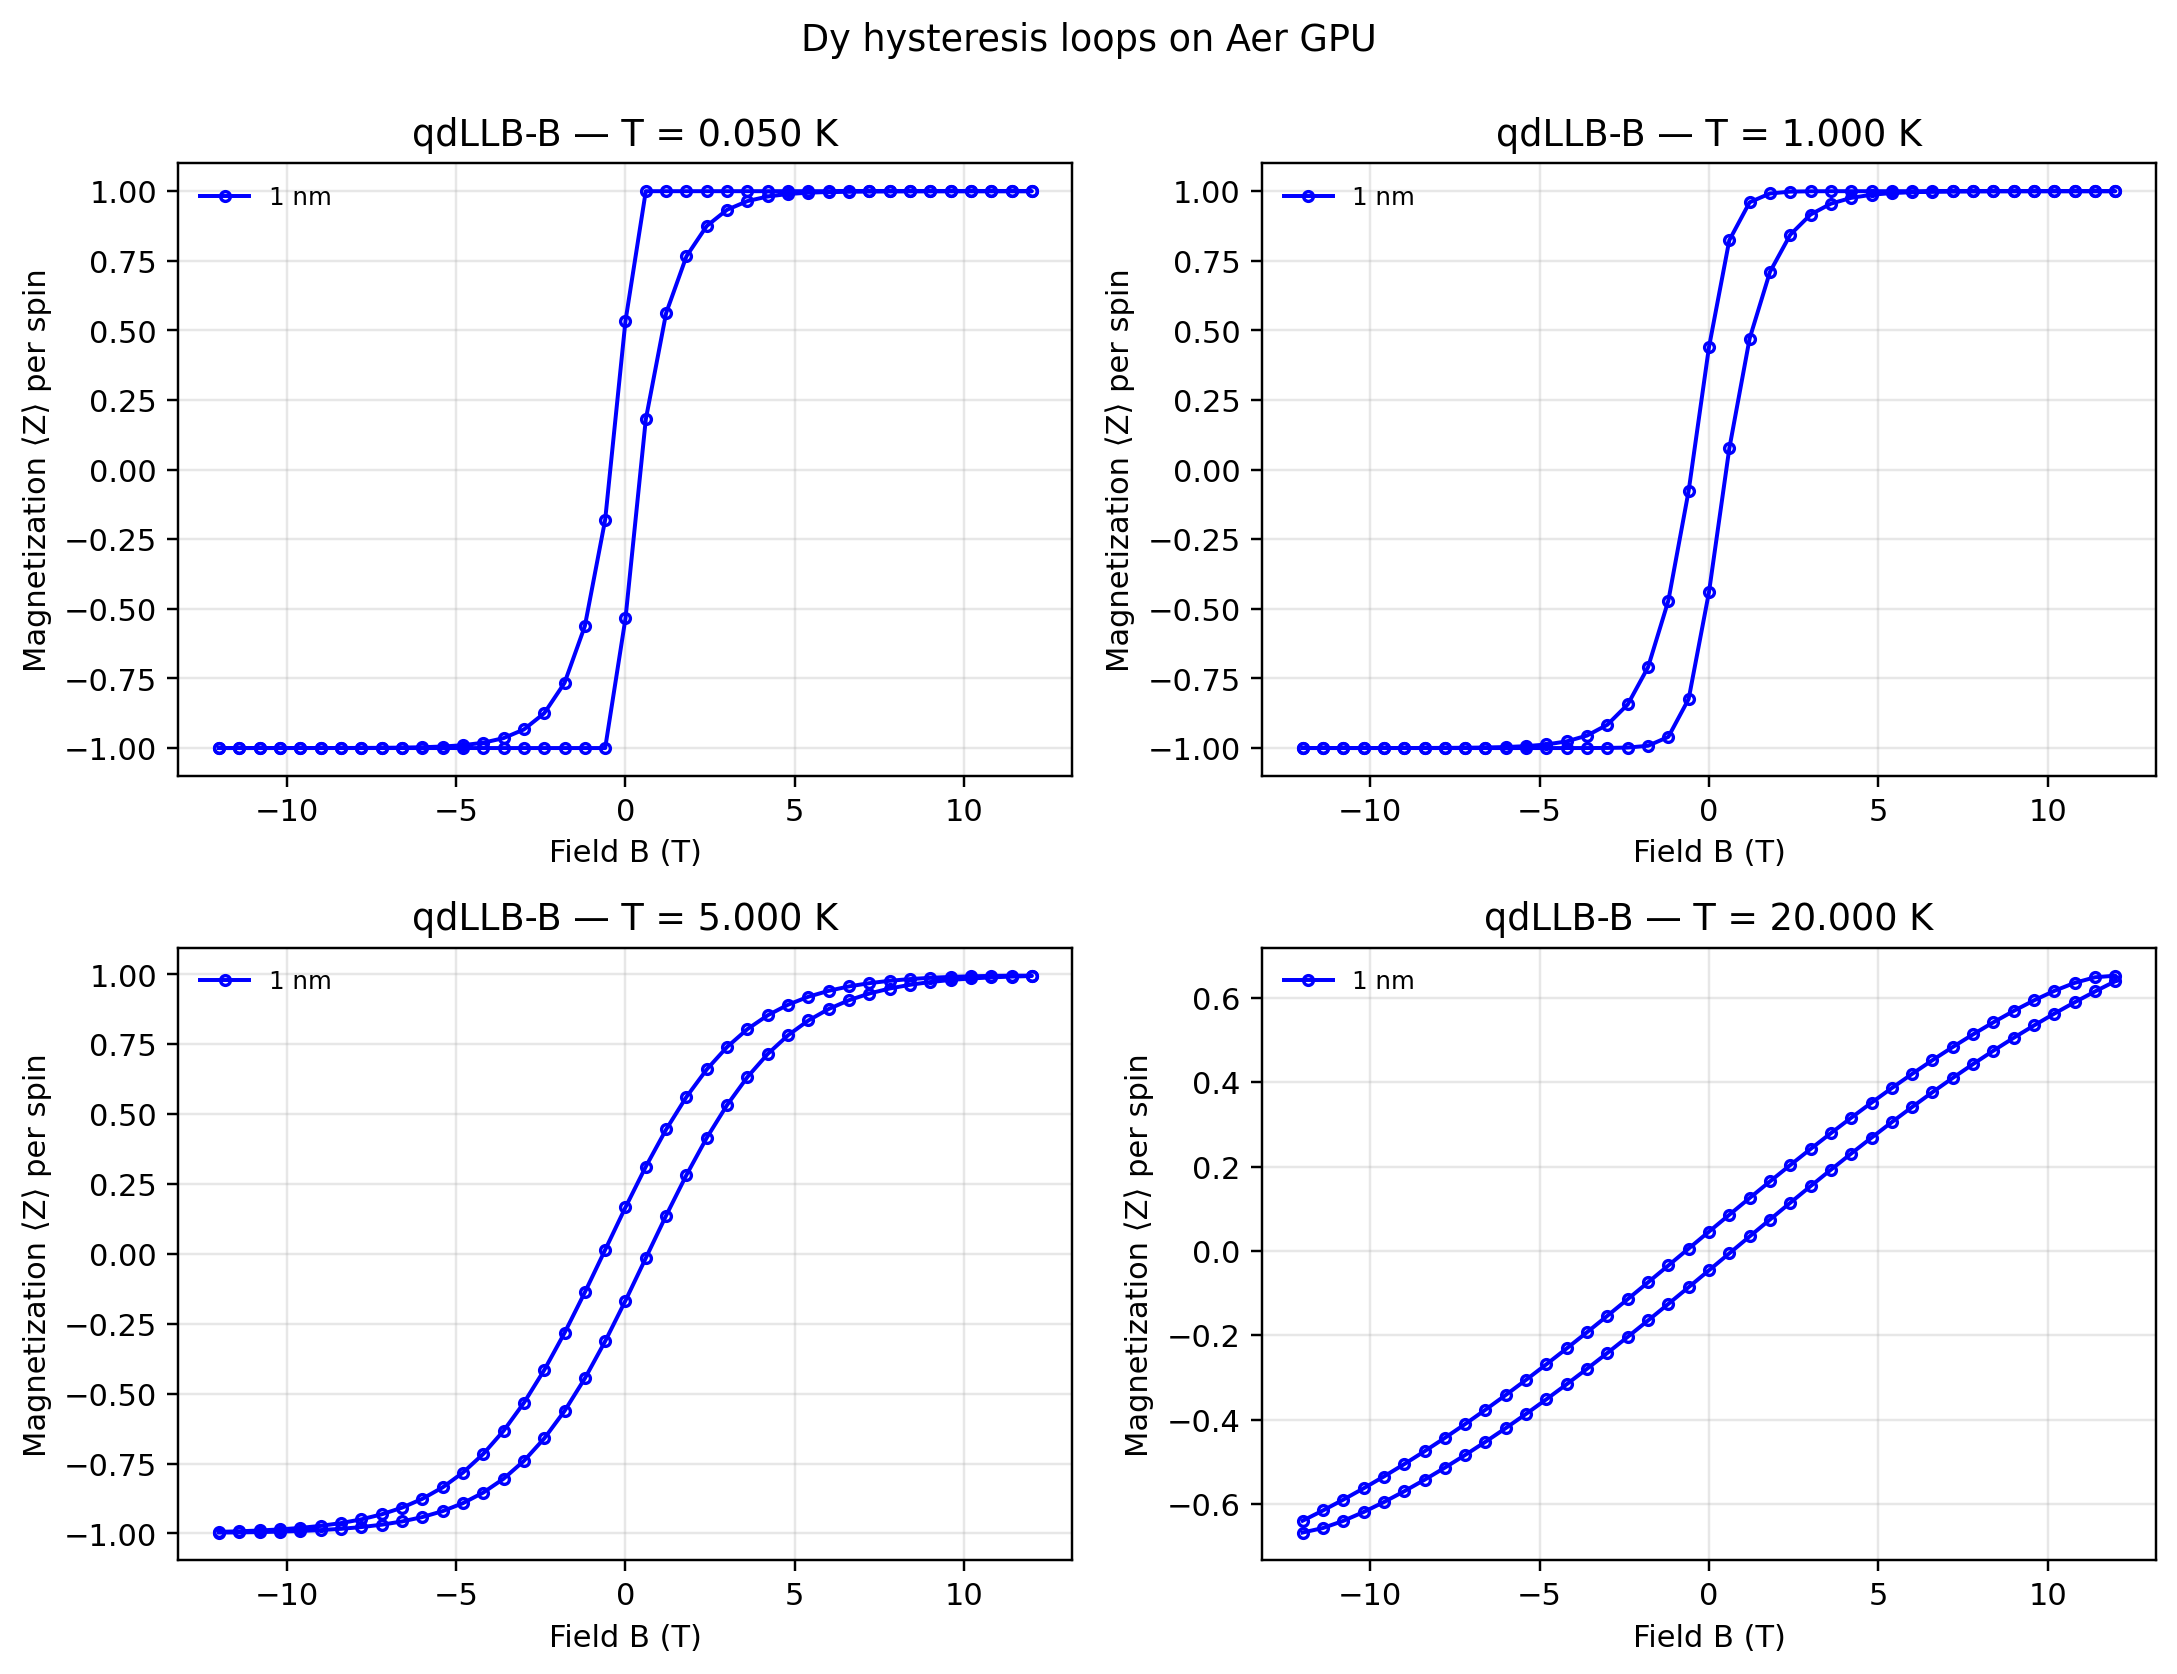

In [20]:
# @title Dy hysteresis loops (1-5 nm; down to 50 mK) on Qiskit Aer GPU
# PEP 8 / PEP 257 compliant; Colab-ready; Qiskit 2.2+.
#
# Models:
#   - "dEqLLB_B": GKSL + short Pauli-evolution “kick” per slice + classical blend
#   - "qLLB_B"  : GKSL with KMS-aware, quantum-slowed rates + classical blend
#   - "qdLLB"   : GKSL only (quantum dynamic LLB)
#   - "qdLLB_B" : GKSL + Weiss/Brillouin envelope blending (classical)
#
# Enhancements:
#   • Hollow circle markers; edge color matches the line color
#   • Size-scaled static Z-bias; warm-up thermalization at −Bmax
#   • Optional adaptive slices per field step

from __future__ import annotations

from dataclasses import dataclass
from functools import lru_cache
from typing import Dict, List, Sequence, Tuple

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Kraus
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator


# --------------------------- Global Dy "physics" knobs -------------------------

@dataclass
class DyKnobs:
    """Controls for Dy finite-size mapping and GKSL rate shapes."""
    dy_bulk_tc_K: float = 86.0        # ≈ 85-90 K in literature
    n_spins: int = 4
    delta_aniso: float = 0.6
    j_factor: float = 1.6
    h_frac: float = 0.24              # base h before size scaling
    # qLLB-inspired GKSL rates
    gamma1_0: float = 0.25
    gamma1_alpha: float = 1.1
    gamma_phi_0: float = 0.10
    gamma_phi_alpha: float = 1.0
    size_boost: float = 0.30
    use_ehrenfest_kick: bool = True
    dt: float = 0.15                  # “time” per GKSL slice
    dpi: int = 220
    seed: int = 7

K = DyKnobs()


# --------------------------- Hysteresis-specific knobs -------------------------

@dataclass
class HystKnobs:
    """Controls for Dy hysteresis loops on Aer GPU."""
    sizes_nm: Tuple[float, ...] = (1.0,)
    temps_K: Tuple[float, ...] = (0.05, 1.0, 5.0, 20.0)
    b_max_T: float = 12.0
    b_points: int = 41                 # per half-sweep
    slices_per_B: int = 6
    h_frac_alpha: float = 1.2          # h(L) *= (L/1 nm)^(-alpha)
    warmup_slices: int = 200
    adaptive_slices: bool = False
    target_relax_per_step: float = 0.6
    g_eff: float = 2.0
    mu_B_eV_T: float = 5.788381806e-5  # eV/T
    use_kinetic_blend: bool = True
    blend_power: float = 2.0
    q_slow_strength: float = 0.6
    dpi: int = 220
    seed: int = 7

H = HystKnobs()


# --------------------------- High-contrast palette -----------------------------

# Okabe-Ito palette (colorblind-friendly, high contrast).
# We’ll use the first five distinct, saturated colors for sizes 1-5 nm.
HC_PALETTE = [
    "#0000FF",  # blue
    "#D55E00",  # vermilion
    "#009E73",  # bluish green
    "#CC79A7",  # reddish purple
    "#E69F00",  # orange
    "#000000",  # black (spare)
    "#56B4E9",  # sky blue (spare)
    "#F0E442",  # yellow (spare)
]


# --------------------------- Physical constants --------------------------------

k_B_eV = 8.617333262145e-5  # eV/K


# --------------------------- Finite-size mapping (cuboid) ----------------------

def tc_finite_size_cuboid(size_nm: float,
                          tc_bulk_K: float,
                          l0_nm: float = 1.0,
                          exponent: float = 1.0) -> float:
    """Finite-size Curie scale for a cuboid edge L (nm)."""
    if size_nm <= 0.0:
        return 0.0
    factor = max(0.0, 1.0 - (l0_nm / size_nm) ** exponent)
    return float(factor * tc_bulk_K)


def size_to_J_h(size_nm: float, tc_bulk_K: float) -> Tuple[float, float]:
    """Map size → (J, h) [eV] using Tc(L)."""
    TcL = tc_finite_size_cuboid(size_nm, tc_bulk_K)
    J = K.j_factor * k_B_eV * TcL
    h = K.h_frac * J
    return float(J), float(h)


# --------------------------- Hamiltonian (cluster) -----------------------------

def heisenberg_ferro_ham(n: int, j_eV: float, delta: float, h_eV: float) -> SparsePauliOp:
    """Return H = -J Σ(XX + YY + Δ ZZ) - h Σ Z (periodic ring)."""
    terms: List[Tuple[str, float]] = []
    for i in range(n):
        j = (i + 1) % n

        def pw(a: str, b: str) -> str:
            s = ["I"] * n
            s[i] = a
            s[j] = b
            return "".join(s[::-1])  # little-endian

        terms += [
            (pw("X", "X"), -j_eV),
            (pw("Y", "Y"), -j_eV),
            (pw("Z", "Z"), -delta * j_eV),
        ]

    for i in range(n):
        s = ["I"] * n
        s[i] = "Z"
        terms.append(("".join(s[::-1]), -h_eV))
    return SparsePauliOp.from_list(terms)


# --------------------------- Channels (Kraus) ----------------------------------

def gad_kraus(a: float, p1: float) -> List[np.ndarray]:
    """Generalized amplitude damping (finite-T) Kraus operators."""
    a = min(max(a, 0.0), 1.0)
    p1 = min(max(p1, 0.0), 1.0)
    s1 = math.sqrt(max(0.0, 1.0 - a))
    sp = math.sqrt(p1)
    sm = math.sqrt(1.0 - p1)
    K0 = sp * np.array([[s1, 0.0], [0.0, 1.0]], dtype=complex)
    K1 = sp * np.array([[0.0, 0.0], [math.sqrt(max(0.0, a)), 0.0]], dtype=complex)
    K2 = sm * np.array([[1.0, 0.0], [0.0, s1]], dtype=complex)
    K3 = sm * np.array([[0.0, math.sqrt(max(0.0, a))], [0.0, 0.0]], dtype=complex)
    return [K0, K1, K2, K3]


def phase_damp_kraus(b: float) -> List[np.ndarray]:
    """Pure dephasing Kraus operators (probability b per slice)."""
    b = min(max(b, 0.0), 1.0)
    s = math.sqrt(max(0.0, 1.0 - b))
    K0 = np.array([[1.0, 0.0], [0.0, s]], dtype=complex)
    K1 = np.array([[0.0, 0.0], [0.0, math.sqrt(max(0.0, b))]], dtype=complex)
    return [K0, K1]


# --------------------------- GPU simulator -------------------------------------

def make_gpu_sim() -> AerSimulator:
    """Return a GPU-backed density-matrix simulator (supports Kraus)."""
    return AerSimulator(method="density_matrix", device="GPU")


# --------------------------- Classical envelopes --------------------------------

def weiss_magnetization(T_K: float, tcL_K: float,
                        max_iter: int = 512, tol: float = 1e-10,
                        mix: float = 0.7) -> float:
    """Weiss mean-field envelope m = tanh((Tc/T) m)."""
    if T_K <= 0.0 or tcL_K <= 0.0:
        return 0.0
    m = 0.999 if T_K < tcL_K else 0.0
    for _ in range(max_iter):
        new_m = math.tanh((tcL_K / T_K) * m)
        m_next = mix * new_m + (1.0 - mix) * m
        if abs(m_next - m) < tol:
            return float(m_next)
        m = m_next
    return float(m)


# --------------------------- Rate helpers (per slice) --------------------------

def _safe_beta(T_K: float) -> float:
    return 1.0 / max(1e-12, k_B_eV * T_K)


def _coth_safe(y: float) -> float:
    ay = abs(y)
    if ay < 1e-8:
        return (1.0 / max(1e-12, y)) + (y / 3.0)
    return math.cosh(y) / max(1e-300, math.sinh(y))


def _rates_per_slice(model: str,
                     size_nm: float,
                     T_K: float,
                     TcL: float,
                     h_total_eV: float) -> Tuple[float, float, float]:
    """Return (a, b, p1) for the chosen model and slice."""
    beta = _safe_beta(T_K)
    delta_eV = 2.0 * h_total_eV

    # KMS equilibrium excited population: p1 = 1 / (1 + e^{βΔ})
    expo = beta * delta_eV
    if expo > 80.0:
        p1 = 0.0
    elif expo < -80.0:
        p1 = 1.0
    else:
        p1 = 1.0 / (1.0 + math.exp(expo))

    # Baseline qLLB-like scaling
    tfrac = min(2.0, T_K / max(1e-9, TcL)) if TcL > 0 else 2.0
    gamma1_base = K.gamma1_0 * (tfrac ** K.gamma1_alpha) * (
        1.0 + K.size_boost / max(1e-9, size_nm)
    )
    gamma_phi = K.gamma_phi_0 * (tfrac ** K.gamma_phi_alpha)

    if model == "qLLB_B":
        # KMS-aware longitudinal scaling with quantum slowdown near Tc(L)
        y = 0.5 * beta * delta_eV
        kms_scale = _coth_safe(y)  # ≈ 1 + 2 n_th
        q_slow = 1.0 / (1.0 + H.q_slow_strength * max(0.0, TcL / max(T_K, 1e-12)))
        gamma1 = gamma1_base * kms_scale * q_slow
        gamma_phi *= max(0.6, q_slow)
    else:
        gamma1 = gamma1_base

    a = 1.0 - math.exp(-gamma1 * K.dt)
    b = 1.0 - math.exp(-gamma_phi * K.dt)
    return float(a), float(b), float(p1)


# --------------------------- Magnetization operator cache ----------------------

@lru_cache(maxsize=8)
def _mz_operator(n: int) -> np.ndarray:
    """Return full (Σ_i Z_i) / n operator for n qubits as a dense ndarray."""
    Z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=complex)
    Id = np.eye(2, dtype=complex)
    ops: List[np.ndarray] = []
    for i in range(n):
        op = 1
        for k in range(n):
            op = np.kron(op, Z if (k == (n - 1 - i)) else Id)
        ops.append(op)
    return sum(ops) / float(n)


def magnetization_from_rho(rho: np.ndarray, n: int) -> float:
    """Return (1/n) Σ_i ⟨Z_i⟩ from a density matrix rho."""
    Mz = _mz_operator(n)
    return float(np.real(np.trace(rho @ Mz)))


# --------------------------- Circuit builder for a B-sequence ------------------

def build_hysteresis_circuit(
    model: str,
    size_nm: float,
    T_K: float,
    b_seq_T: np.ndarray,
) -> Tuple[QuantumCircuit, List[str]]:
    """Build a circuit that evolves through the entire B-sequence."""
    n = K.n_spins
    TcL = tc_finite_size_cuboid(size_nm, K.dy_bulk_tc_K)
    J_eV, h_static_eV = size_to_J_h(size_nm, K.dy_bulk_tc_K)

    # Size-scaled static Z-bias
    h_static_eV *= (size_nm / 1.0) ** (-H.h_frac_alpha)

    qc = QuantumCircuit(n, name=f"{model}-L={size_nm:.2f}nm-T={T_K:.3f}K")
    labels: List[str] = []

    # Warm-up at start field (−Bmax)
    b_start = float(b_seq_T[0])
    hB_start_eV = H.g_eff * H.mu_B_eV_T * b_start
    h_tot_start = h_static_eV + hB_start_eV
    H_start: SparsePauliOp = heisenberg_ferro_ham(n, J_eV, K.delta_aniso, h_tot_start)
    a0, b0, p10 = _rates_per_slice(model, size_nm, T_K, TcL, h_tot_start)
    gad0 = Kraus(gad_kraus(a0, p10)).to_instruction(); gad0.label = "GAD"
    pd0 = Kraus(phase_damp_kraus(b0)).to_instruction(); pd0.label = "PD"
    for _ in range(max(0, H.warmup_slices)):
        if model == "dEqLLB_B" and K.use_ehrenfest_kick:
            qc.append(PauliEvolutionGate(H_start, time=K.dt), range(n))
        for q in range(n):
            qc.append(gad0, [q])
            qc.append(pd0, [q])
    qc.barrier(label="thermalize@-Bmax")

    # Field sweep: -Bmax → +Bmax → -Bmax
    for k, bT in enumerate(b_seq_T):
        hB_eV = H.g_eff * H.mu_B_eV_T * float(bT)
        h_tot = h_static_eV + hB_eV
        H_step: SparsePauliOp = heisenberg_ferro_ham(n, J_eV, K.delta_aniso, h_tot)

        a, b, p1 = _rates_per_slice(model, size_nm, T_K, TcL, h_tot)
        gad_inst = Kraus(gad_kraus(a, p1)).to_instruction(); gad_inst.label = "GAD"
        pd_inst = Kraus(phase_damp_kraus(b)).to_instruction(); pd_inst.label = "PD"

        slices_here = H.slices_per_B
        if H.adaptive_slices:
            a_eff = max(1e-6, a)
            slices_here = max(1, int(round(H.target_relax_per_step / a_eff)))

        for _ in range(slices_here):
            if model == "dEqLLB_B" and K.use_ehrenfest_kick:
                qc.append(PauliEvolutionGate(H_step, time=K.dt), range(n))
            for q in range(n):
                qc.append(gad_inst, [q])
                qc.append(pd_inst, [q])

        lab = f"step_{k:04d}"
        qc.save_density_matrix(label=lab)
        labels.append(lab)
        qc.barrier()

    return qc, labels


# --------------------------- Run & collect ------------------------------------

def run_hysteresis_and_collect(
    model: str,
    size_nm: float,
    T_K: float,
    b_seq_T: np.ndarray,
    sim: AerSimulator,
) -> Tuple[np.ndarray, np.ndarray]:
    """Execute one hysteresis circuit and return (B[T], Mz per spin)."""
    qc, labels = build_hysteresis_circuit(model, size_nm, T_K, b_seq_T)
    exec_qc = transpile(qc, backend=sim, optimization_level=1)
    result = sim.run(exec_qc, seed_simulator=H.seed).result()

    n = K.n_spins
    M = np.empty(len(labels), dtype=float)
    for i, lab in enumerate(labels):
        rho = np.array(result.data(0)[lab], dtype=complex)
        M[i] = magnetization_from_rho(rho, n)

    # Classical blending for "*_B" models
    if H.use_kinetic_blend and model in ("qdLLB_B", "qLLB_B"):
        TcL = tc_finite_size_cuboid(size_nm, K.dy_bulk_tc_K)
        beta = _safe_beta(T_K)
        eps = min(0.95, (T_K / max(1e-12, TcL)) ** H.blend_power) if TcL > 0 else 0.95
        if model == "qdLLB_B":
            m_eq = weiss_magnetization(T_K, TcL)
            M = (1.0 - eps) * M + eps * m_eq
        else:
            # q‑LLB‑B: Brillouin J=1/2 with x = β (h_static + g μ_B B)
            _, h_static_eV = size_to_J_h(size_nm, K.dy_bulk_tc_K)
            h_static_eV *= (size_nm / 1.0) ** (-H.h_frac_alpha)
            x = beta * (h_static_eV + H.g_eff * H.mu_B_eV_T * b_seq_T)
            m_eq = np.tanh(x)
            M = (1.0 - eps) * M + eps * m_eq

    return b_seq_T.copy(), M


# --------------------------- Plotting -----------------------------------------

def make_b_sweep() -> np.ndarray:
    """Return a symmetric B-sweep: -Bmax → +Bmax → -Bmax (Tesla)."""
    up = np.linspace(-H.b_max_T, +H.b_max_T, H.b_points, endpoint=True)
    down = np.linspace(+H.b_max_T, -H.b_max_T, H.b_points, endpoint=True)
    return np.concatenate([up, down])


def plot_hysteresis_for_model(
    model: str,
    sizes: Sequence[float],
    temps: Sequence[float],
    sim: AerSimulator,
) -> None:
    """Grid of subplots (by temperature) showing loops for all sizes."""
    plt.rcParams["figure.dpi"] = H.dpi
    nT = len(temps)
    ncols = 2
    nrows = (nT + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3.8 * nrows))
    axes = np.atleast_1d(axes).ravel()

    b_seq = make_b_sweep()
    for ax, T in zip(axes, temps):
        for idx, L in enumerate(sizes):
            color = HC_PALETTE[idx % len(HC_PALETTE)]
            B, M = run_hysteresis_and_collect(model, float(L), float(T), b_seq, sim)
            ax.plot(
                B,
                M,
                linestyle="-",
                linewidth=1.3,
                marker="o",
                markersize=3.2,
                markerfacecolor="none",     # hollow markers
                markeredgewidth=1.1,
                markeredgecolor=color,
                color=color,
                label=f"{L:.0f} nm",
            )
        ax.set_xlabel("Field B (T)")
        ax.set_ylabel("Magnetization ⟨Z⟩ per spin")
        ax.set_title(f"{model} — T = {T:.3f} K")
        ax.grid(True, alpha=0.30)
        ax.legend(ncol=3, fontsize=8, frameon=False, loc="best")

    # Hide unused axes if nT is odd
    for j in range(len(temps), len(axes)):
        axes[j].axis("off")

    fig.suptitle("Dy hysteresis loops on Aer GPU", y=0.995, fontsize=12)
    plt.tight_layout()
    plt.show()


# --------------------------- Driver -------------------------------------------

def main() -> None:
    sim = make_gpu_sim()
    sizes = H.sizes_nm
    temps = H.temps_K

    # Four models (separate figures)
    plot_hysteresis_for_model("dEqLLB-B", sizes, temps, sim)
    plot_hysteresis_for_model("qLLB-B",  sizes, temps, sim)
    plot_hysteresis_for_model("qdLLB",   sizes, temps, sim)
    plot_hysteresis_for_model("qdLLB-B", sizes, temps, sim)


# Run
main()

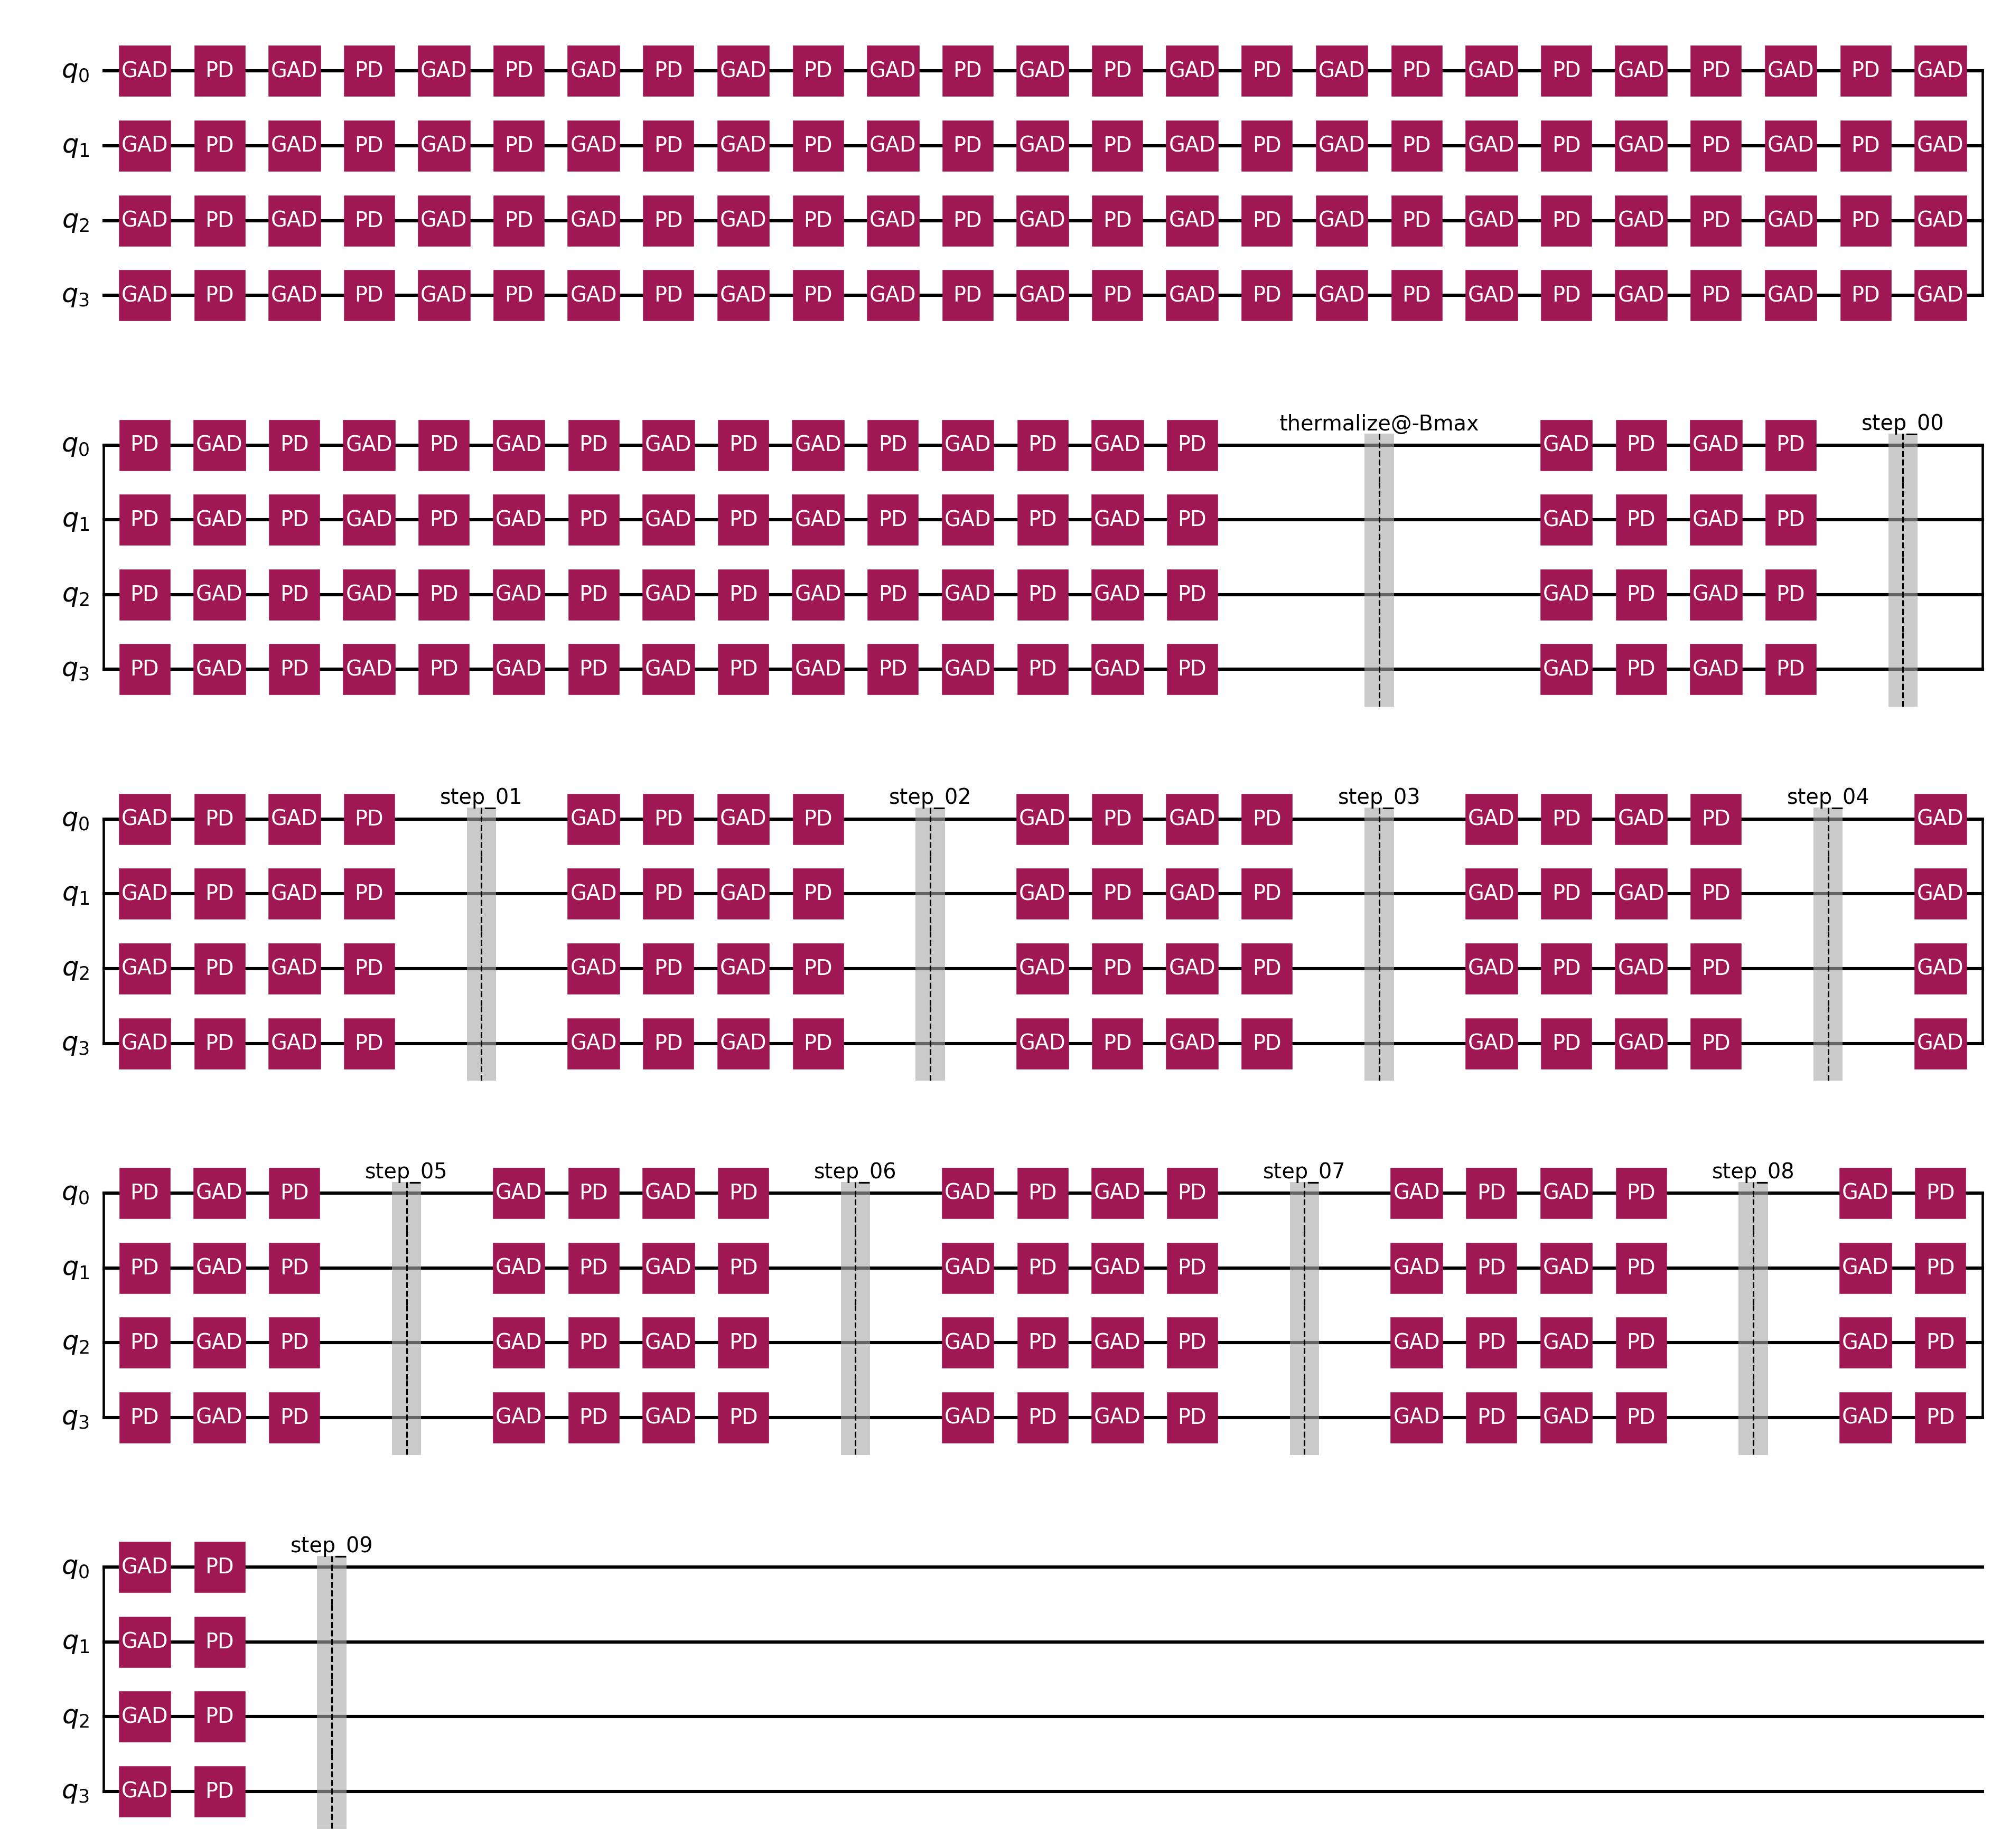

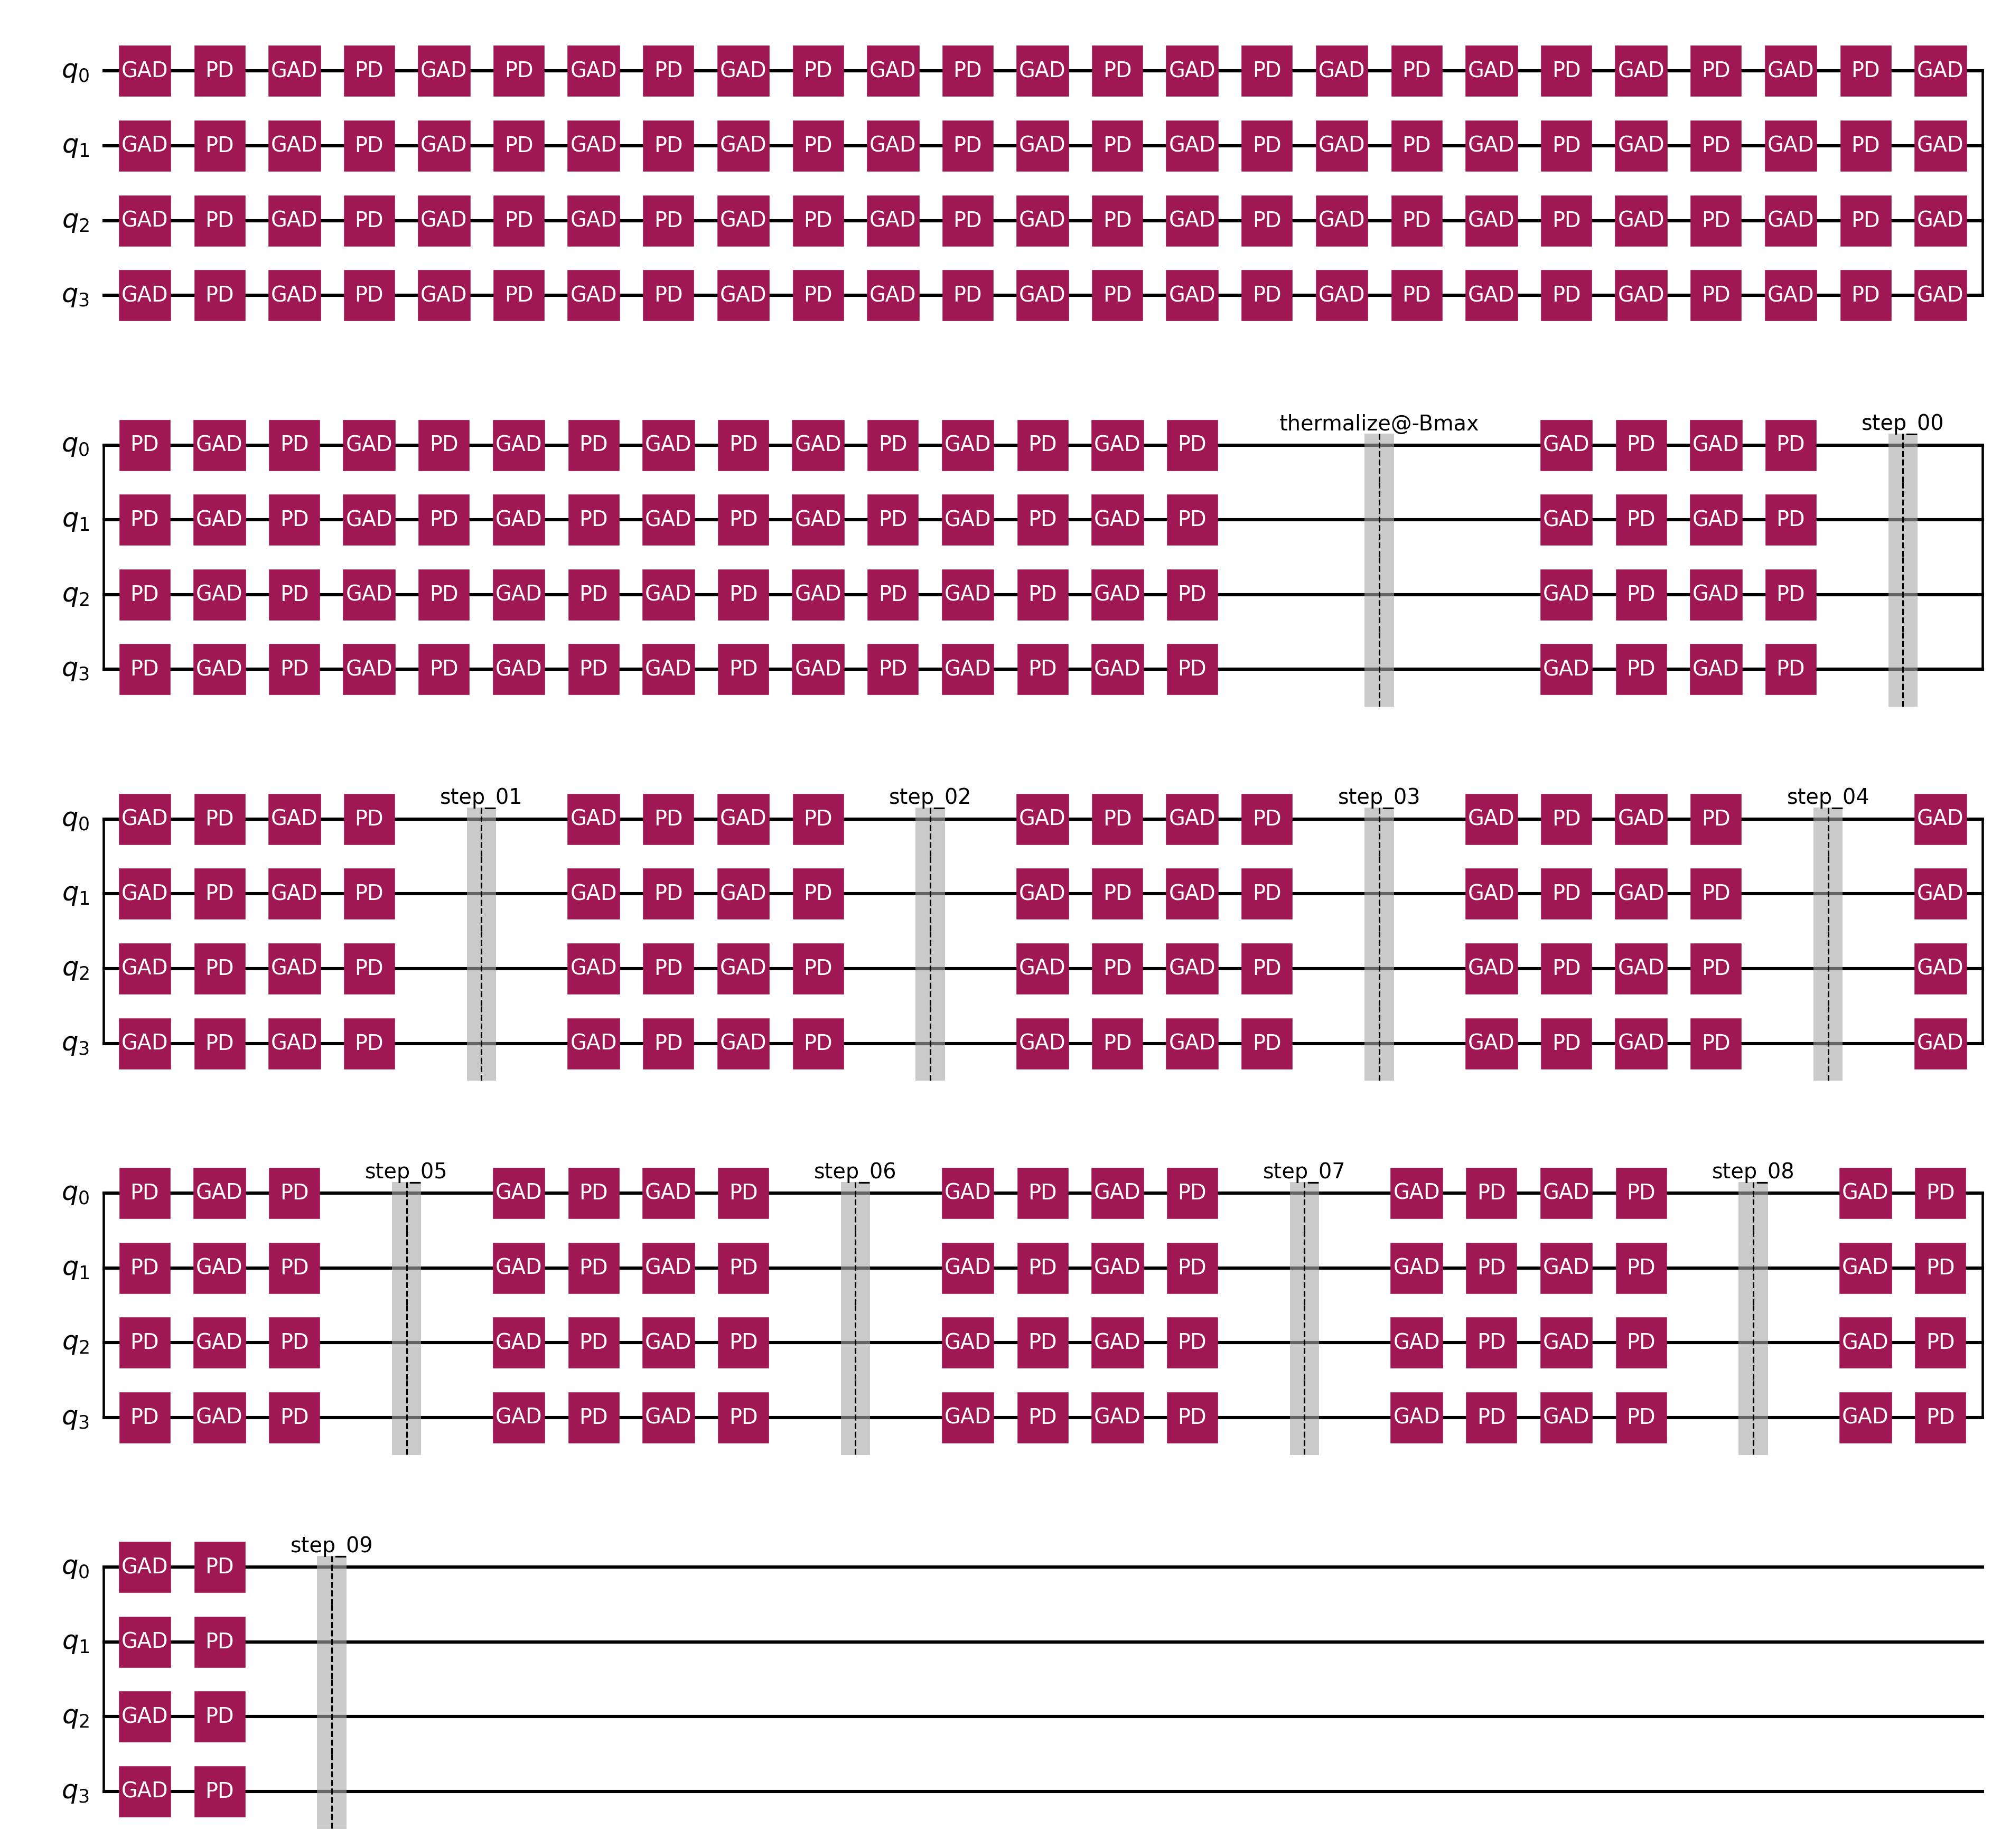

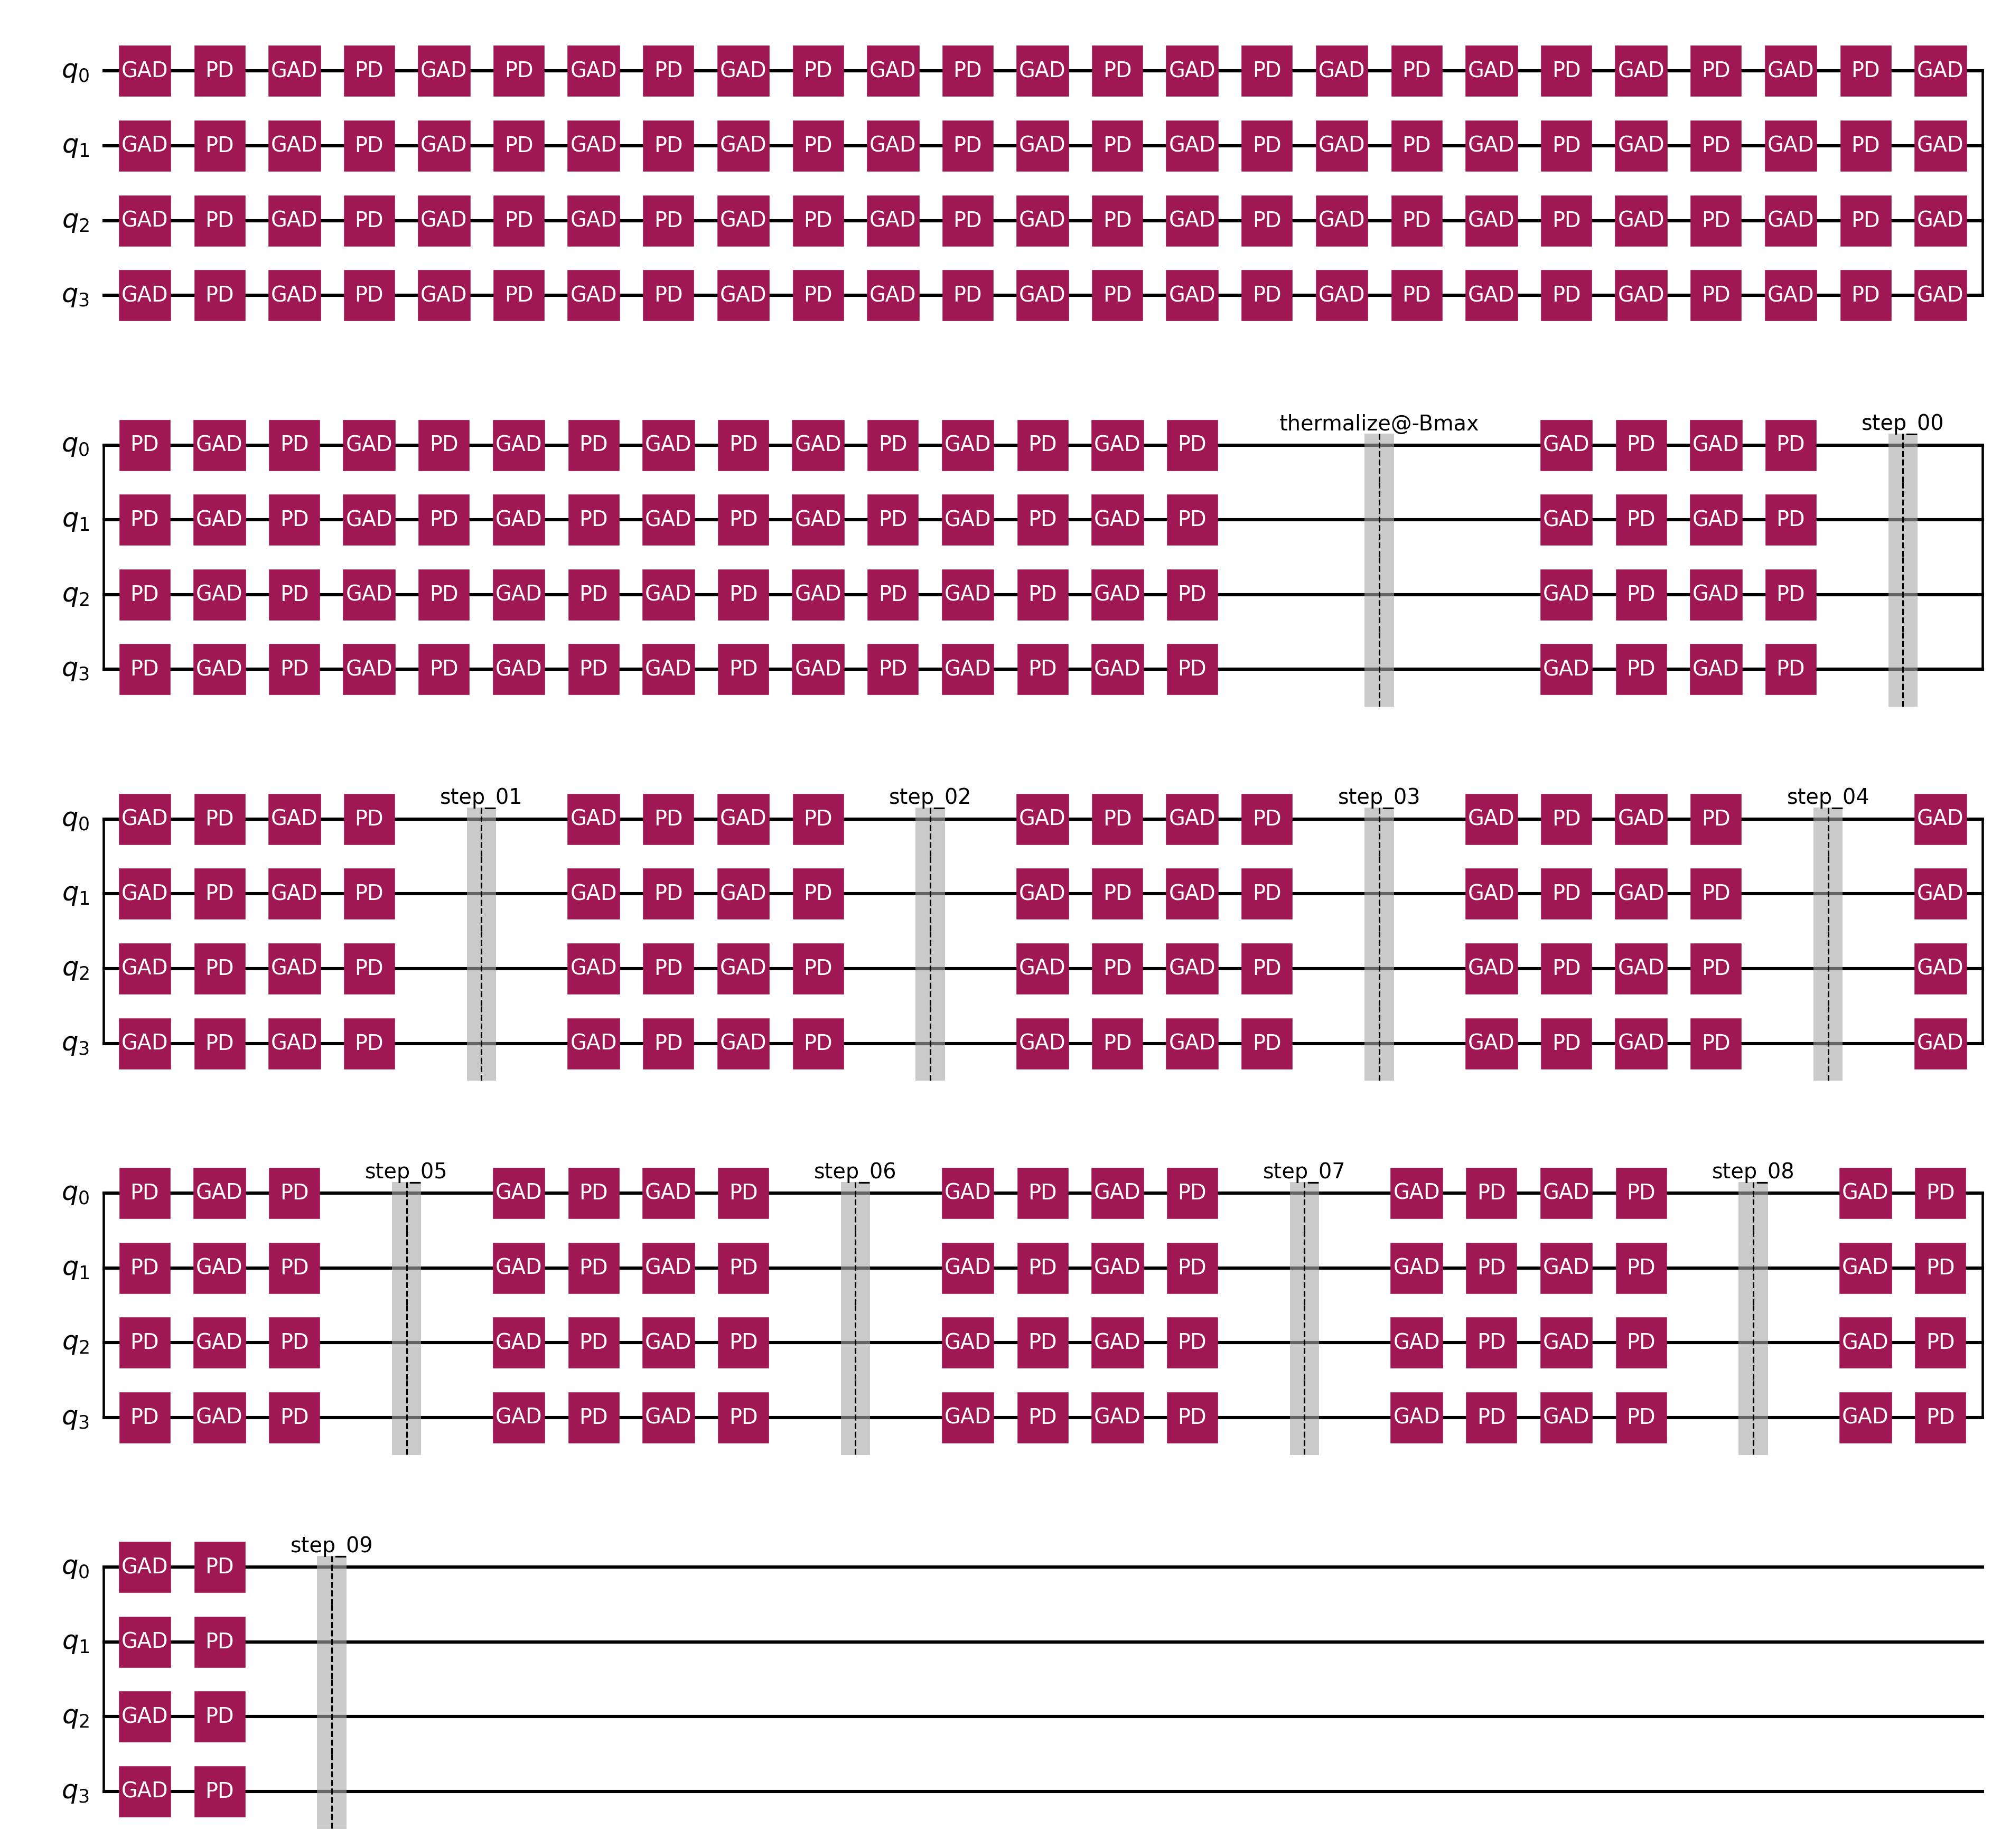

In [21]:
# @title Visualize the Dy hysteresis *circuits* (Qiskit circuit plots; preview)
# PEP 8 / PEP 257 compliant; Colab-ready.  **Requires** the hysteresis cell to
# be executed first so that: K, H, tc_finite_size_cuboid, size_to_J_h,
# heisenberg_ferro_ham, gad_kraus, phase_damp_kraus, and _rates_per_slice exist.
#
# What this cell does:
# - Builds *preview* circuits for the four models used in the Dy hysteresis runs:
#     1) dEqLLB_B  — GKSL + short Pauli-evolution “kick” per slice
#     2) qLLB_B    — GKSL with KMS-aware, quantum-slowed rates
#     3) qdLLB     — GKSL only
#     4) qdLLB_B   — GKSL + classical envelope (off-circuit)
# - Uses a short B-sequence and a few GKSL slices so the diagram remains readable.
# - Draws each circuit with Qiskit’s Matplotlib drawer.

from __future__ import annotations

from typing import Dict, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus
from qiskit.circuit.library import PauliEvolutionGate


def _make_b_sweep_preview(n_steps: int = 5) -> np.ndarray:
    """Return a short symmetric B-sweep: −Bmax → +Bmax → −Bmax (Tesla)."""
    n_steps = max(3, int(n_steps))
    up = np.linspace(-H.b_max_T, +H.b_max_T, n_steps, endpoint=True)
    down = np.linspace(+H.b_max_T, -H.b_max_T, n_steps, endpoint=True)
    return np.concatenate([up, down])


def _build_hysteresis_circuit_preview(
    model: str,
    size_nm: float,
    T_K: float,
    steps_B: int = 5,
    slices_per_B: int = 2,
    warmup_slices: int = 20,
) -> QuantumCircuit:
    """Return a *logical* preview circuit for one model/size/temperature.

    This mirrors your production builder but uses a short B-sequence and
    fewer GKSL slices so the circuit fits on a page.
    """
    # Normalize model key to the underscore variant used in conditionals.
    mkey = model.replace("-", "_")

    # Cluster size & static mapping at this L
    n = K.n_spins
    TcL = tc_finite_size_cuboid(size_nm, K.dy_bulk_tc_K)
    J_eV, h_static_eV = size_to_J_h(size_nm, K.dy_bulk_tc_K)
    # Size-scaled static Z-bias
    h_static_eV *= (size_nm / 1.0) ** (-H.h_frac_alpha)

    # Short B sequence
    b_seq = _make_b_sweep_preview(steps_B)

    # Title line for the diagram
    title = {
        "dEqLLB_B": "d‑E‑qLLB‑B (GKSL + kick)",
        "qLLB_B":   "q‑LLB‑B (GKSL, KMS‑aware rates)",
        "qdLLB":    "q‑dLLB (GKSL only)",
        "qdLLB_B":  "q‑dLLB‑B (GKSL + blend, off‑circuit)",
    }.get(mkey, mkey)

    qc = QuantumCircuit(n, name=f"{title}\nL={size_nm:.2f} nm, T={T_K:.3f} K")

    # ---- Warm-up at start field (−Bmax) so the preview starts in remanence ----
    b_start = float(b_seq[0])
    hB_start_eV = H.g_eff * H.mu_B_eV_T * b_start
    h_tot_start = h_static_eV + hB_start_eV
    H_start = heisenberg_ferro_ham(n, J_eV, K.delta_aniso, h_tot_start)
    a0, b0, p10 = _rates_per_slice(mkey, size_nm, T_K, TcL, h_tot_start)
    gad0 = Kraus(gad_kraus(a0, p10)).to_instruction(); gad0.label = "GAD"
    pd0 = Kraus(phase_damp_kraus(b0)).to_instruction();  pd0.label  = "PD"
    for _ in range(max(0, int(warmup_slices))):
        if mkey == "dEqLLB_B" and K.use_ehrenfest_kick:
            qc.append(PauliEvolutionGate(H_start, time=K.dt), range(n))
        for q in range(n):
            qc.append(gad0, [q]); qc.append(pd0, [q])
    qc.barrier(label="thermalize@-Bmax")
    # ---------------------------------------------------------------------------

    # ---- Preview field steps (no state saves to keep the diagram clean) -------
    for k, bT in enumerate(b_seq):
        hB_eV = H.g_eff * H.mu_B_eV_T * float(bT)
        h_tot = h_static_eV + hB_eV
        H_step = heisenberg_ferro_ham(n, J_eV, K.delta_aniso, h_tot)

        a, b, p1 = _rates_per_slice(mkey, size_nm, T_K, TcL, h_tot)
        gad_inst = Kraus(gad_kraus(a, p1)).to_instruction(); gad_inst.label = "GAD"
        pd_inst = Kraus(phase_damp_kraus(b)).to_instruction();  pd_inst.label  = "PD"

        for _ in range(max(1, int(slices_per_B))):
            if mkey == "dEqLLB_B" and K.use_ehrenfest_kick:
                qc.append(PauliEvolutionGate(H_step, time=K.dt), range(n))
            for q in range(n):
                qc.append(gad_inst, [q]); qc.append(pd_inst, [q])

        qc.barrier(label=f"step_{k:02d}")

    return qc


def draw_hysteresis_circuits_preview(
    size_nm: float = 2.0,
    T_K: float = 5.0,
    steps_B: int = 5,
    slices_per_B: int = 2,
    warmup_slices: int = 20,
    dpi: int | None = None,
) -> Dict[str, QuantumCircuit]:
    """Build and render preview circuits for all four models. Returns dict."""
    models = ("dEqLLB_B", "qLLB_B", "qdLLB", "qdLLB_B")
    circuits: Dict[str, QuantumCircuit] = {}

    for m in models:
        qc = _build_hysteresis_circuit_preview(
            model=m,
            size_nm=size_nm,
            T_K=T_K,
            steps_B=steps_B,
            slices_per_B=slices_per_B,
            warmup_slices=warmup_slices,
        )
        circuits[m] = qc

        fig = qc.draw(output="mpl")  # Qiskit’s Matplotlib drawer
        try:
            fig.set_dpi(int(dpi if dpi is not None else getattr(K, "dpi", 220)))
        except Exception:
            pass
        display(fig)
        plt.close(fig)

    return circuits


# === Run the visualization preview (new cell) ===
_ = draw_hysteresis_circuits_preview(
    size_nm=1.0,        # choose any L in your sweep (1–5 nm)
    T_K=5.0,            # pick a representative temperature (e.g., 0.05, 1, 5, 20 K)
    steps_B=5,          # small B grid to keep the diagram compact
    slices_per_B=2,     # a couple of GKSL slices per field step
    warmup_slices=20,   # short warm-up so the “thermalize@-Bmax” block is visible
    dpi=getattr(K, "dpi", 220),
)

# The code below runs on an IBM quantum backend for real quantum results.